# Model's predictions comparison

**NOTEBOOK GOAL**: Compare predictions of models

Compared predictions:

- **1_RFR** - Notebook 5.3 Random forrest
- **2_XGB** - Notebook 6.4 XGBoost
- **3_AVG** - Notebook 7.0 AVG Monthly average
- **4_ENS** - Notebook 8.0 Ensamble by averaging all the previous models

In [1]:
from import_man import *
import collections

from BIP import get_BIP_error, apply_BIP_submission_format

**NOTE** If you cannot load the followig datasets, please go to the corresponding notebook and run it to generate the related dataset file. 

In [2]:
dfs_dict = collections.OrderedDict()
# the following dataset will be evaluated

In [3]:
dfs_dict['RFR'] = pd.read_csv('./dataset/test_m12_53_RFR_on_prep.csv')

In [4]:
dfs_dict['XGB'] = pd.read_csv('./dataset/test_m12_64_Model_XGBoost_final.csv')

In [5]:
dfs_dict['AVG'] = pd.read_csv('./dataset/test_m12_70_Model_monthly_average.csv')

In [6]:
#dfs_dict['ENS'] = pd.read_csv('./dataset/test_m12_80_Ensemble.csv')

In [7]:
# apply the apply_BIP_submission_format to all the dataframes
for mdl_lbl, df in dfs_dict.items():
    dfs_dict[mdl_lbl] = apply_BIP_submission_format(df)
    

# let's use those that will be submitted and in that order (rows)
#cp_with_actual = list(dfs_dict.values())[0]
#cp_with_actual = apply_BIP_submission_format(cp_with_actual)

### Data preparation for visualization

In [8]:
# assert all dataframe have the same number of rows
for i in range(0, len(dfs_dict) - 1):
    ii = i + 1
    
    df_i = list(dfs_dict.values())[i]
    df_ii = list(dfs_dict.values())[ii]
    
    print('len %d:     ' % i, df_i.shape[0])
    print('len %d:     ' % ii, df_ii.shape[0])
    print('Stores %d:  ' % i, len(df_i.StoreID.unique()))
    print('Stores %d:  ' % ii, len(df_ii.StoreID.unique()))
    print('D_Months %d:' % i, len(df_i.Month.unique()))
    print('D_Months %d:' % ii, len(df_ii.Month.unique()))
    
    assert(df_i.shape[0] == df_ii.shape[0])
    assert(len(df_i.StoreID.unique()) == len(df_ii.StoreID.unique()))
    assert(len(df_i.Month.unique()) == len(df_ii.Month.unique()))
    assert(len(df_i.Month.unique()) == 2)

    
#print(dfs_list[0].shape)
rows = list(dfs_dict.values())[0].shape[0]

# create a tuple with two new data frame to plot
               
df_plots = [
    pd.DataFrame(index=range(0, int(rows/2))),  # first month 
    pd.DataFrame(index=range(0, int(rows/2)))   # second month
]

# let's save first dataset for targets
for_targets = list(dfs_dict.values())[0]

# unpack dataframes to be compared
for mdl_lbl, df in dfs_dict.items():
    print('model: ' + mdl_lbl)
    
    months = df['Month'].unique()
    print('months: ', months)
    
    for m_idx in range(0, 2):
        tmp = df[df.Month == months[m_idx]]
        tmp.reset_index(drop=True, inplace=True)
        lbl = 'NumberOfSales__m' + str(months[m_idx]) + '__MDL_' + mdl_lbl
        df_plots[m_idx][lbl] = tmp['NumberOfSales']
        
        tmp = for_targets[for_targets.Month == months[m_idx]]
        tmp.reset_index(drop=True, inplace=True)
        df_plots[m_idx]['Target'] = tmp['Target']

        
for idx in range(0, 2):
    df_plots[idx].index += 1000
    
    # let's reorder columns in order to have NumberOfSales as first one
    cols = list(df_plots[idx].columns)
    cols.remove('Target')
    df_plots[idx] = df_plots[idx][['Target'] + cols]

    print('df_plots[' + str(idx) + '].shape', df_plots[idx].shape)

len 0:      1498
len 1:      1498
Stores 0:   749
Stores 1:   749
D_Months 0: 2
D_Months 1: 2
len 1:      1498
len 2:      1498
Stores 1:   749
Stores 2:   749
D_Months 1: 2
D_Months 2: 2
model: RFR
months:  [1 2]
model: XGB
months:  [1 2]
model: AVG
months:  [1 2]
df_plots[0].shape (749, 4)
df_plots[1].shape (749, 4)


In [9]:
# month 0
df_plots[0].head()

,Target,NumberOfSales__m1__MDL_RFR,NumberOfSales__m1__MDL_XGB,NumberOfSales__m1__MDL_AVG
1000,182917,201451.830901,195912.7838,192640.24
1001,95745,83185.502132,89660.7154,68836.56
1002,121995,134334.706754,129124.9452,119249.52
1003,139927,147240.809887,140085.2154,131549.60
1004,90941,96220.755514,89024.6876,87098.00


In [10]:
# month 1
df_plots[1].head()

,Target,NumberOfSales__m2__MDL_RFR,NumberOfSales__m2__MDL_XGB,NumberOfSales__m2__MDL_AVG
1000,166161,184721.490504,172333.8114,175253.0
1001,88423,72102.648063,79868.3372,64795.0
1002,115538,123983.669665,119127.6920,116822.0
1003,132133,133452.016708,126948.9163,128683.0
1004,92571,99545.510005,94745.6978,92033.0


In [11]:
def plot_comparison_bar_plots(df_plots, month=0, n=20, first=0, last=None):
    '''
    Plot a number of bar plots of the desired month of predictions.
    
    Example:  
        
        plot_comparison_bar_plots(df_plots, month=1, n=20, first=10, last=12)
    
    Will print the month 1 of predictions for all the models.
    It will split the total number of stores in 20 batches and it will print
    the bar plots diagrams of the 10th, 11th, 12th.


    :param list df_plots: The df plots list created before in the nobeook.
    :param int month: The index of the month to print. Allowed values: 0, 1
    :param int n: The quantity of batches into which split the dataframe. One batch --> One diagram
    :param int first: The first batch form which start to plot
    :param int last: The last batch to print
    '''
    if not last:
        last = n

    # n: how many plots to create?
    # first: first plot to be printed
    # last: last plot to be printed 
    
    assert(first < n and first < last)

    n_stores = df_plots[0].shape[0]
    step = n_stores // n

    idx = 1000
    for i in range(0, n + 1):
        # exit condition
        if i > last:
            break

        if i >= first:
            slc_to_plt = df_plots[month][(df_plots[month].index >= idx) & (df_plots[month].index < idx + step)]
            slc_to_plt.plot(kind='bar', figsize=(24,13.5))
            
        idx += step


### FIRST MONTH: Comparison bar plots of models' predictions   

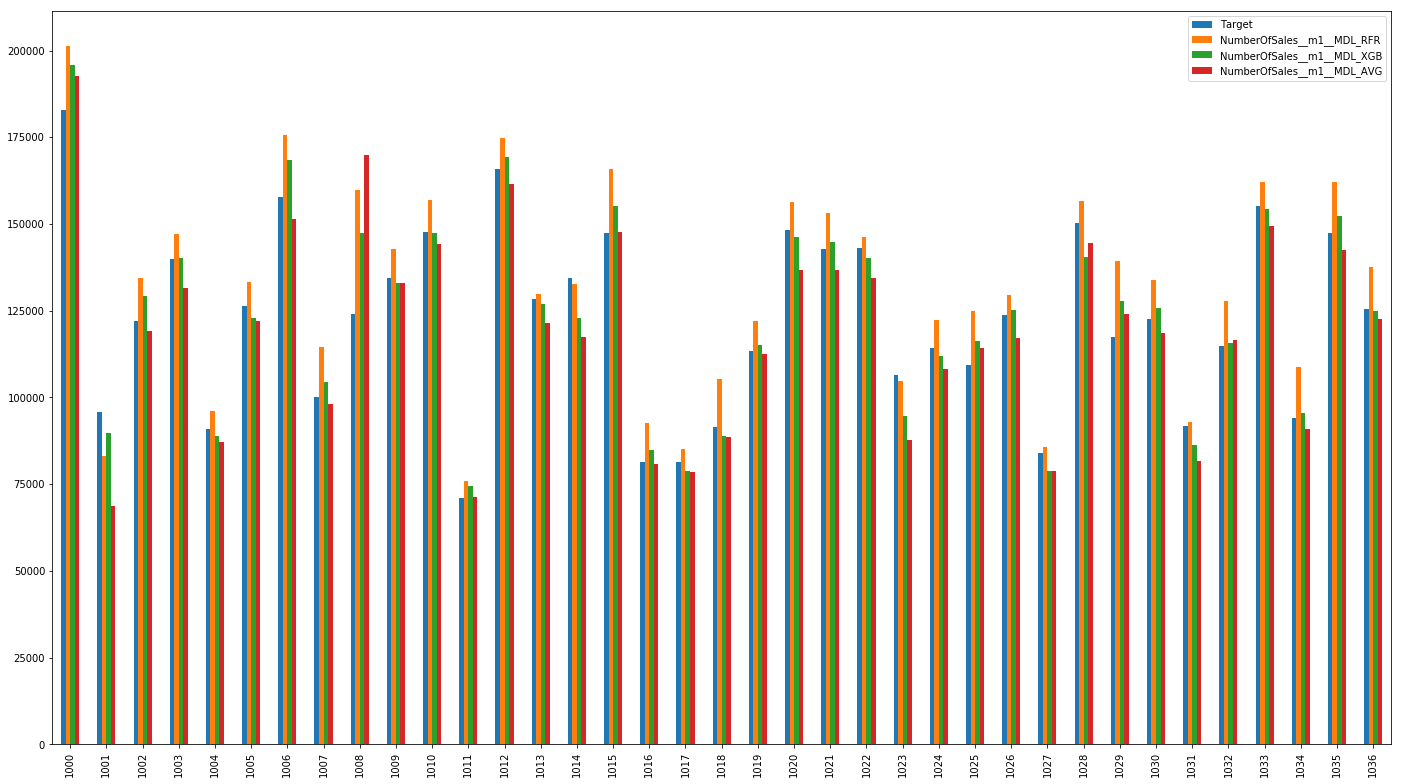

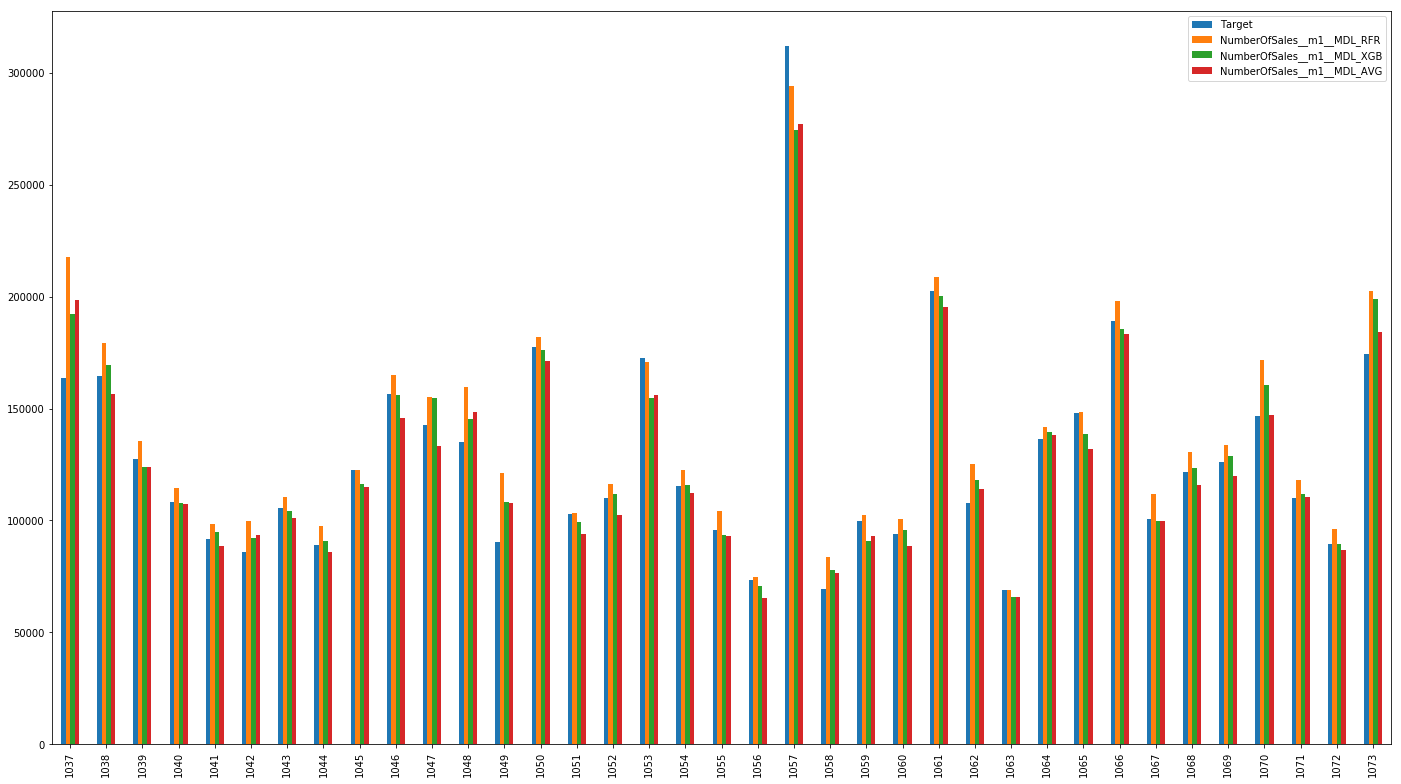

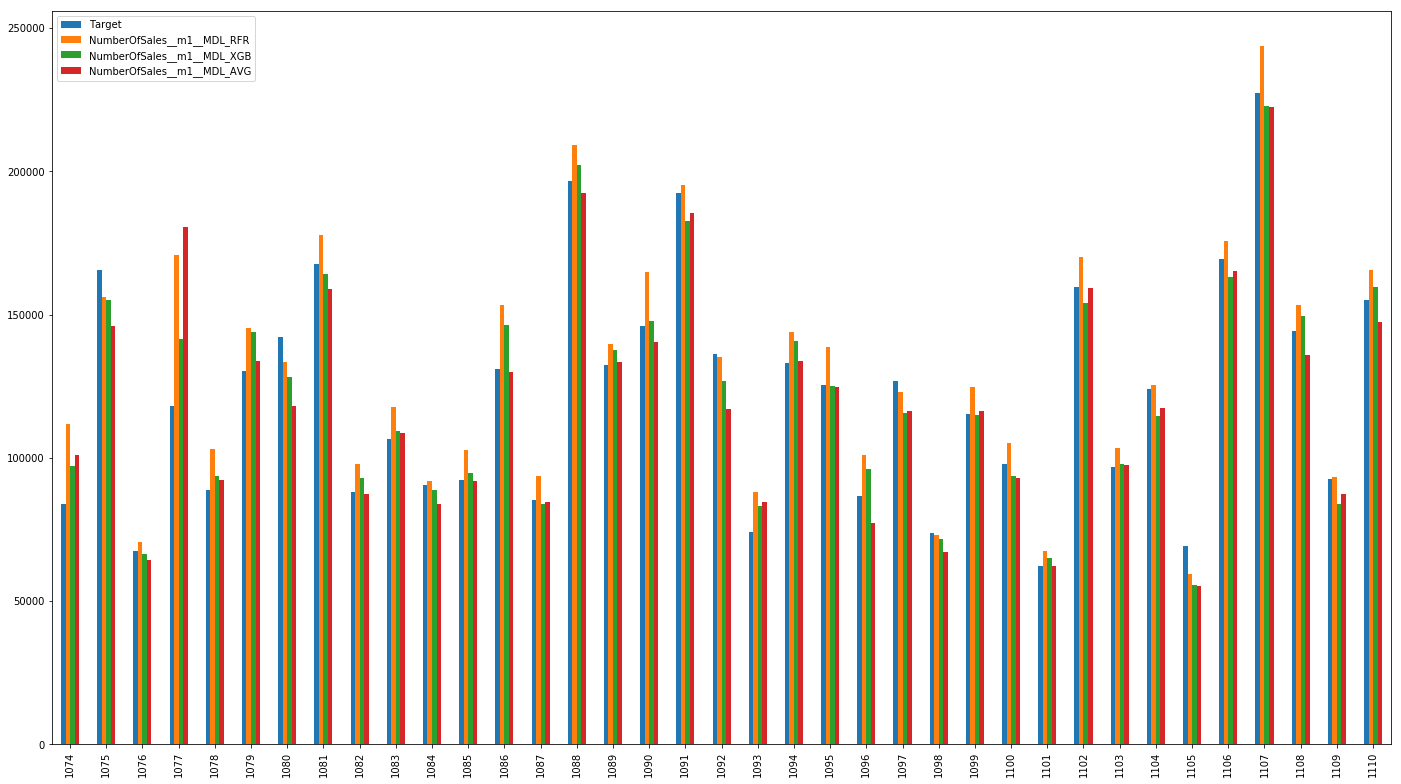

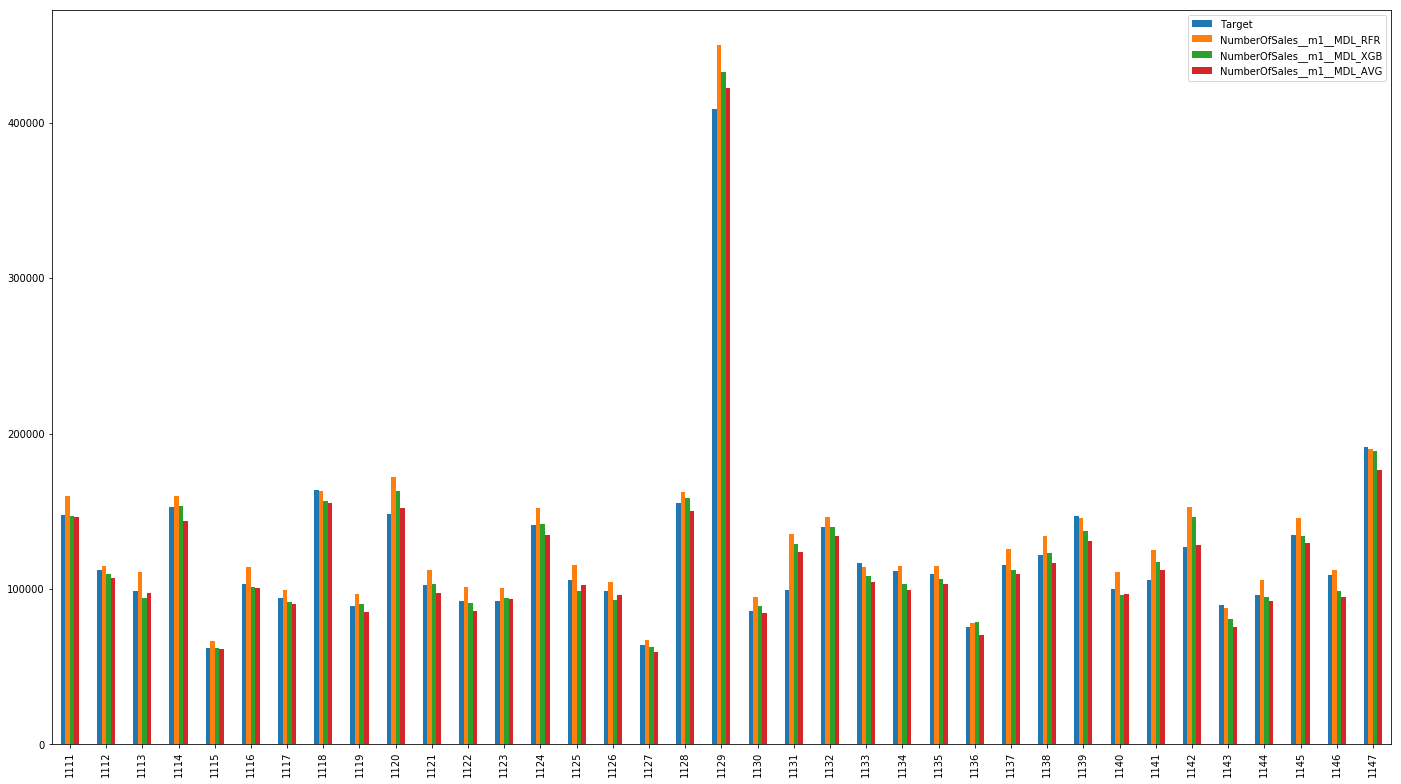

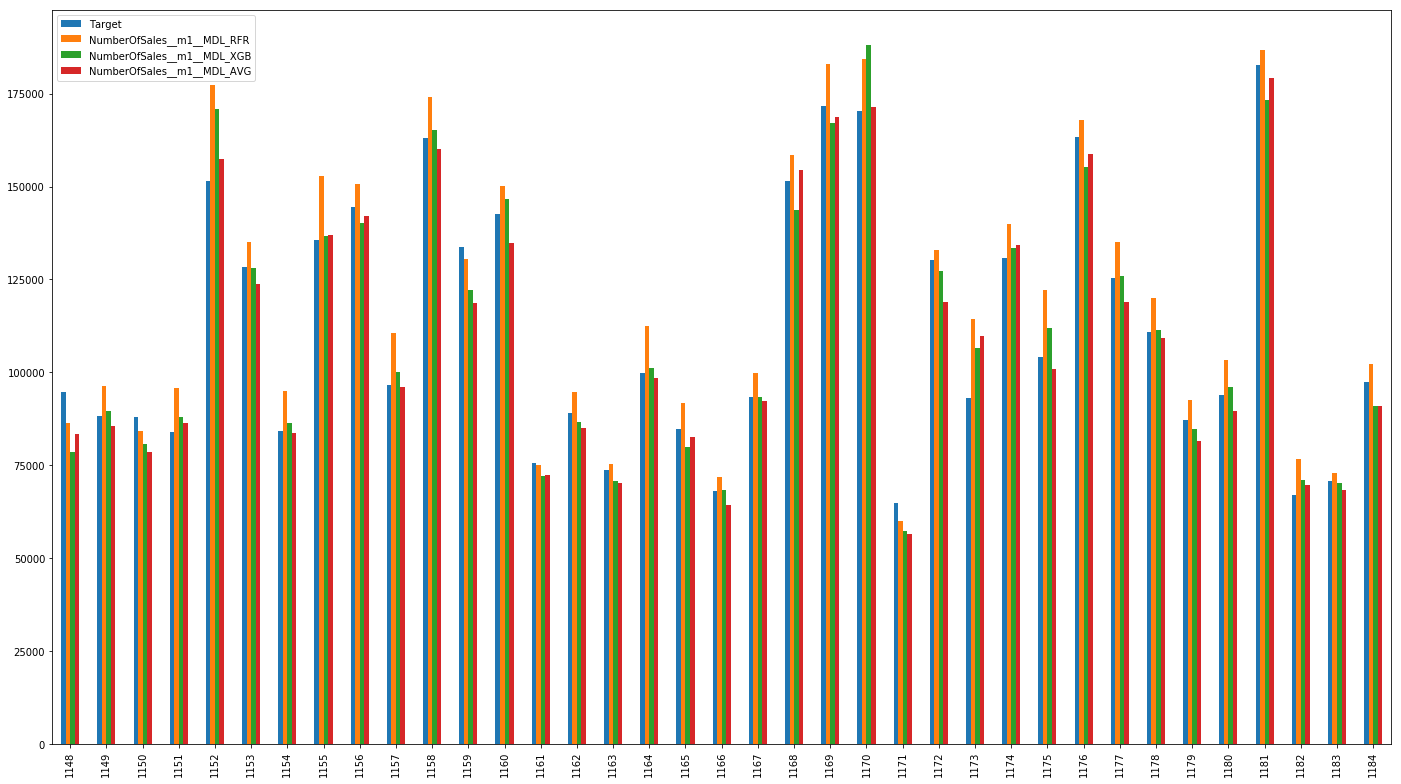

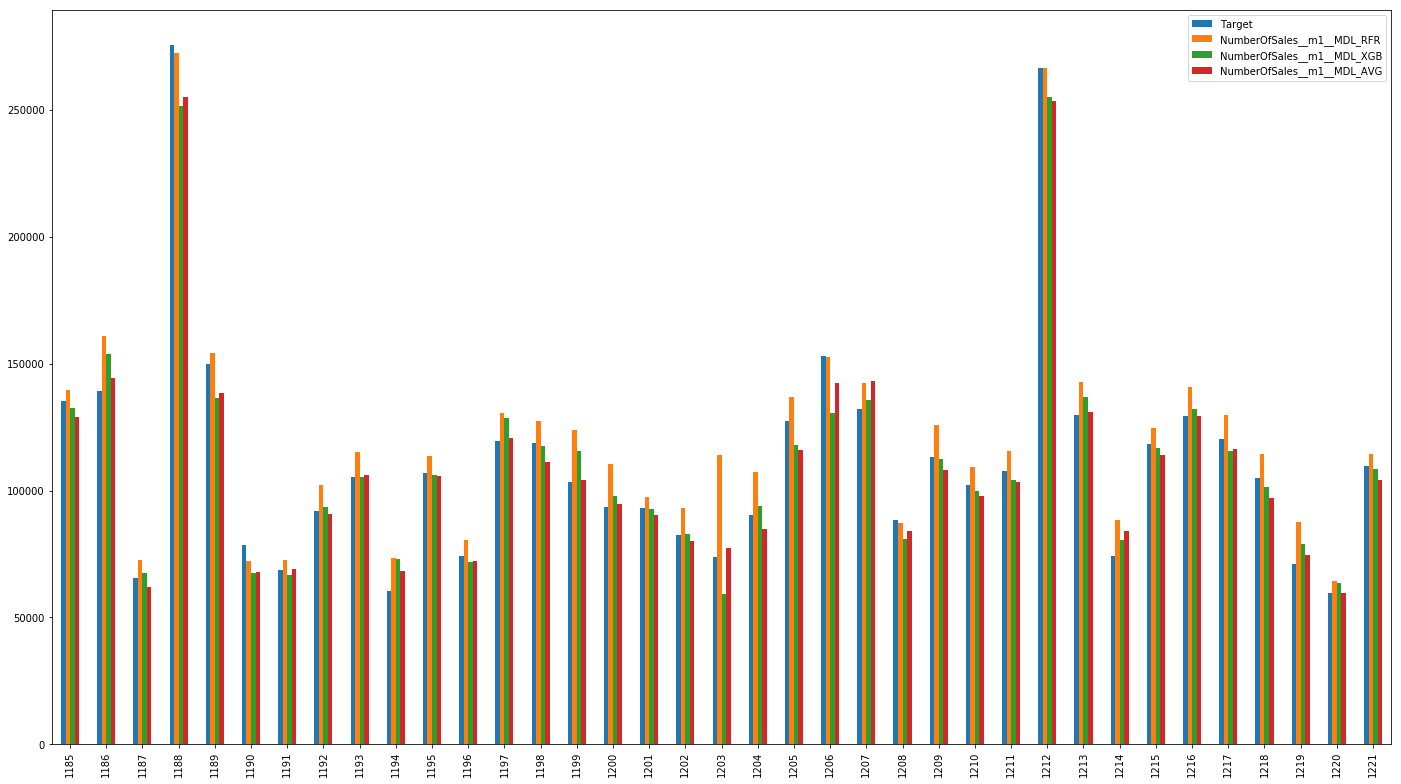

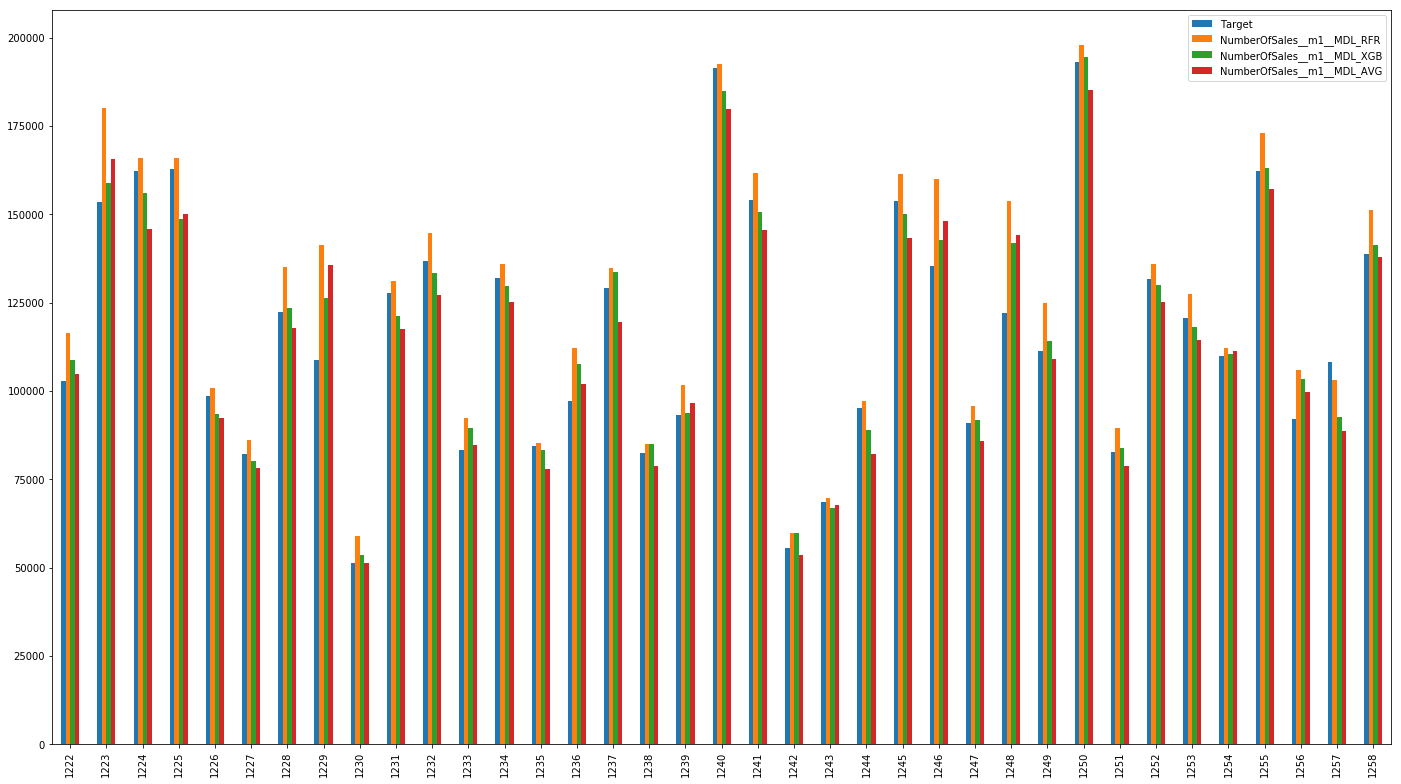

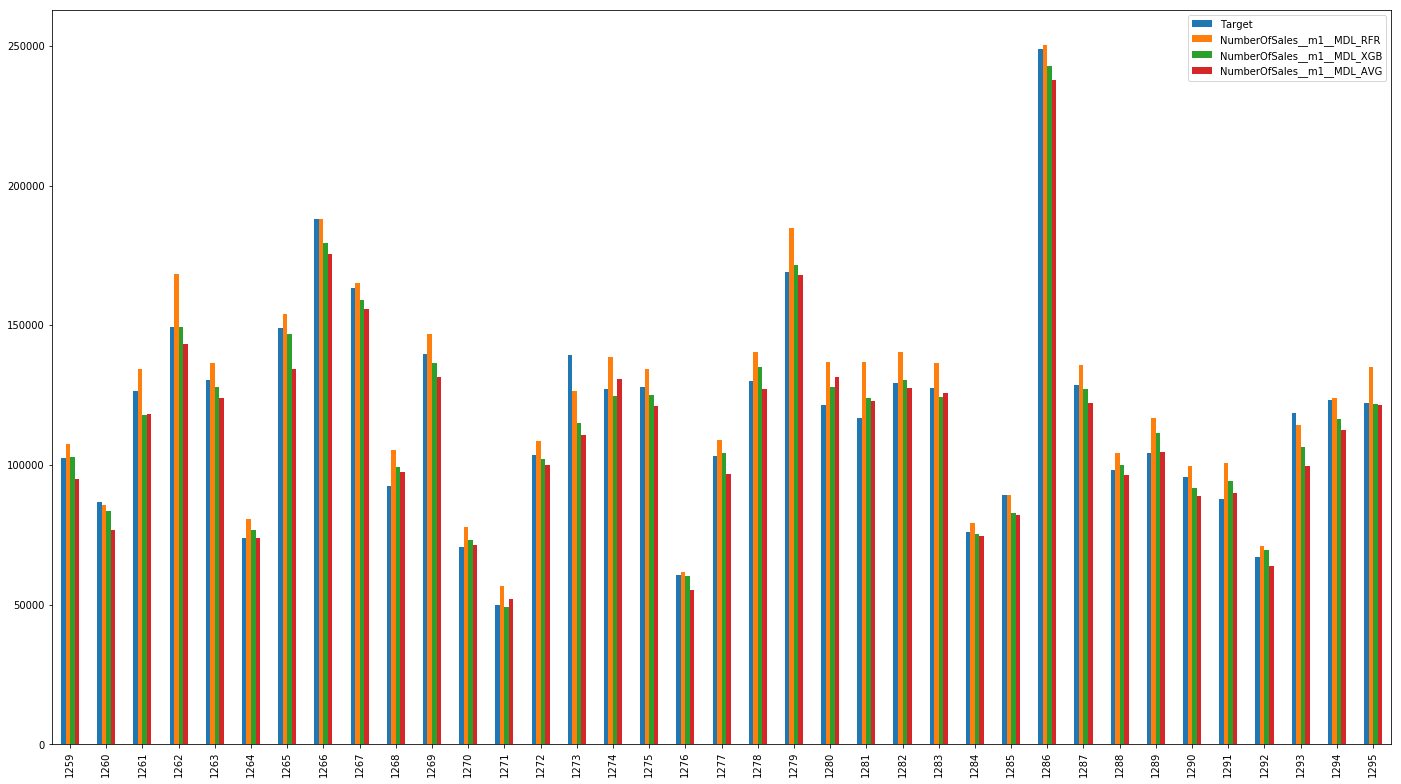

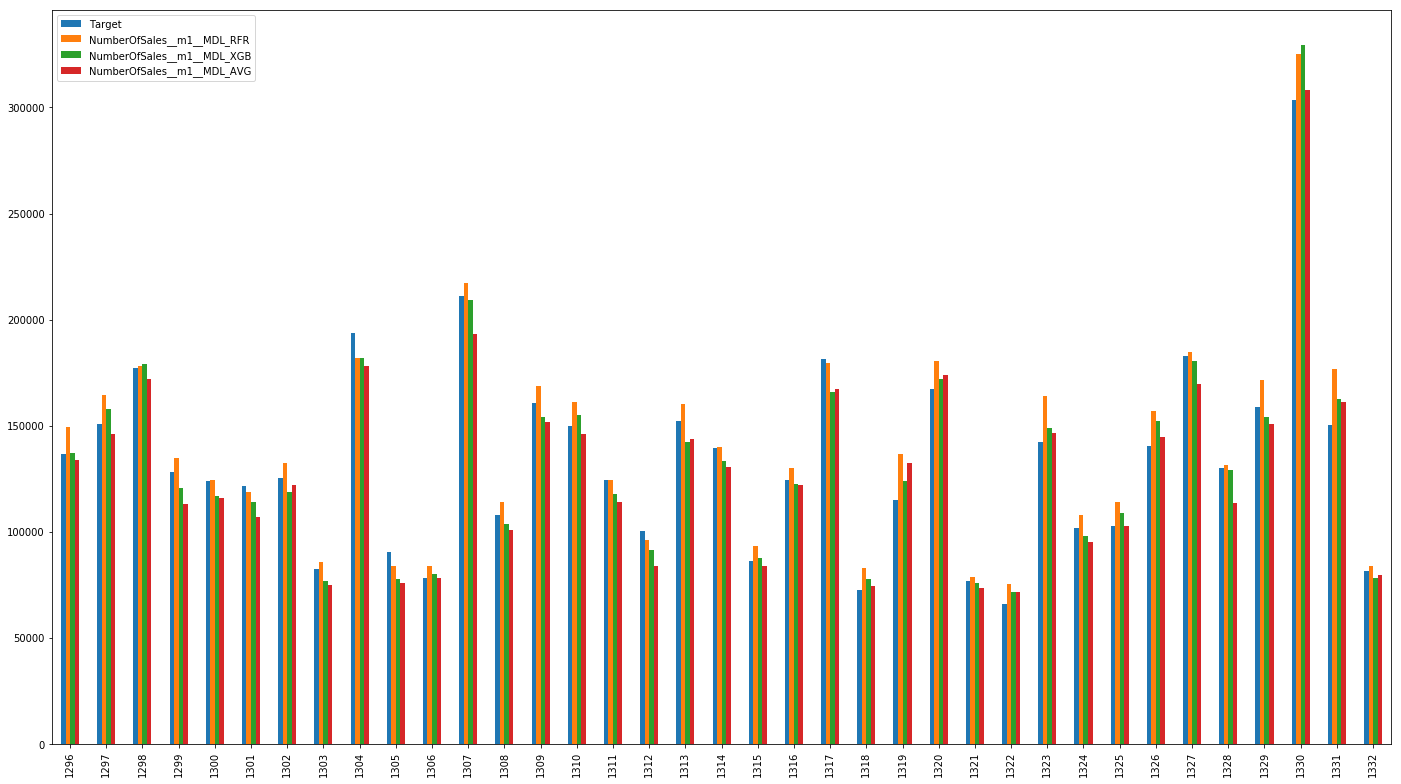

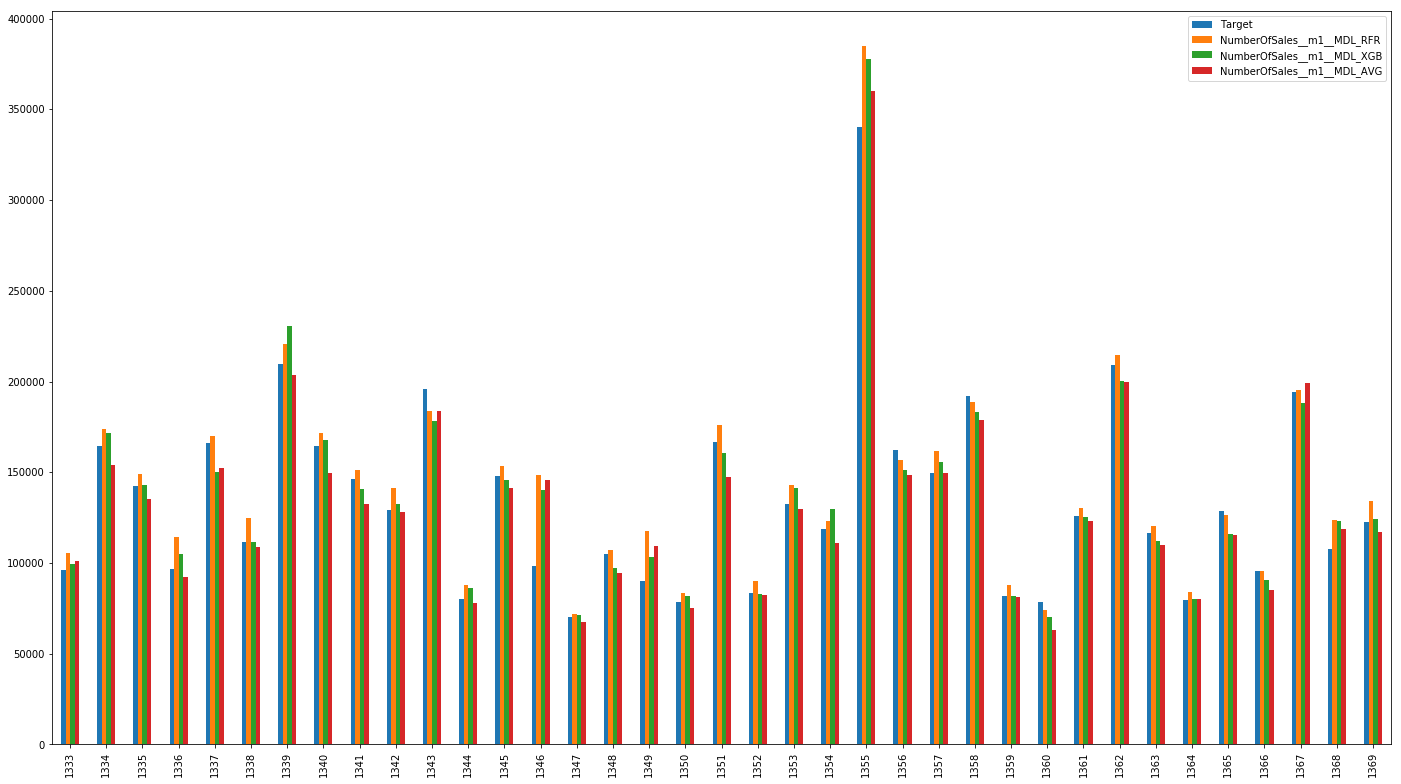

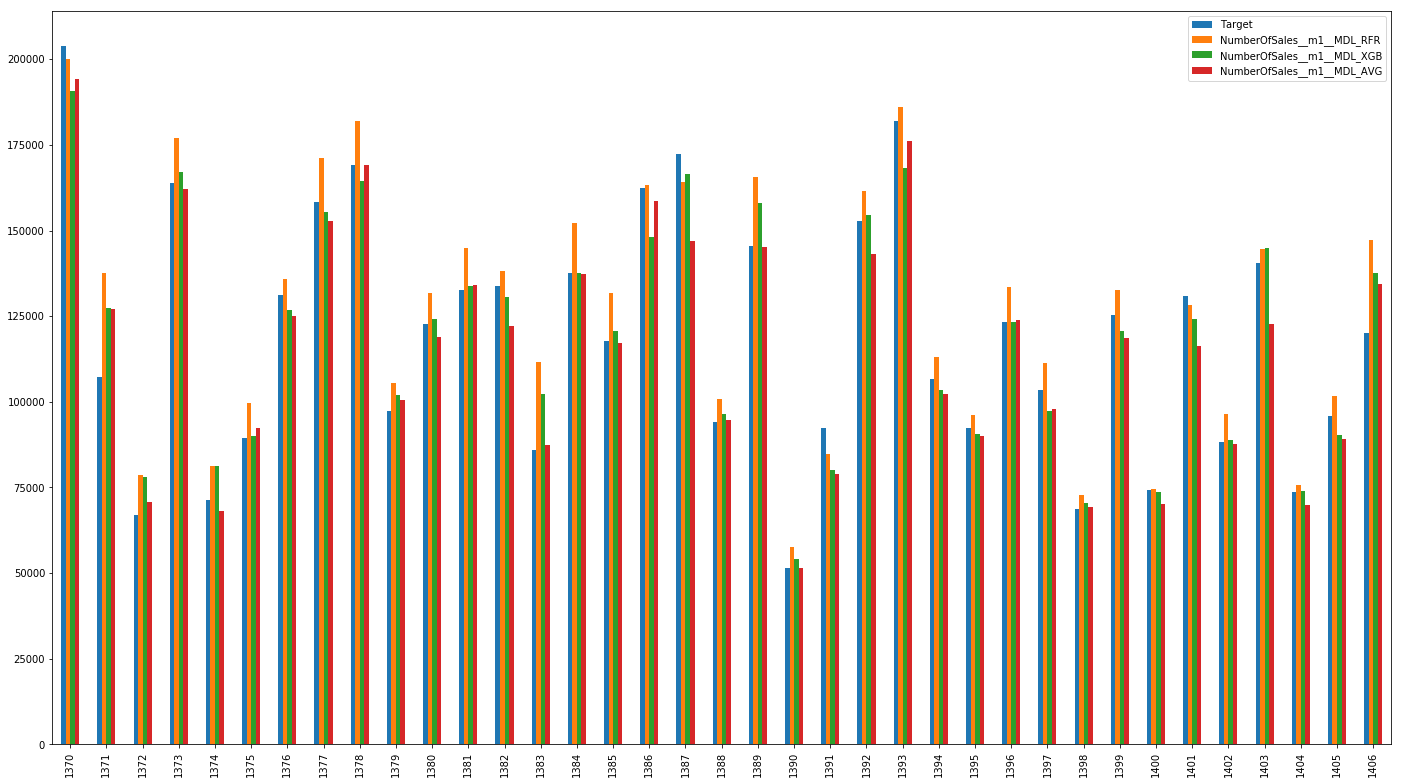

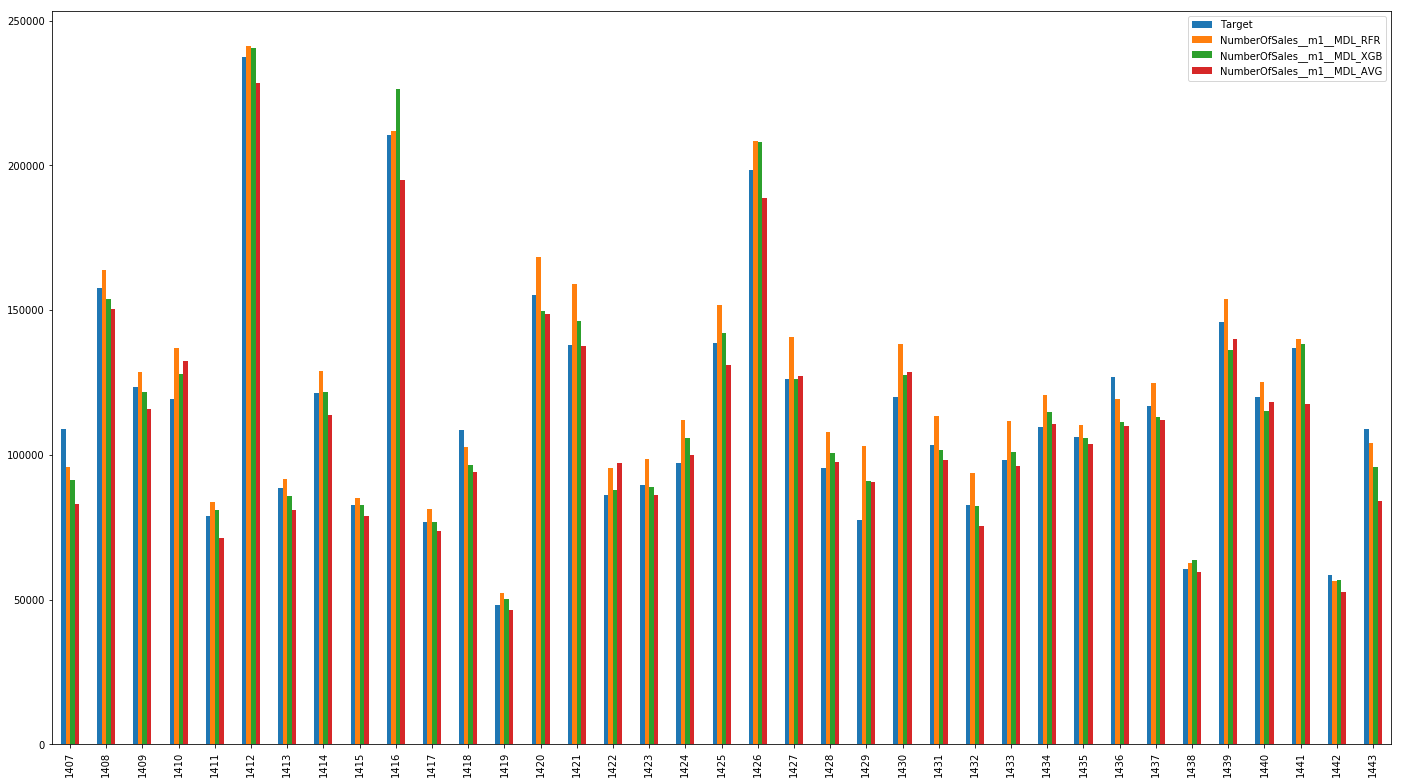

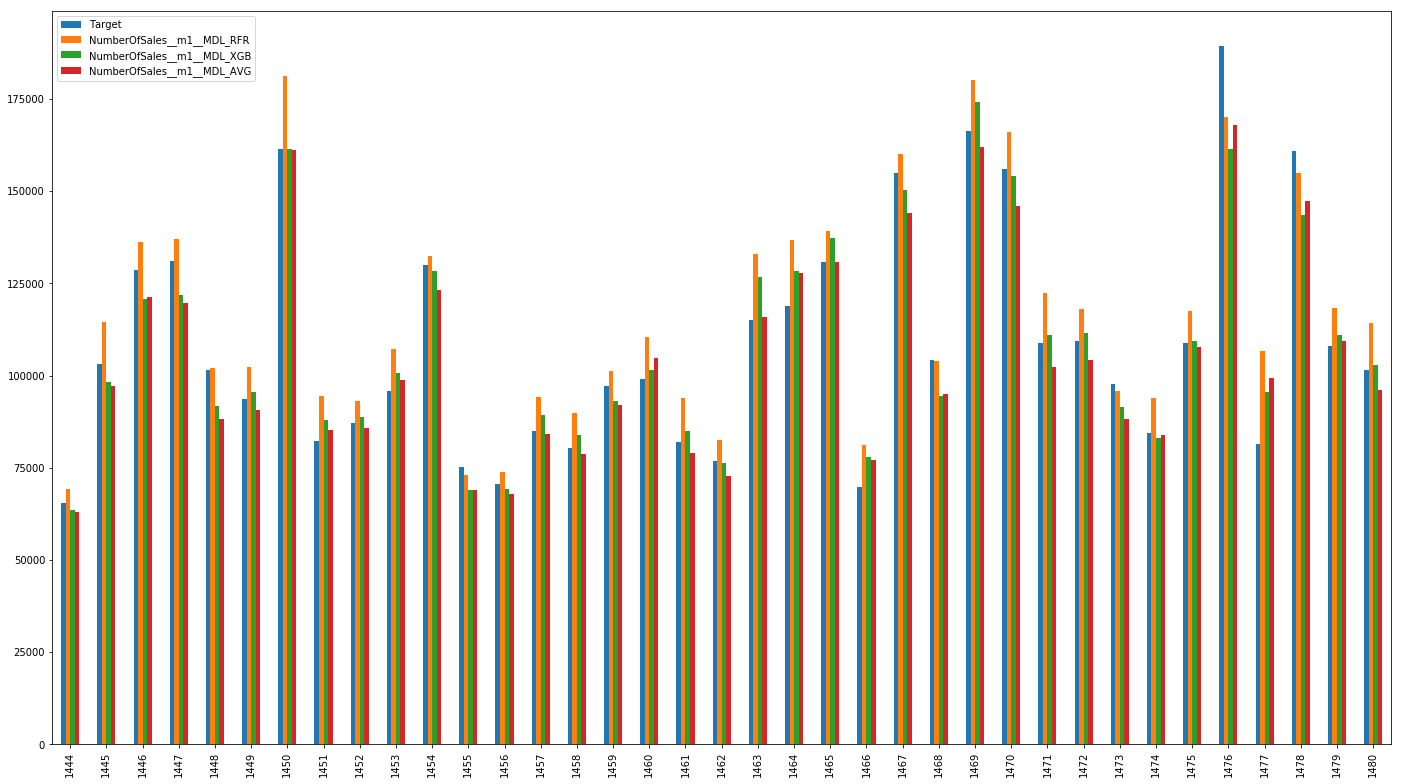

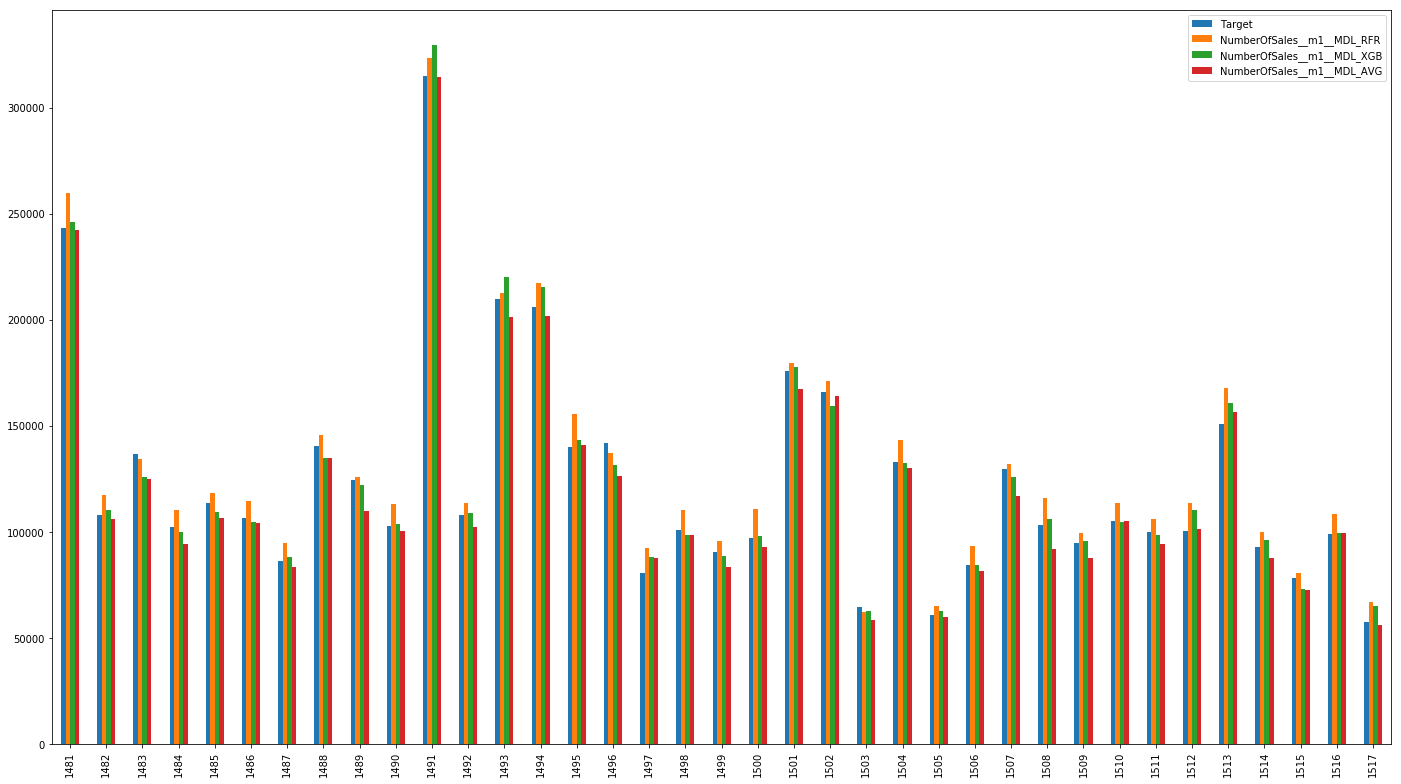

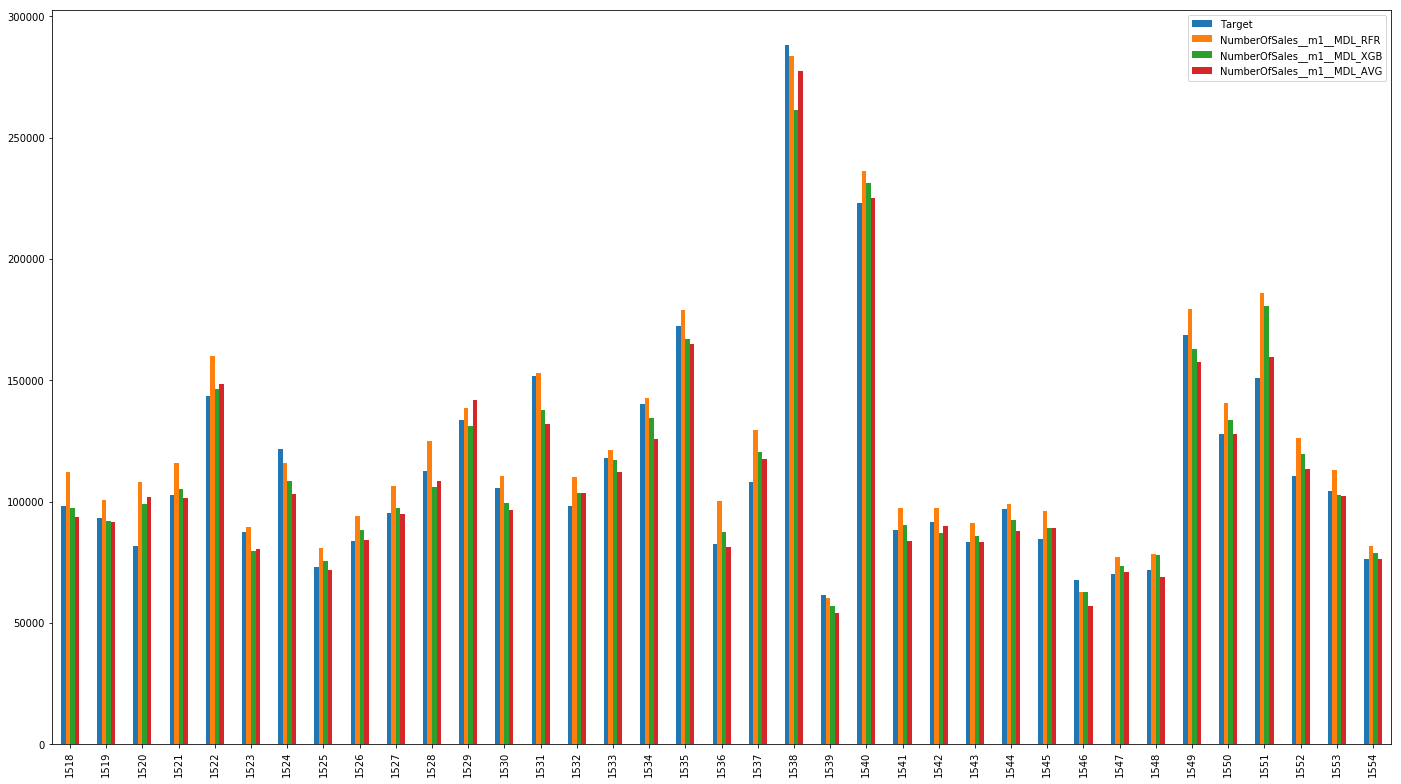

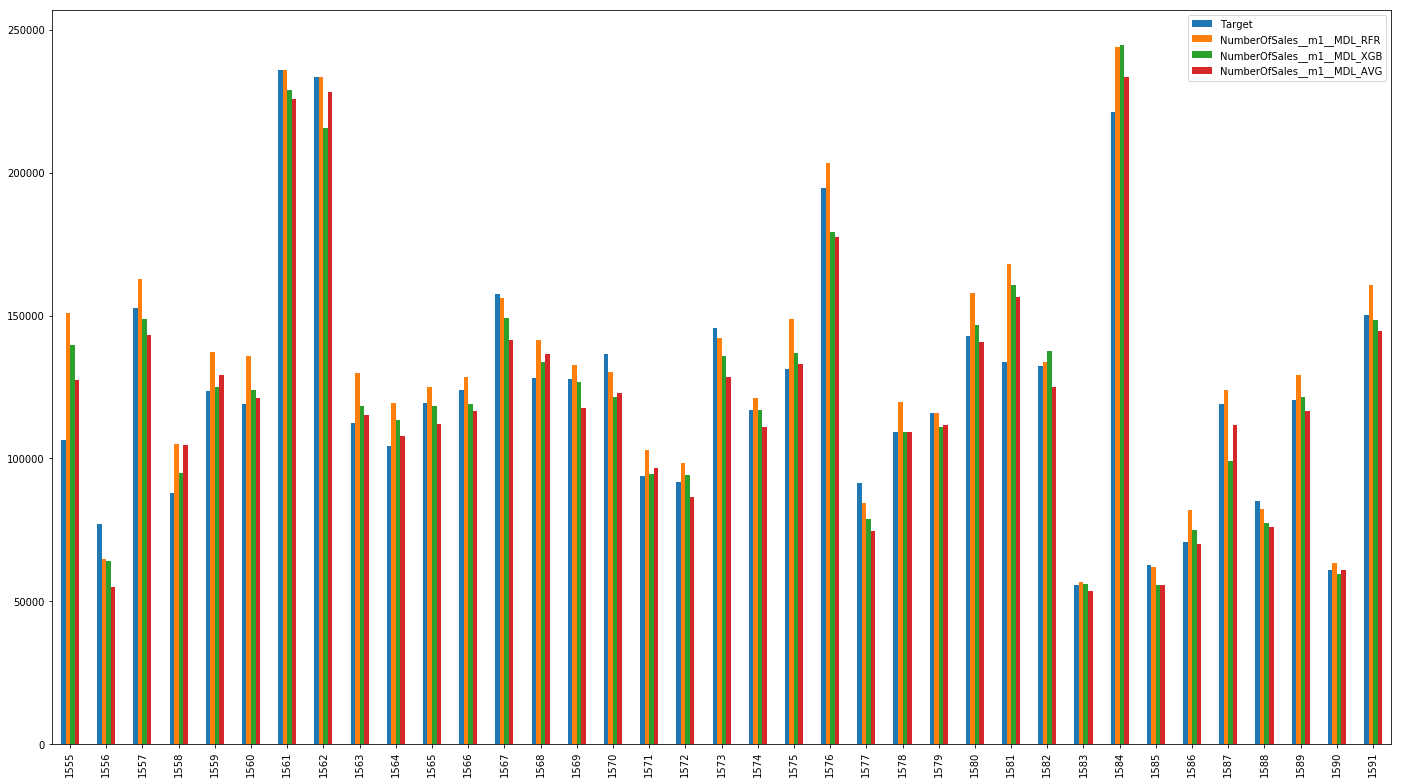

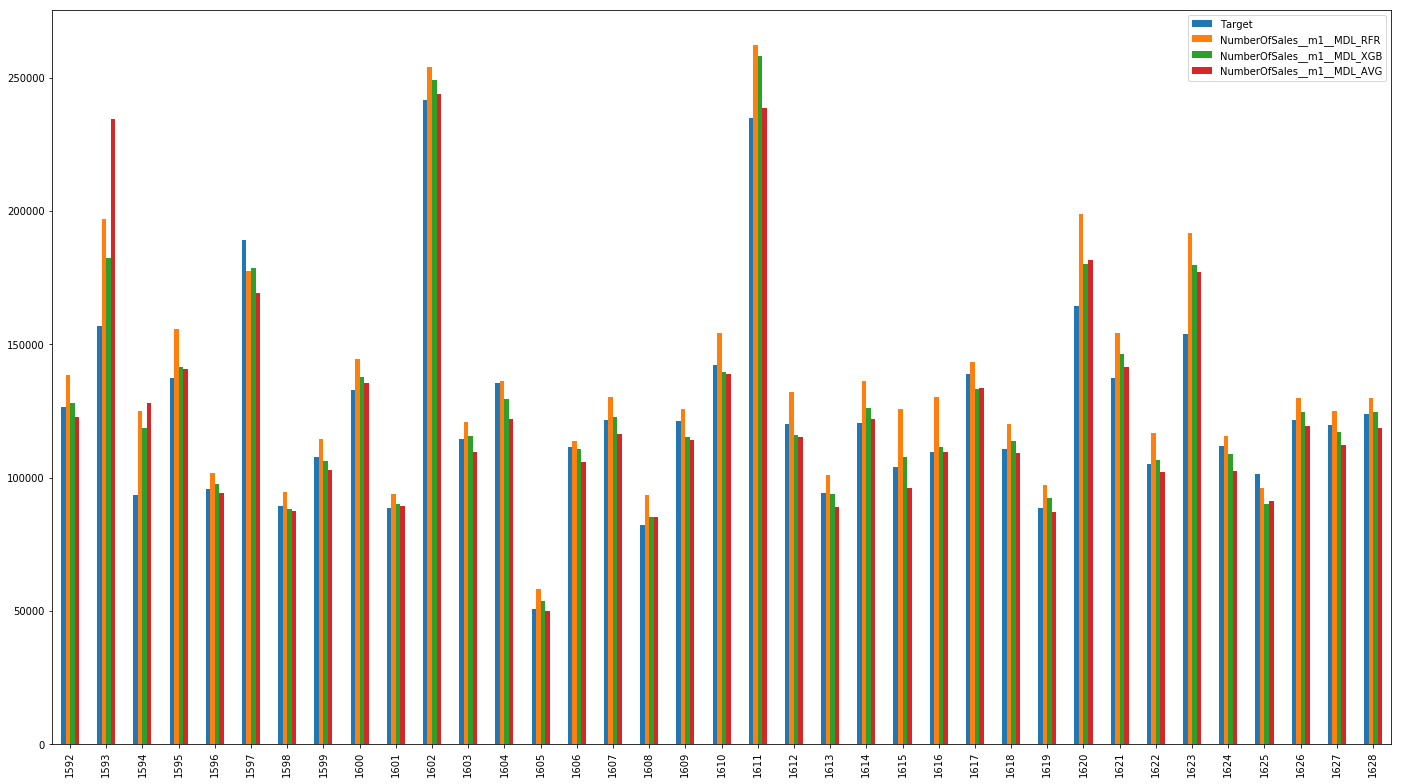

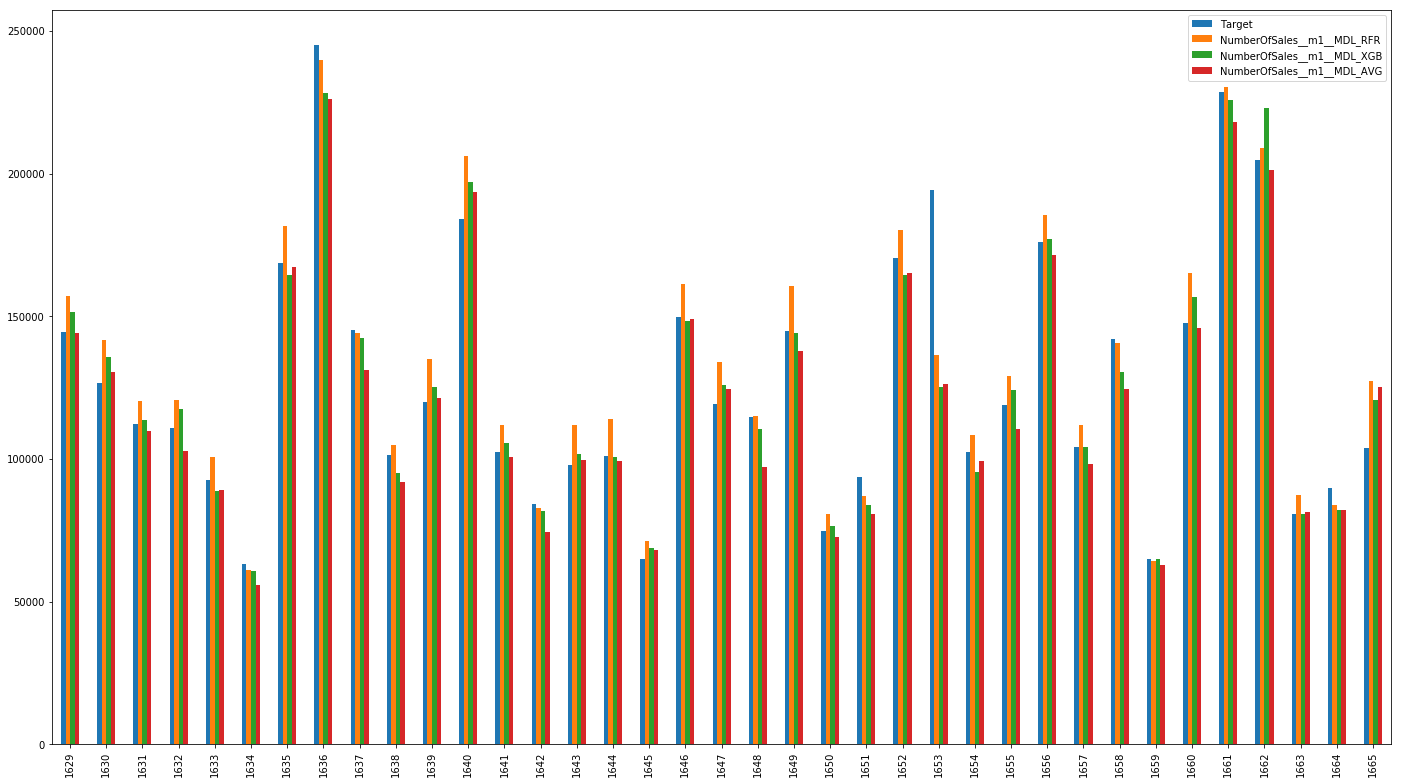

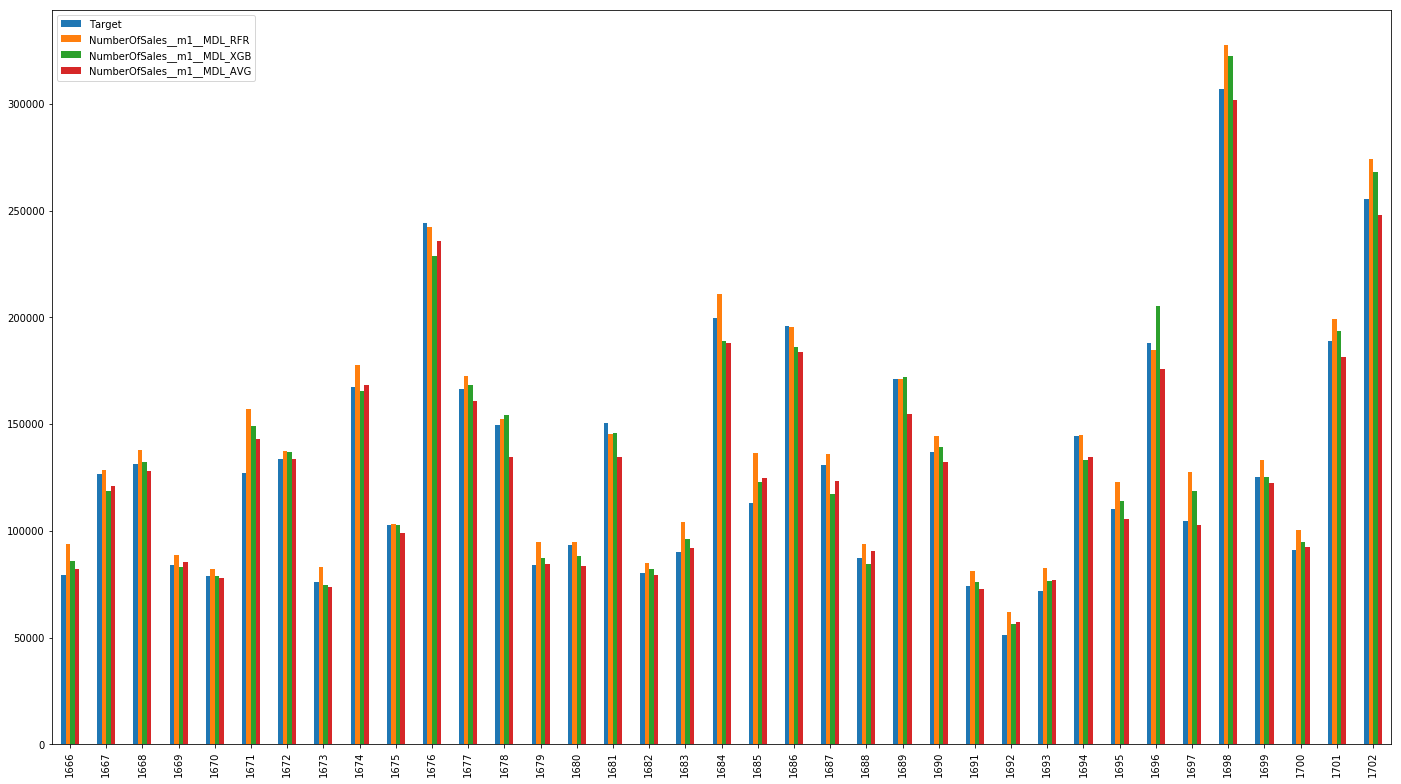

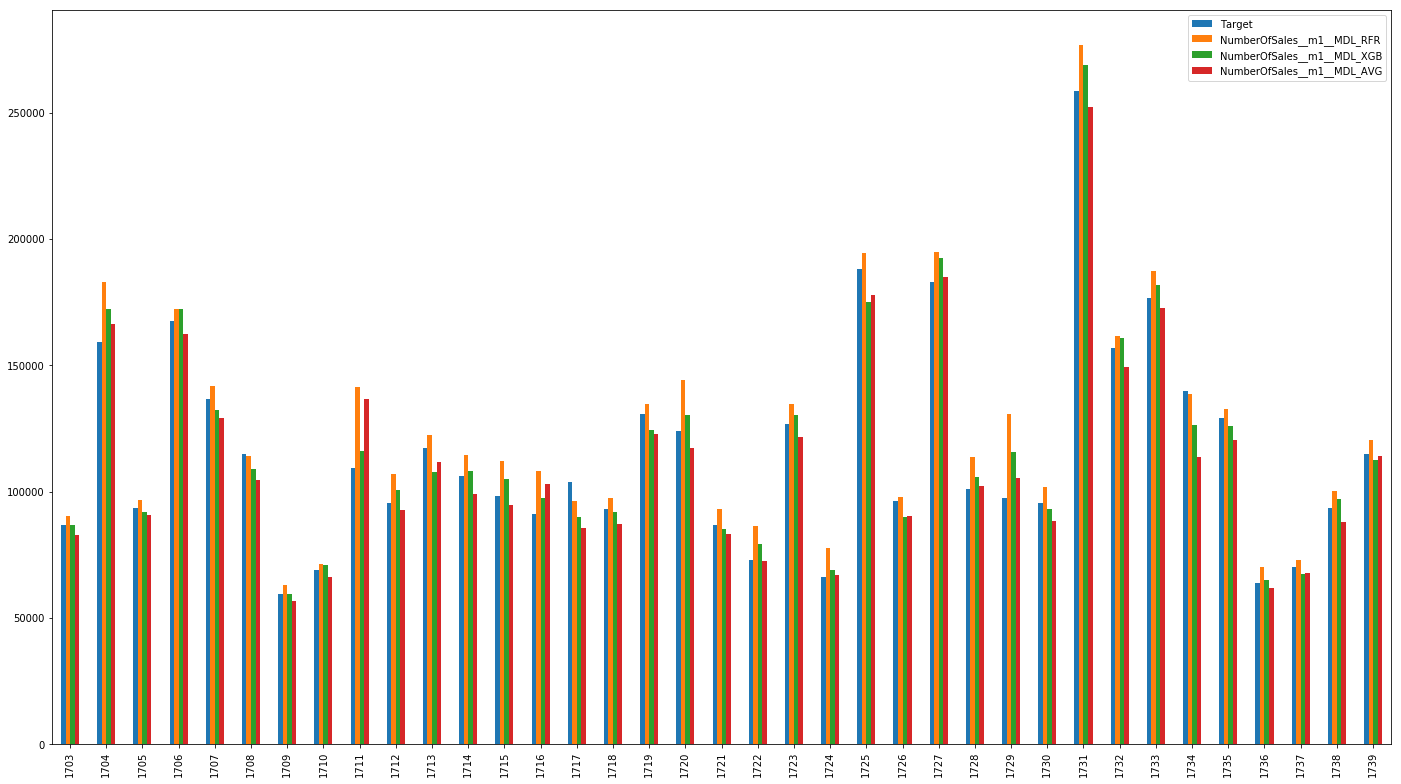

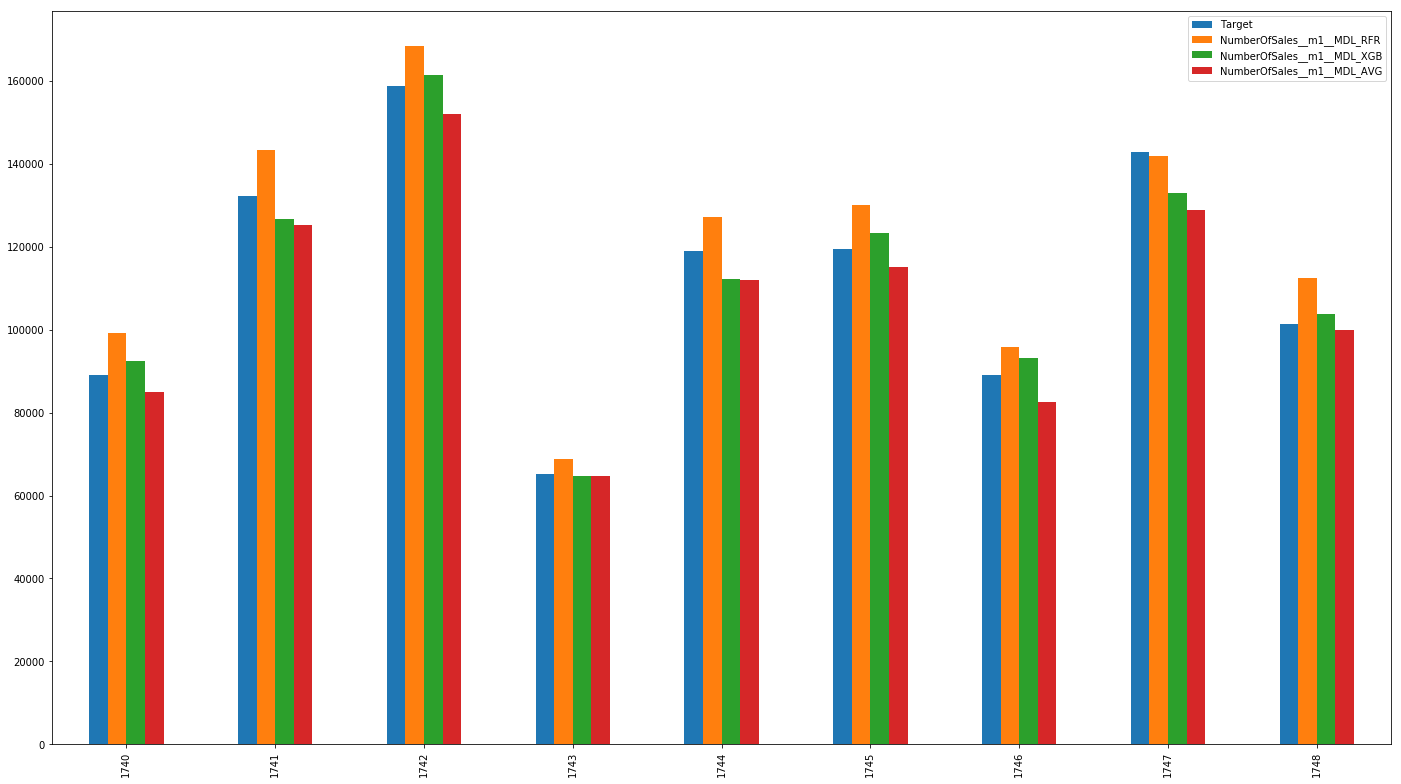

In [12]:
plot_comparison_bar_plots(df_plots, month=0)  # to print them all
#plot_comparison_bar_plots(df_plots, month=0, first=10, last=11) # just print one

### SECOND MONTH: Comparison bar plots of models' predictions

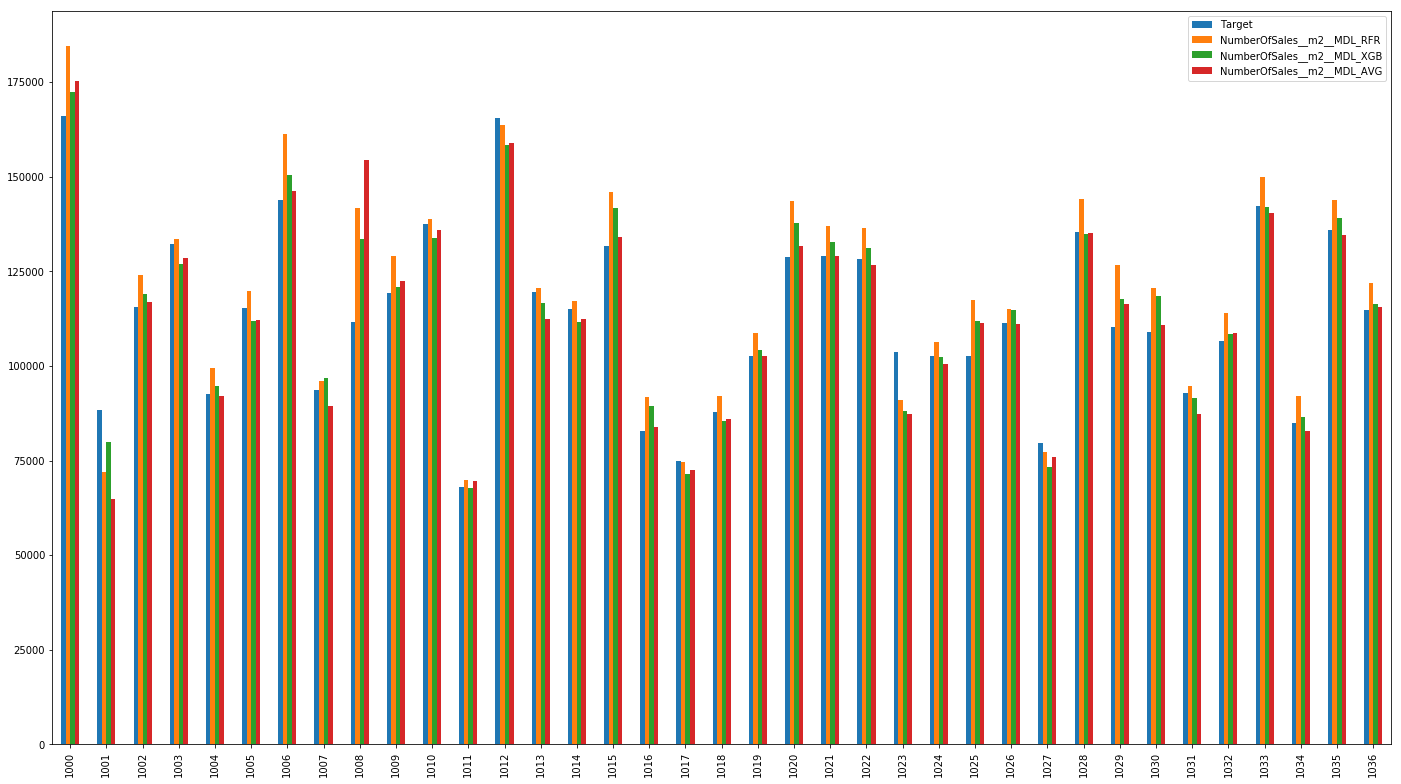

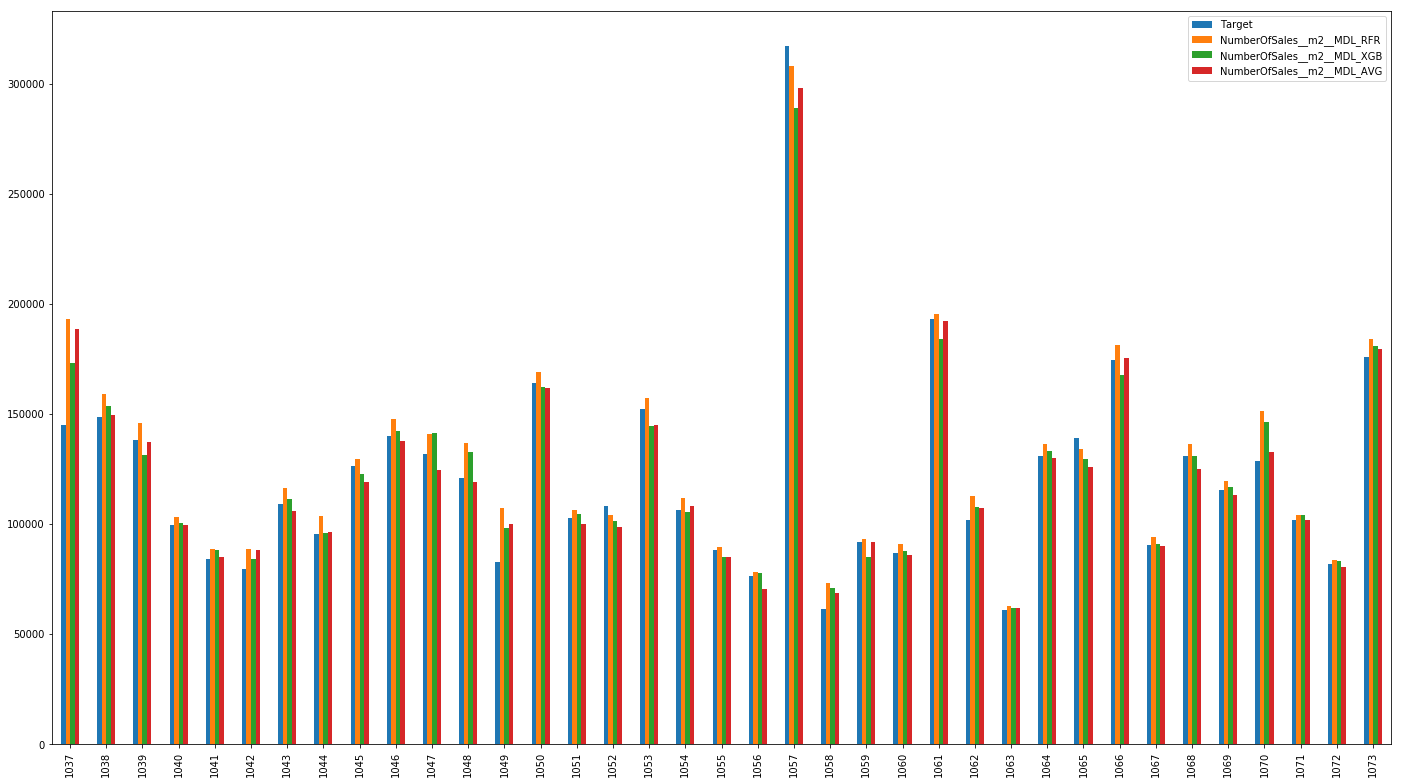

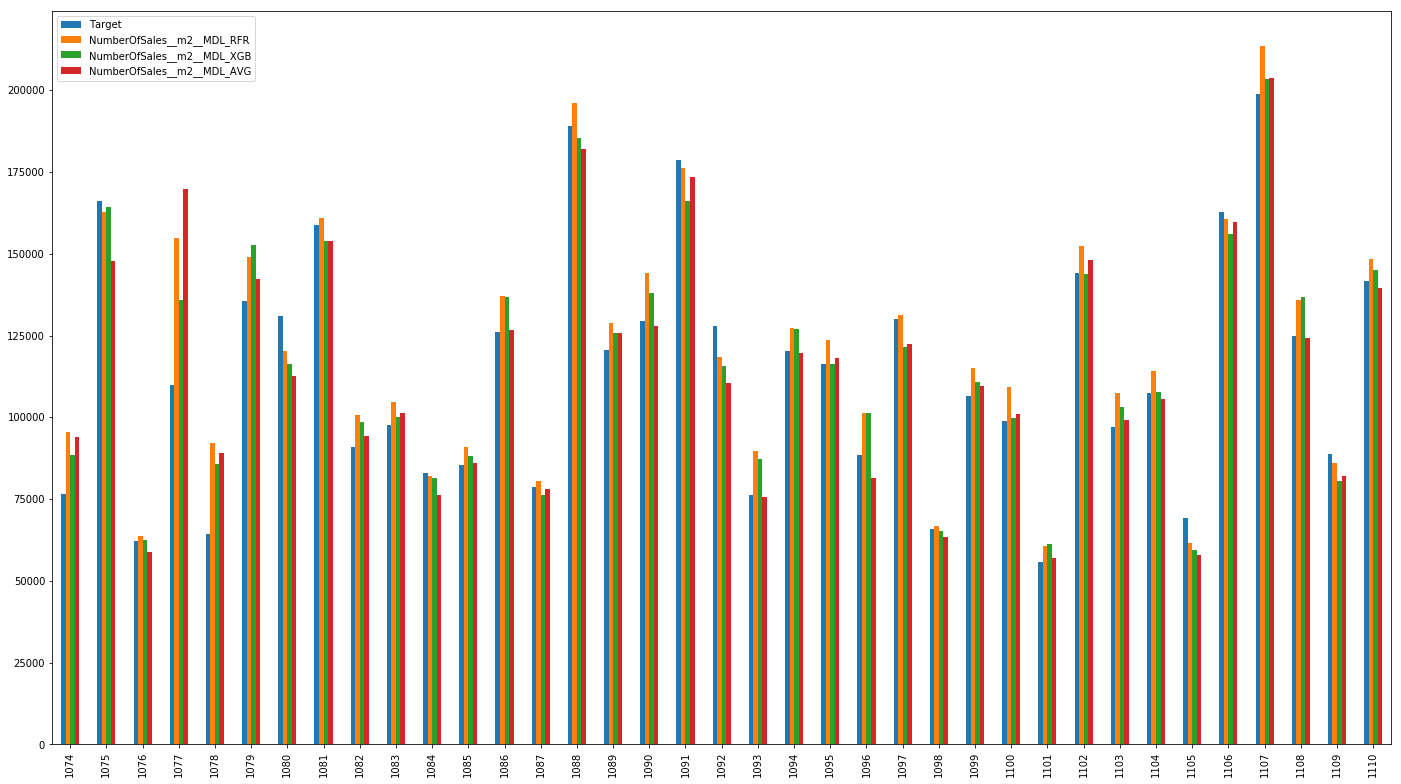

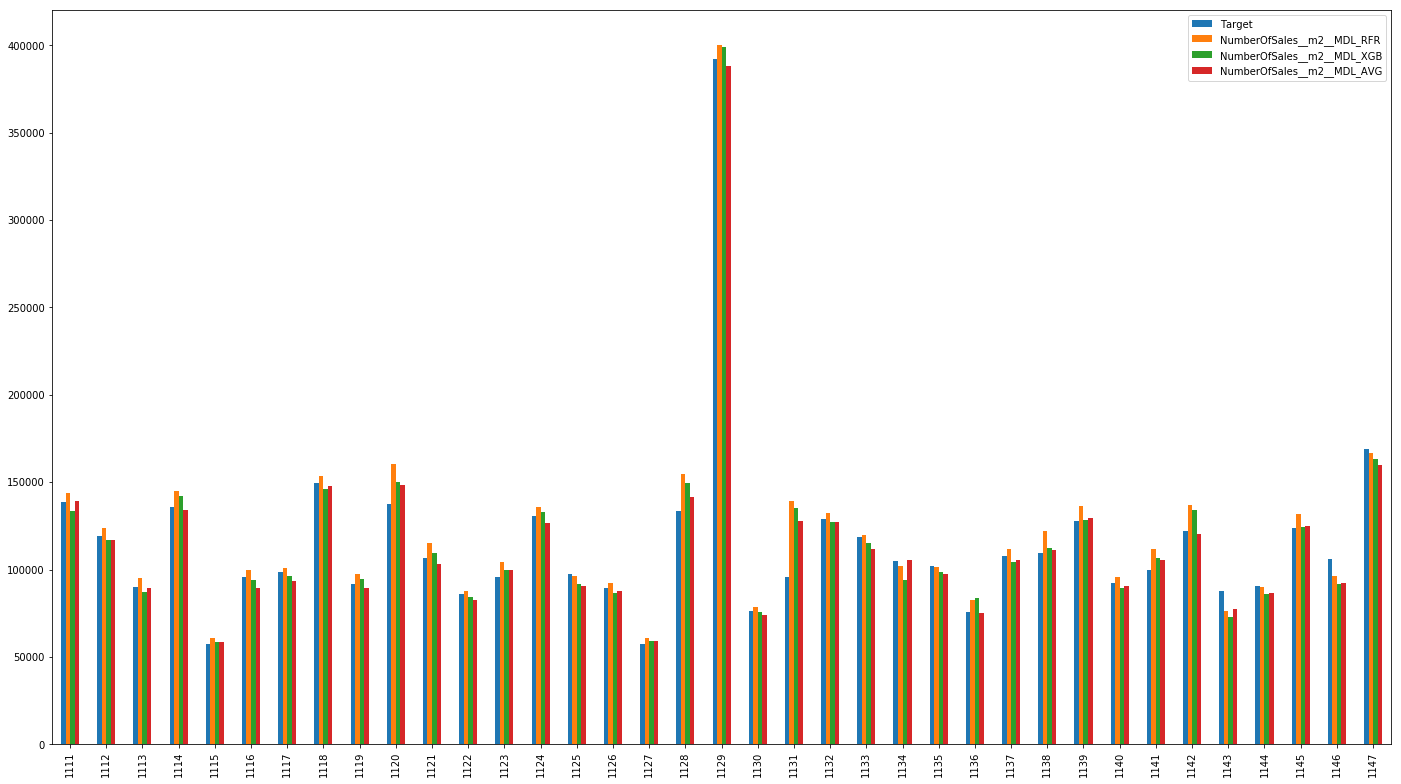

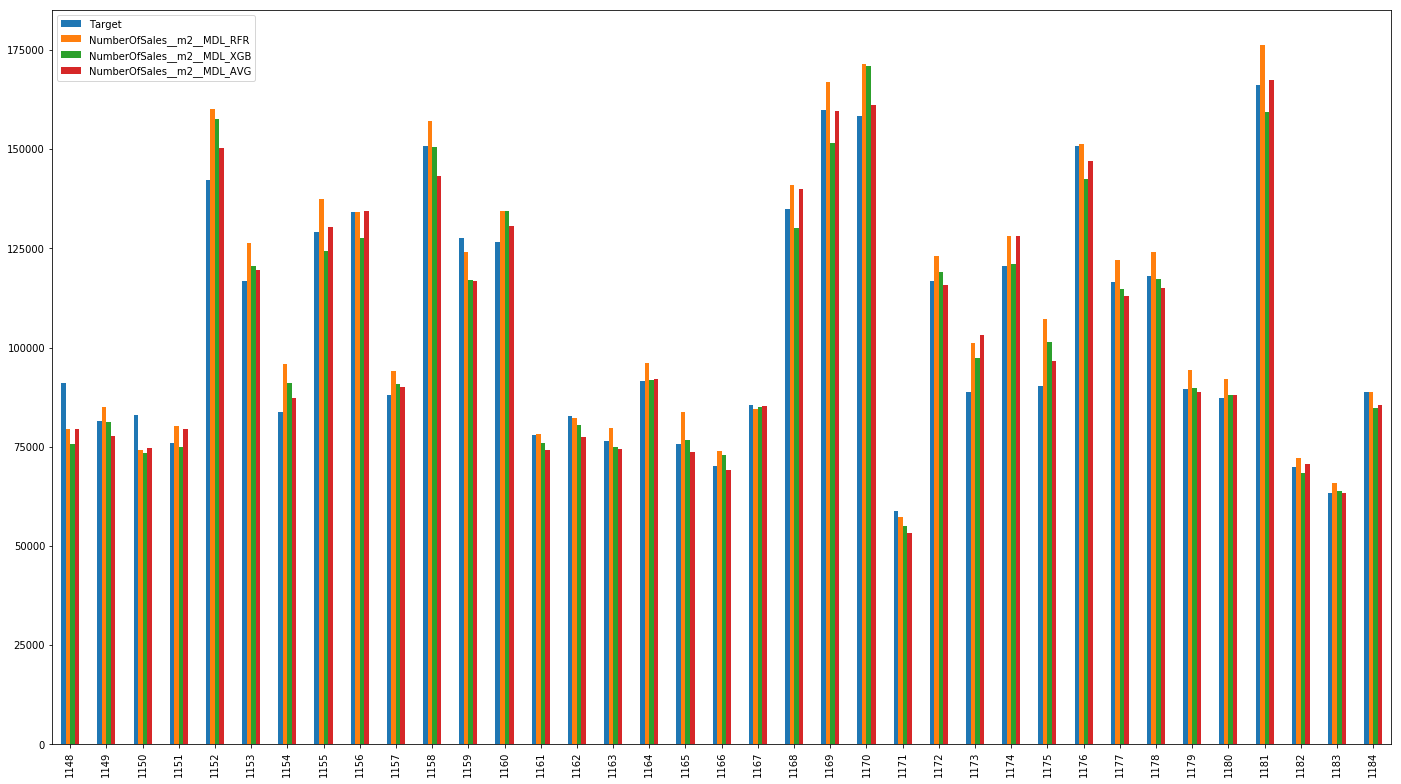

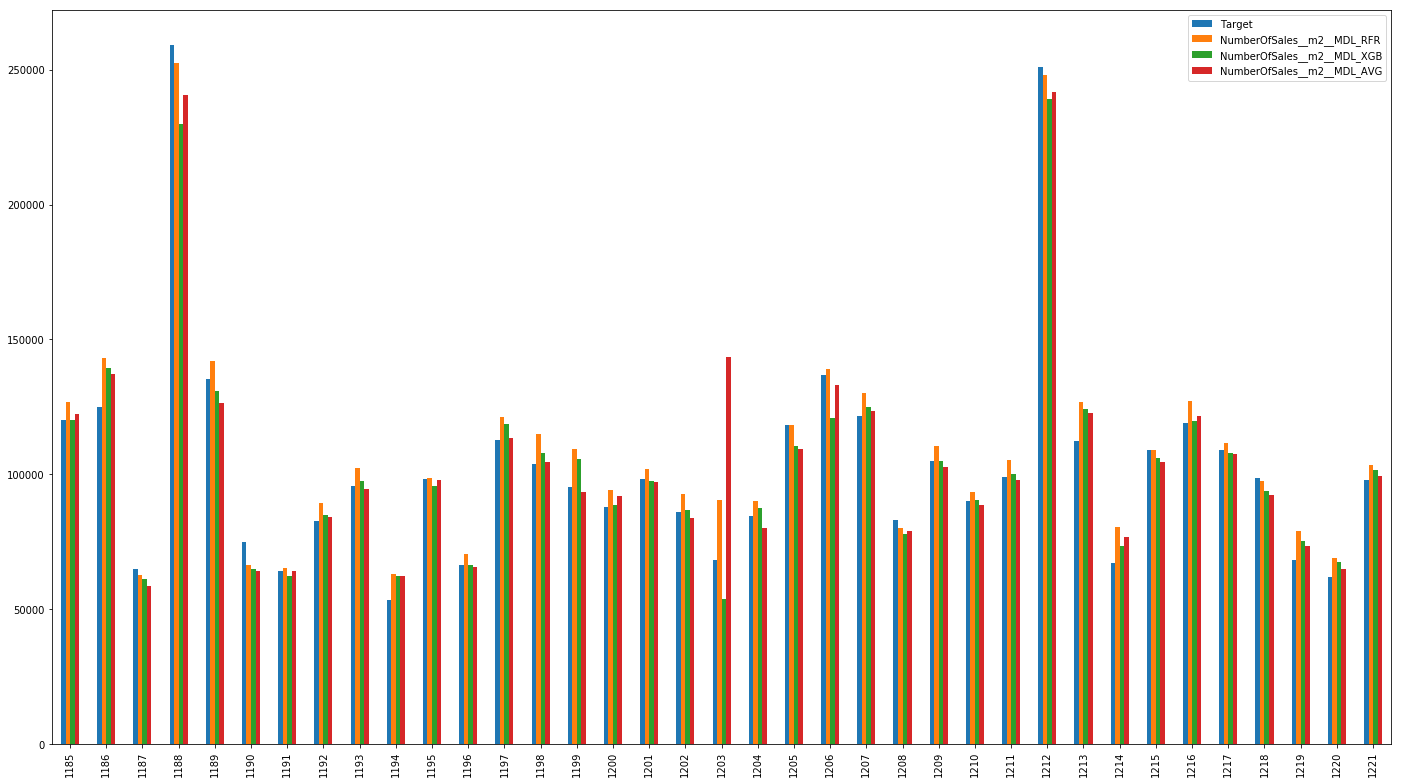

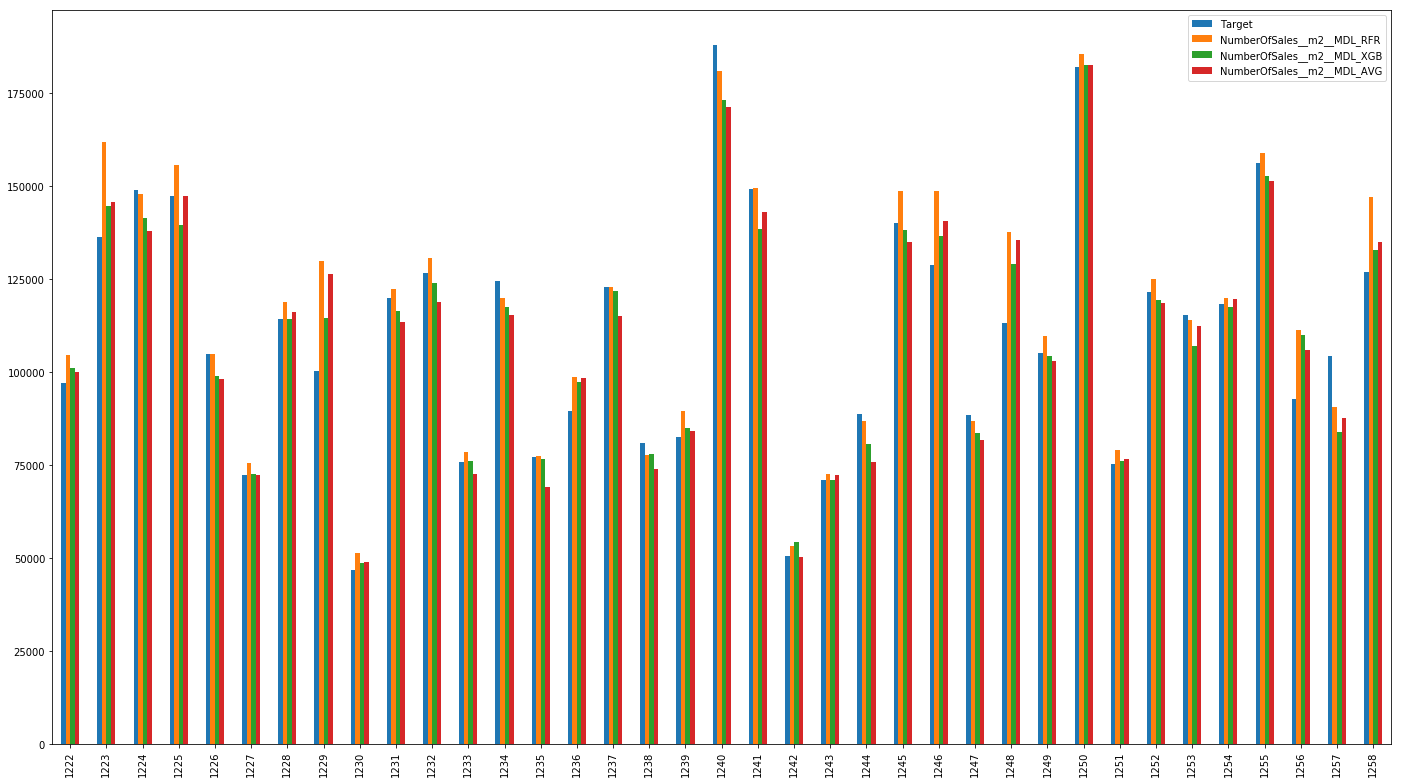

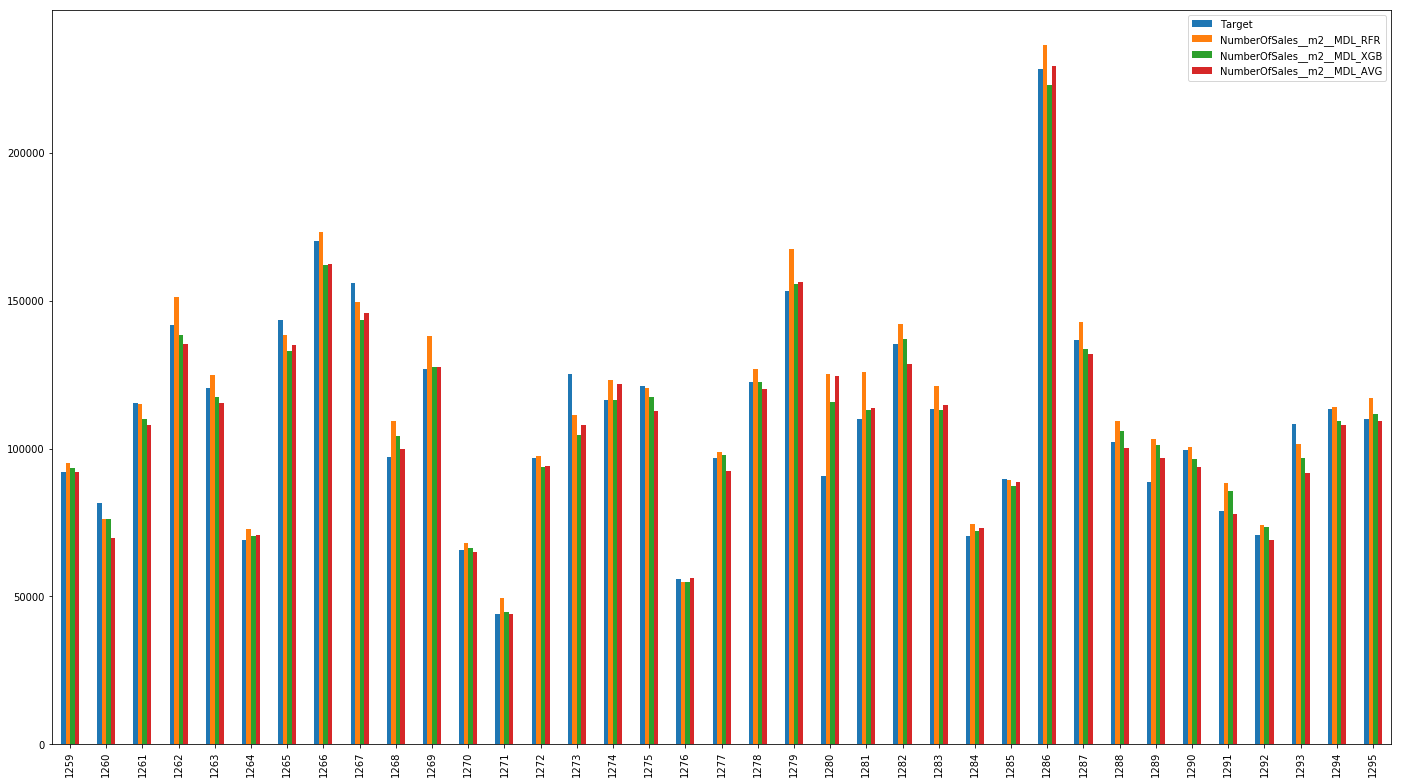

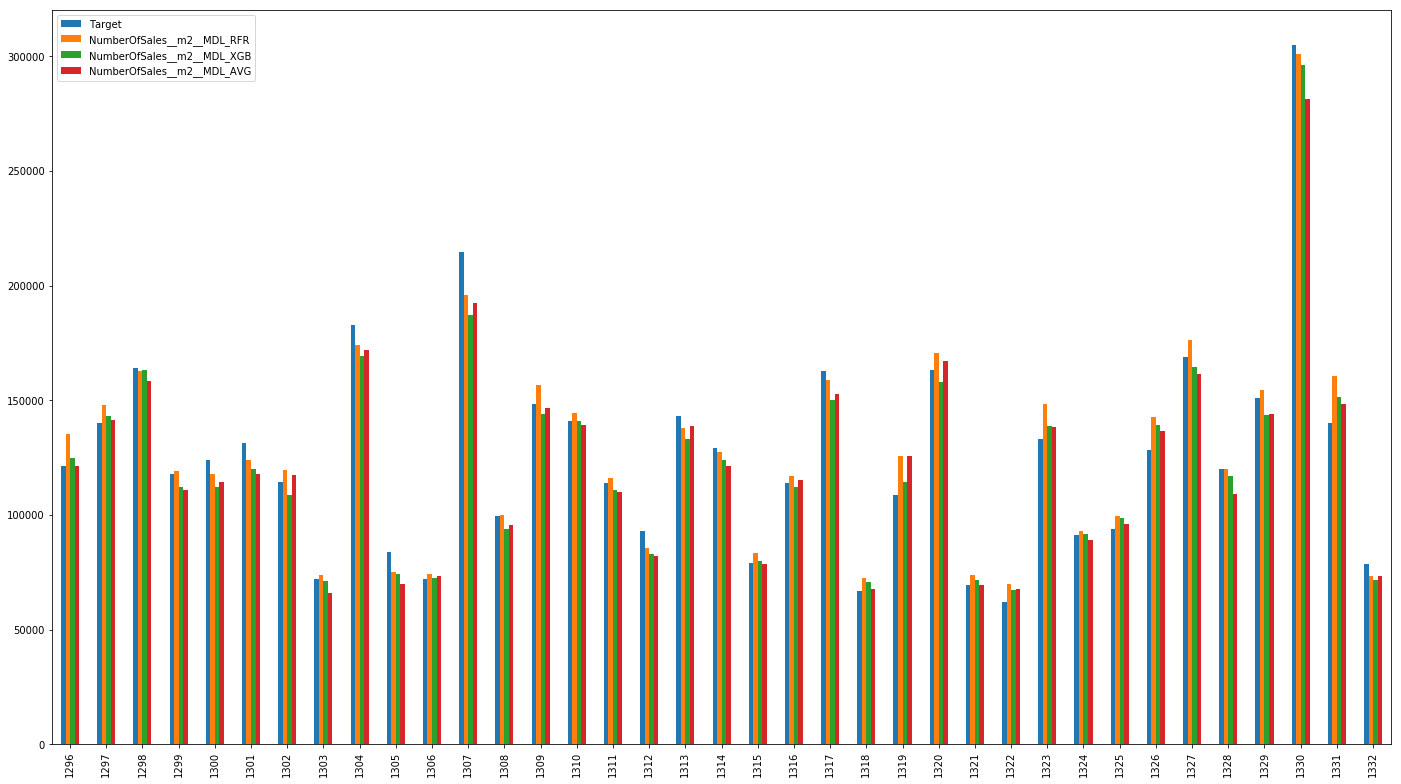

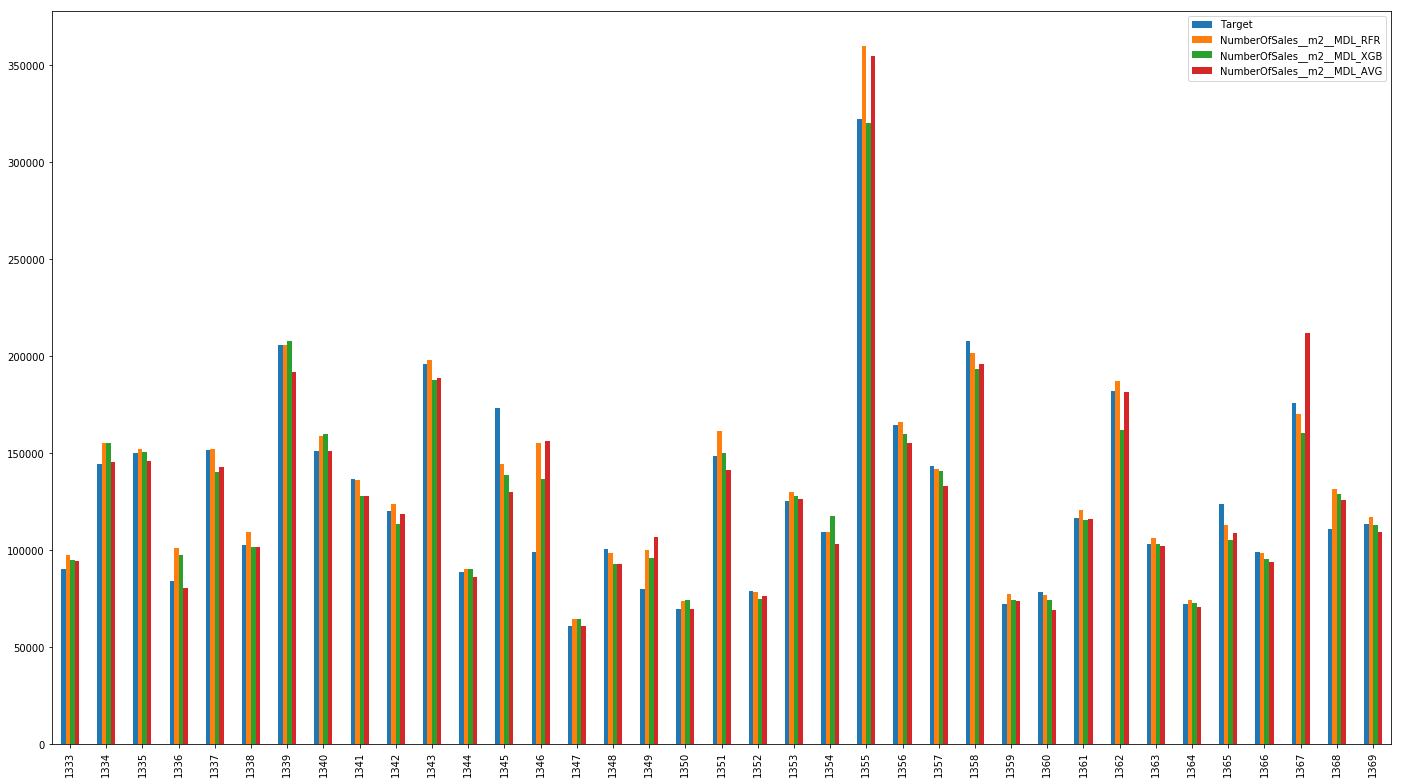

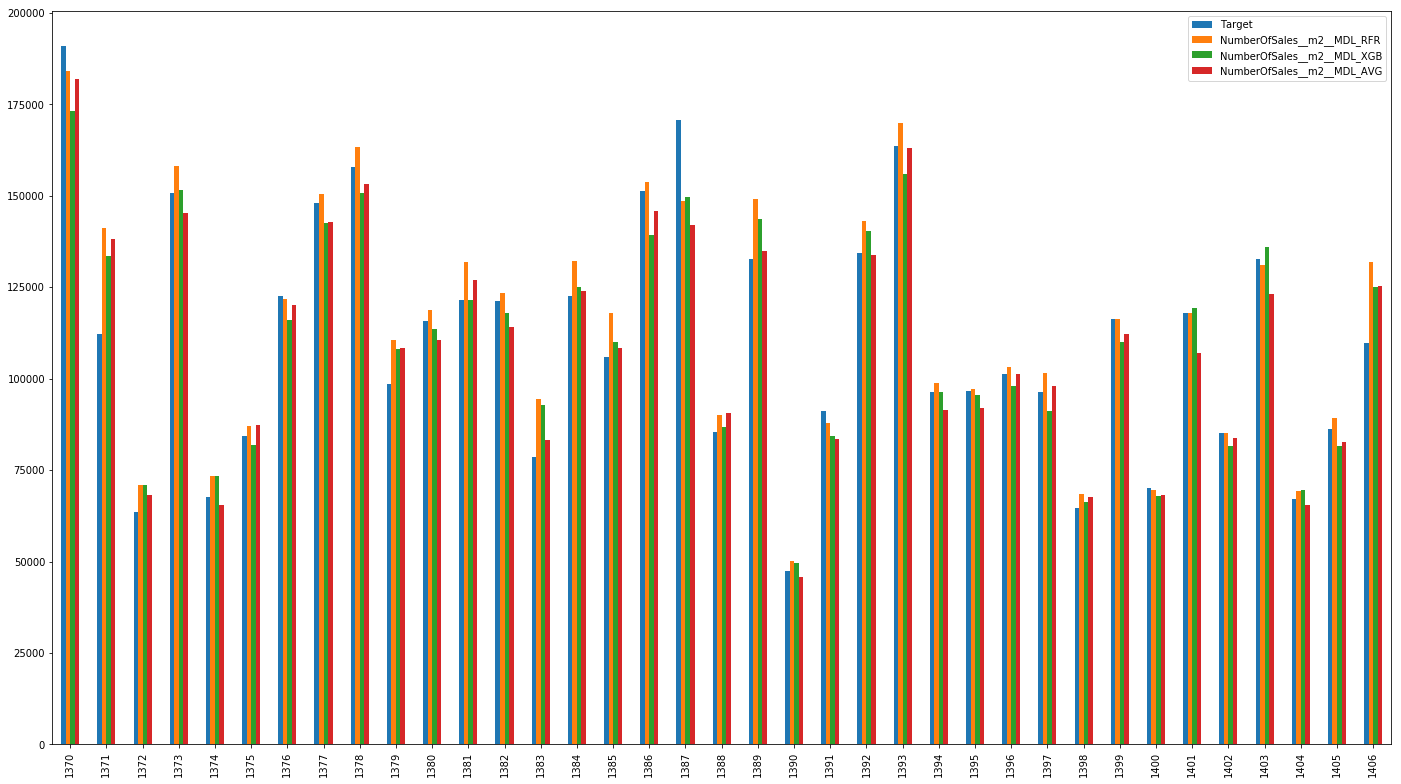

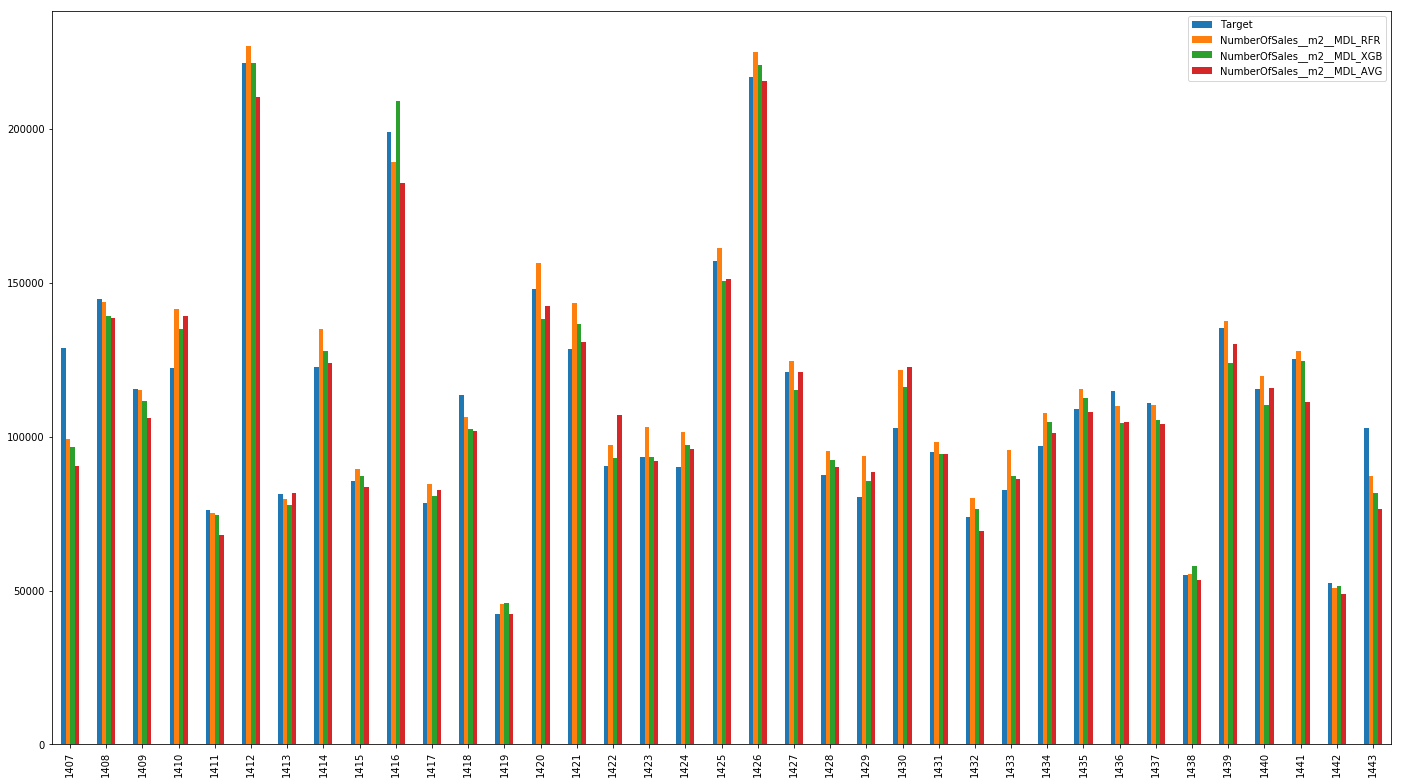

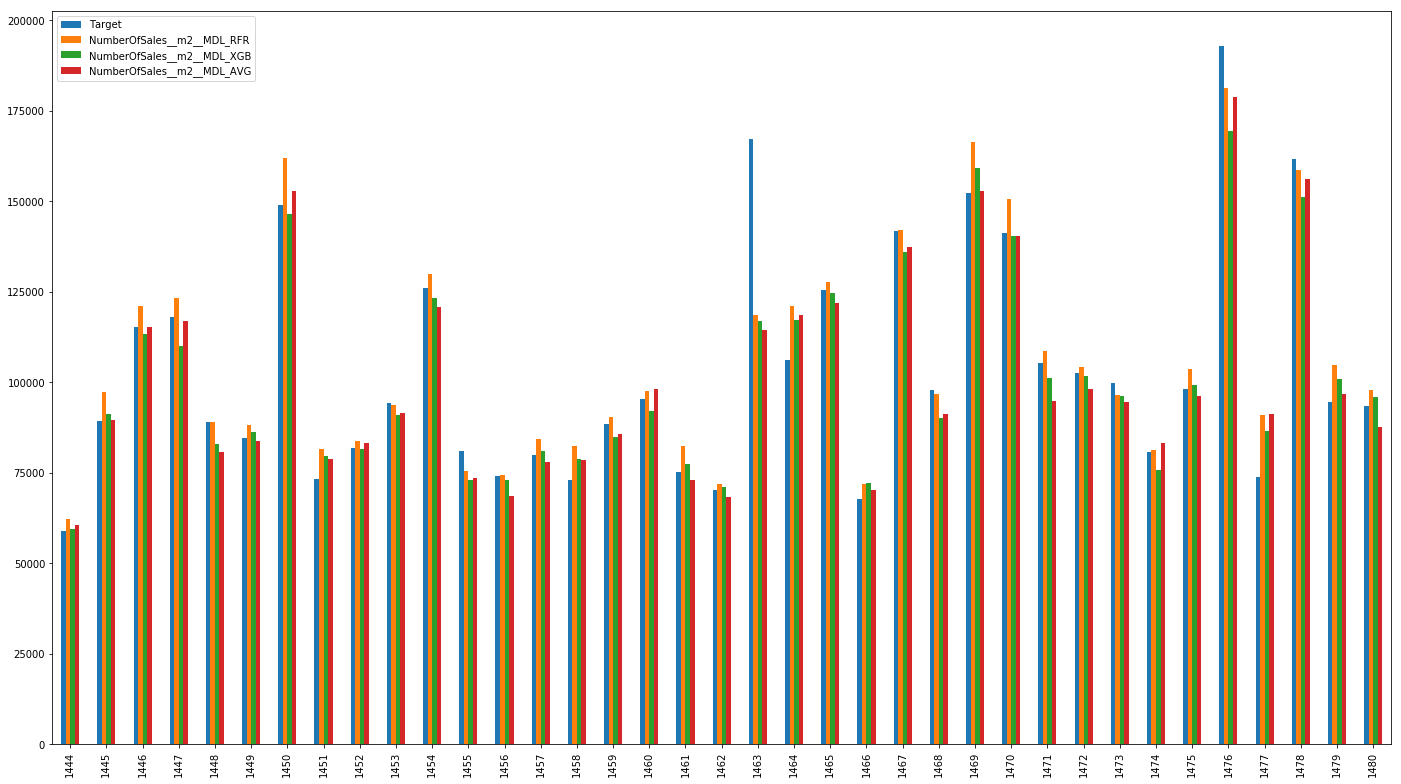

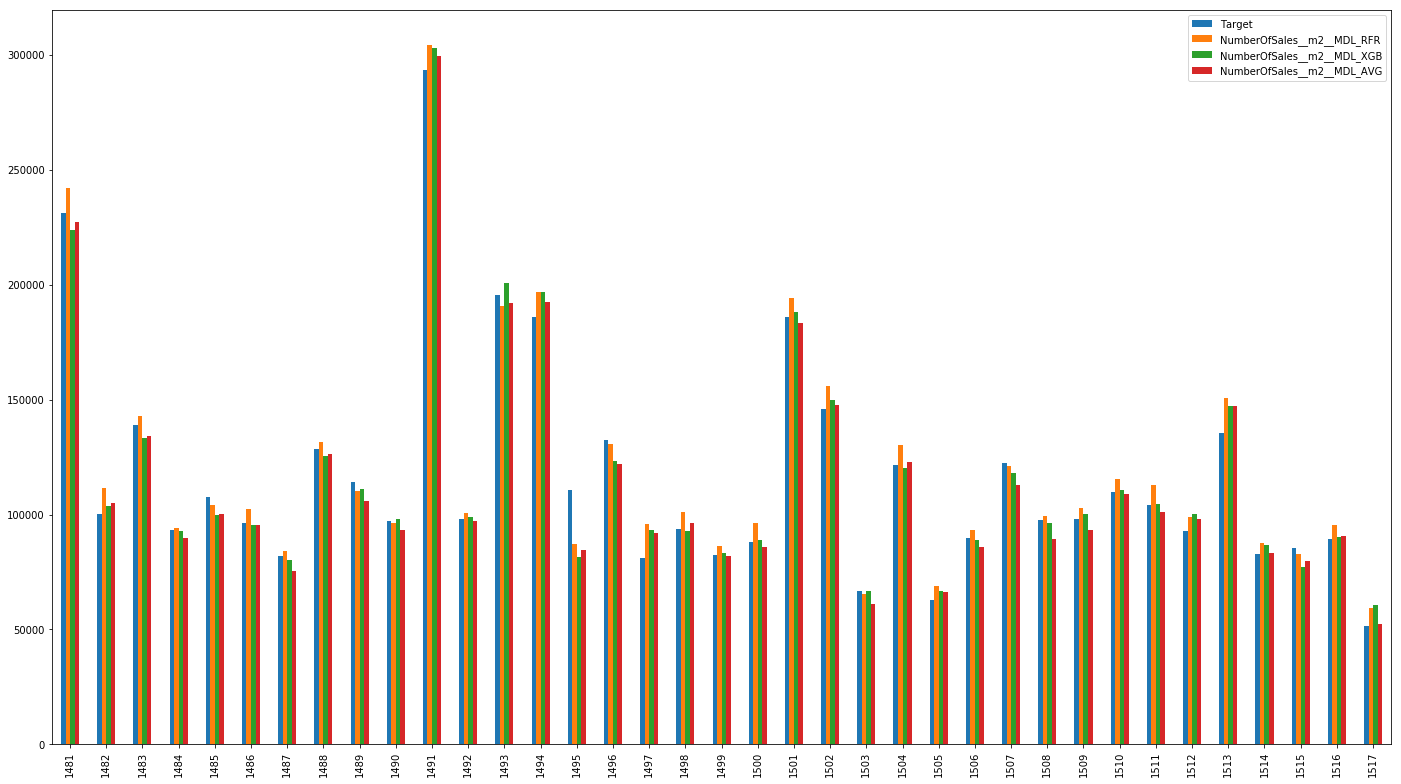

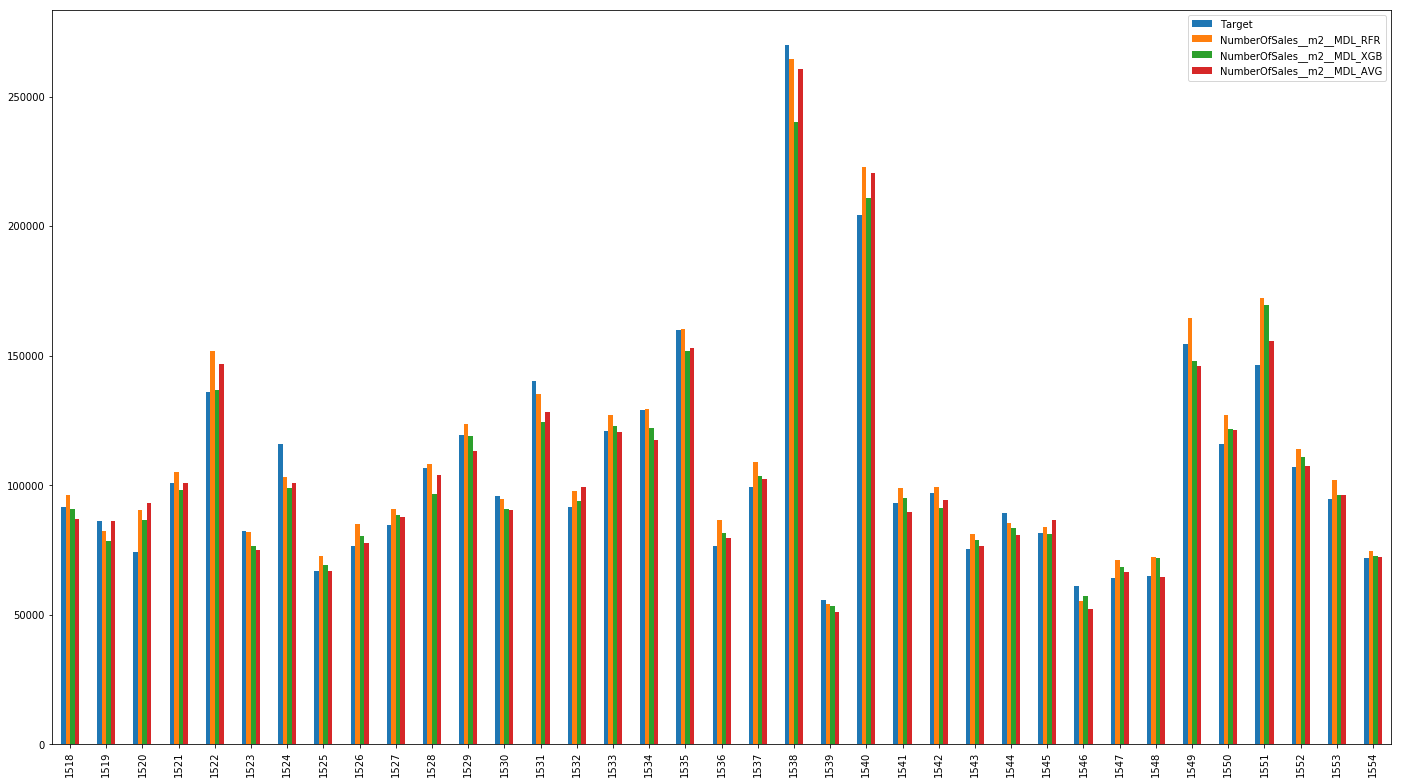

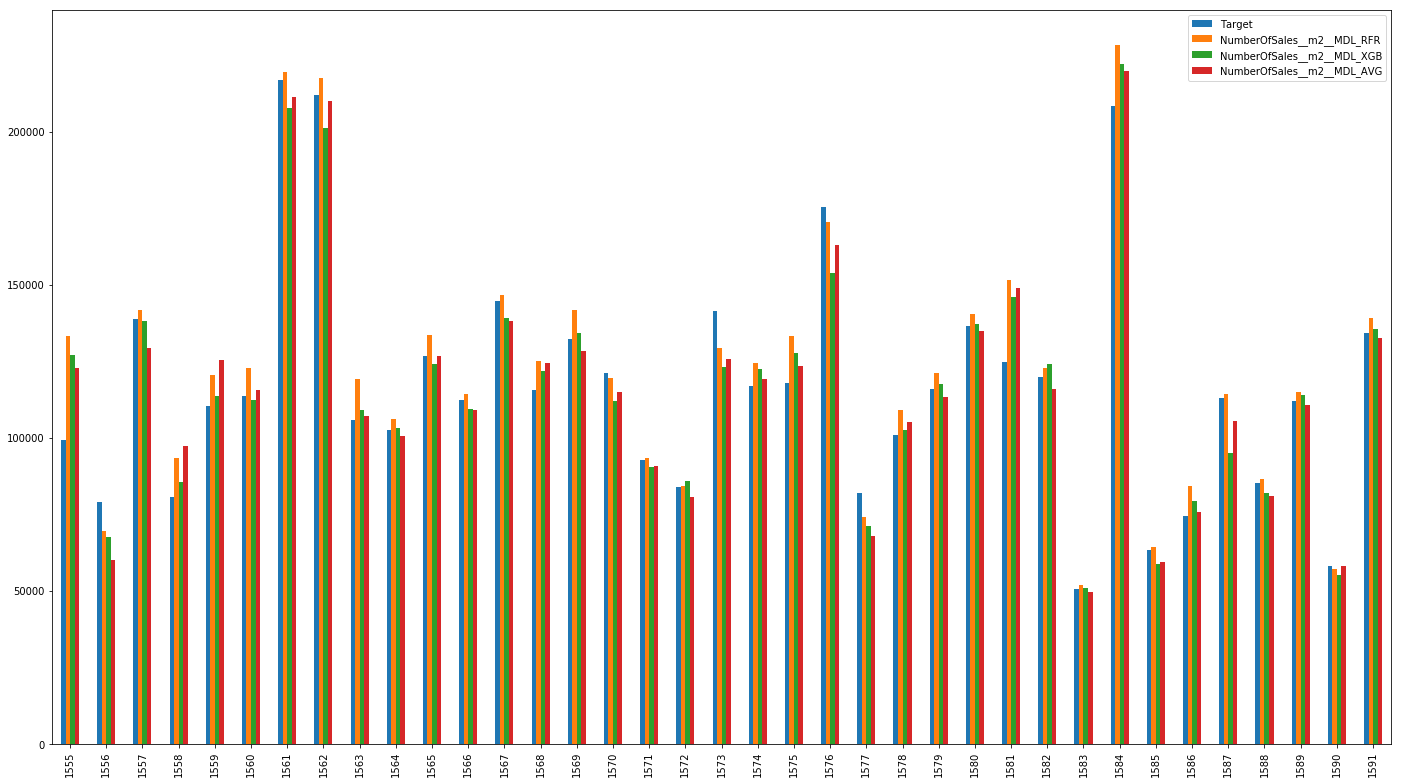

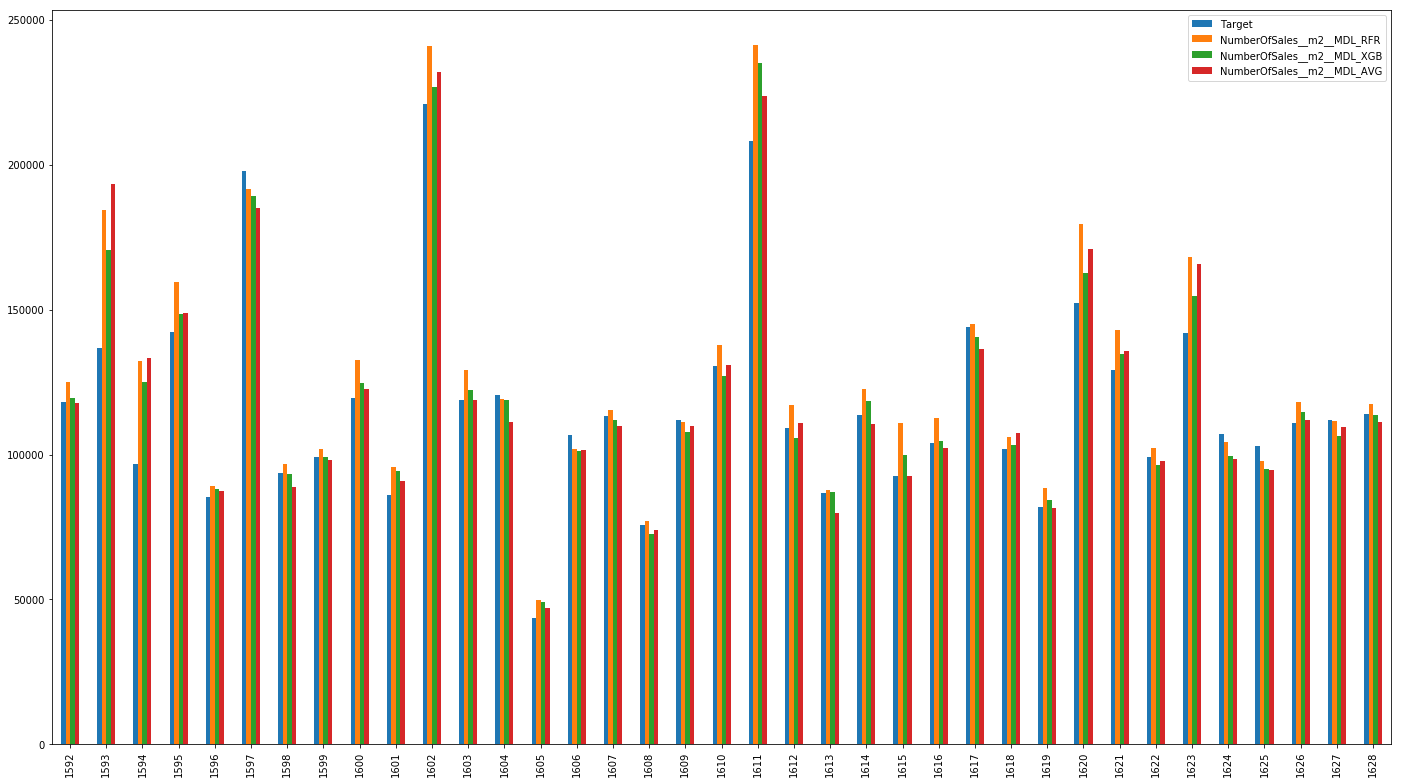

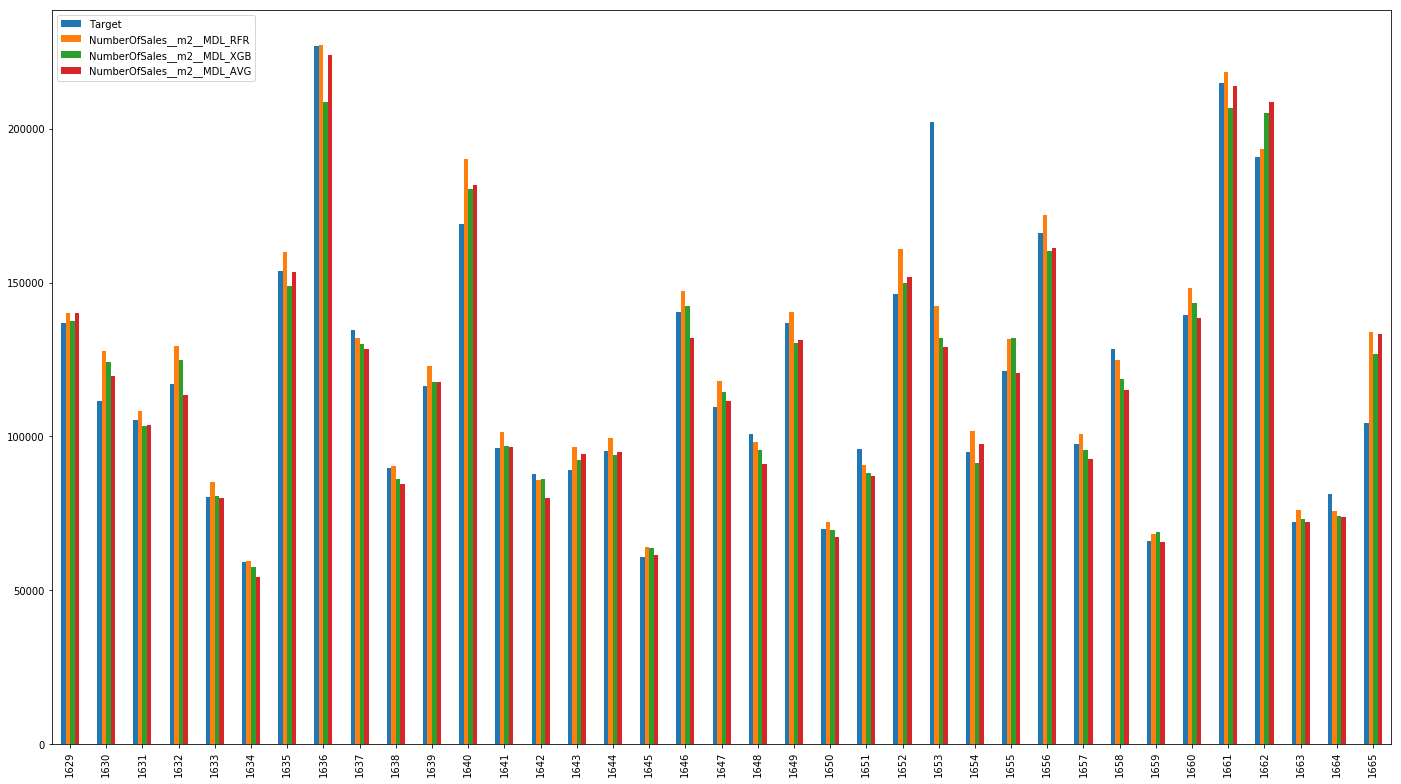

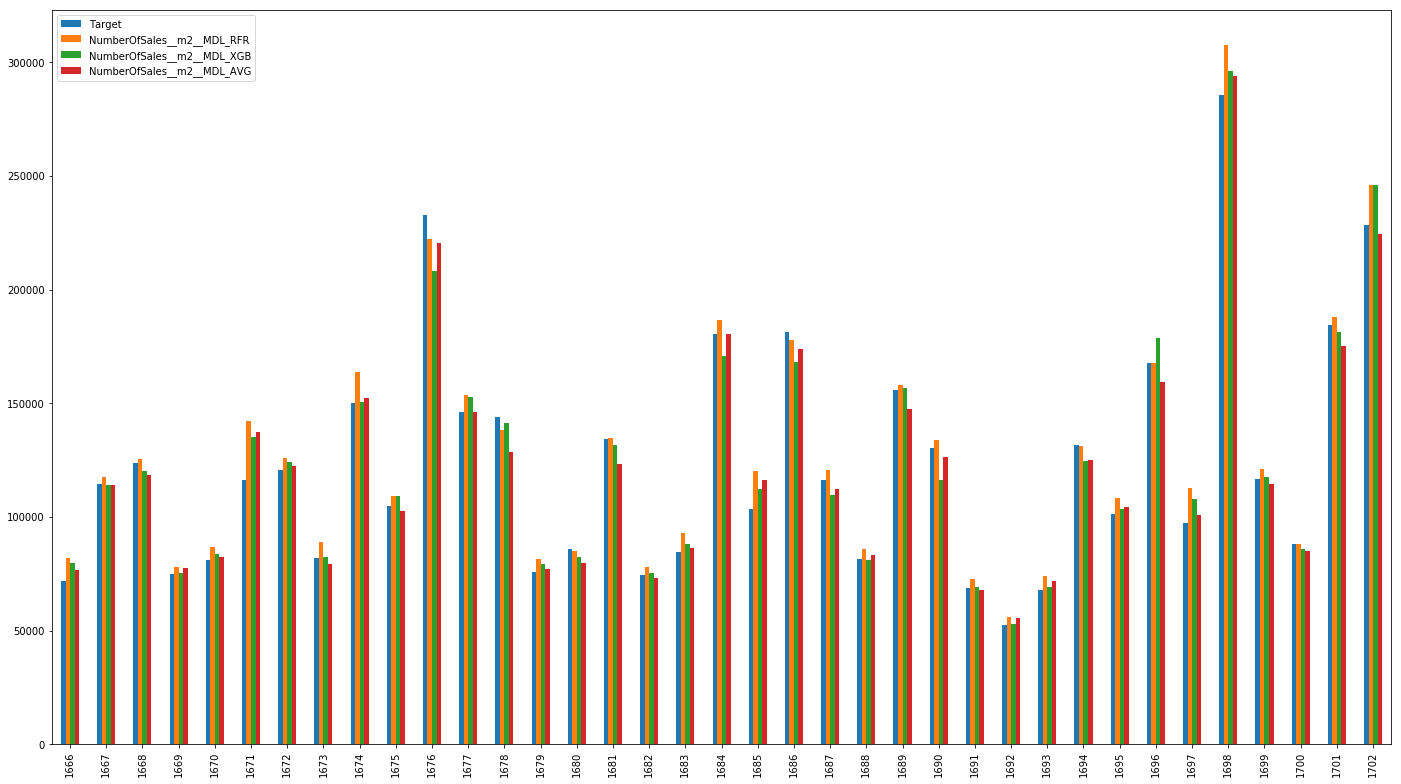

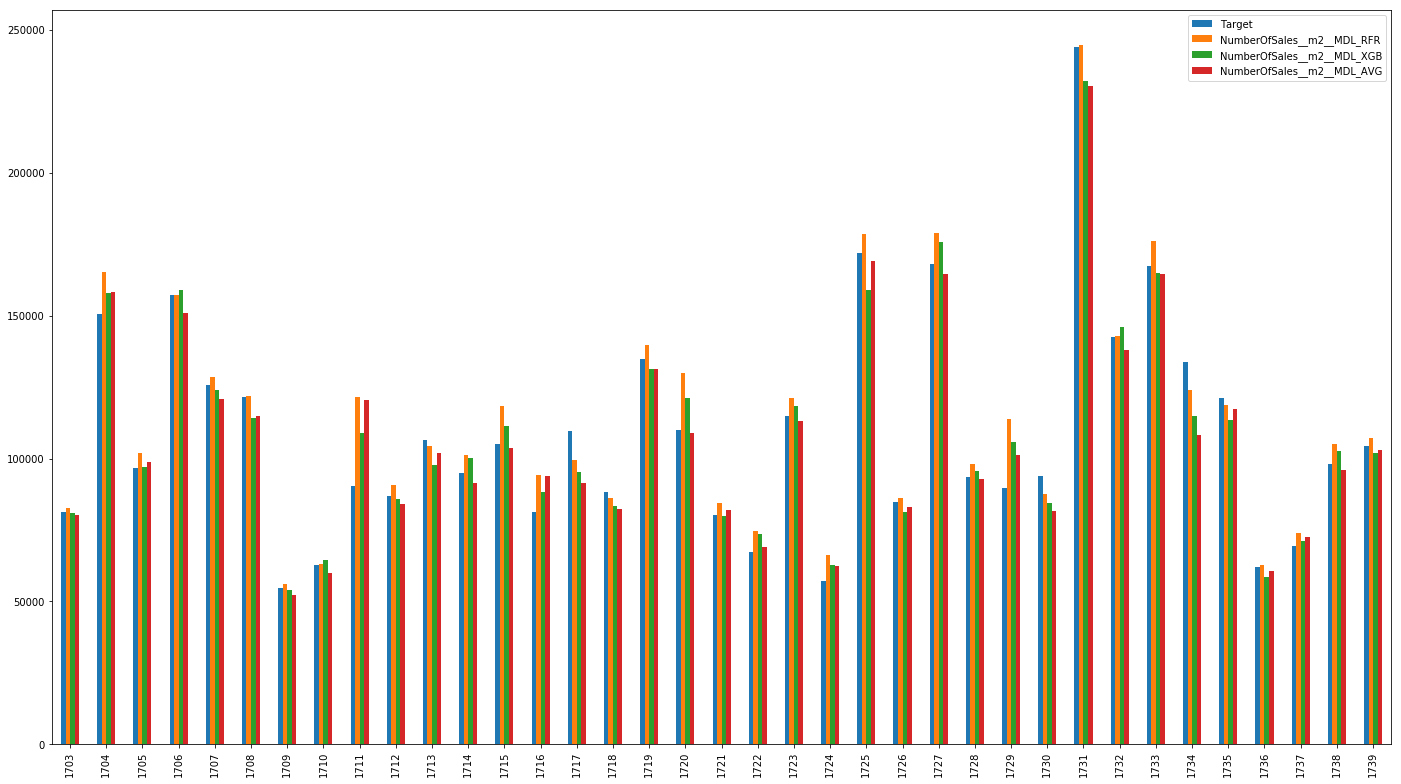

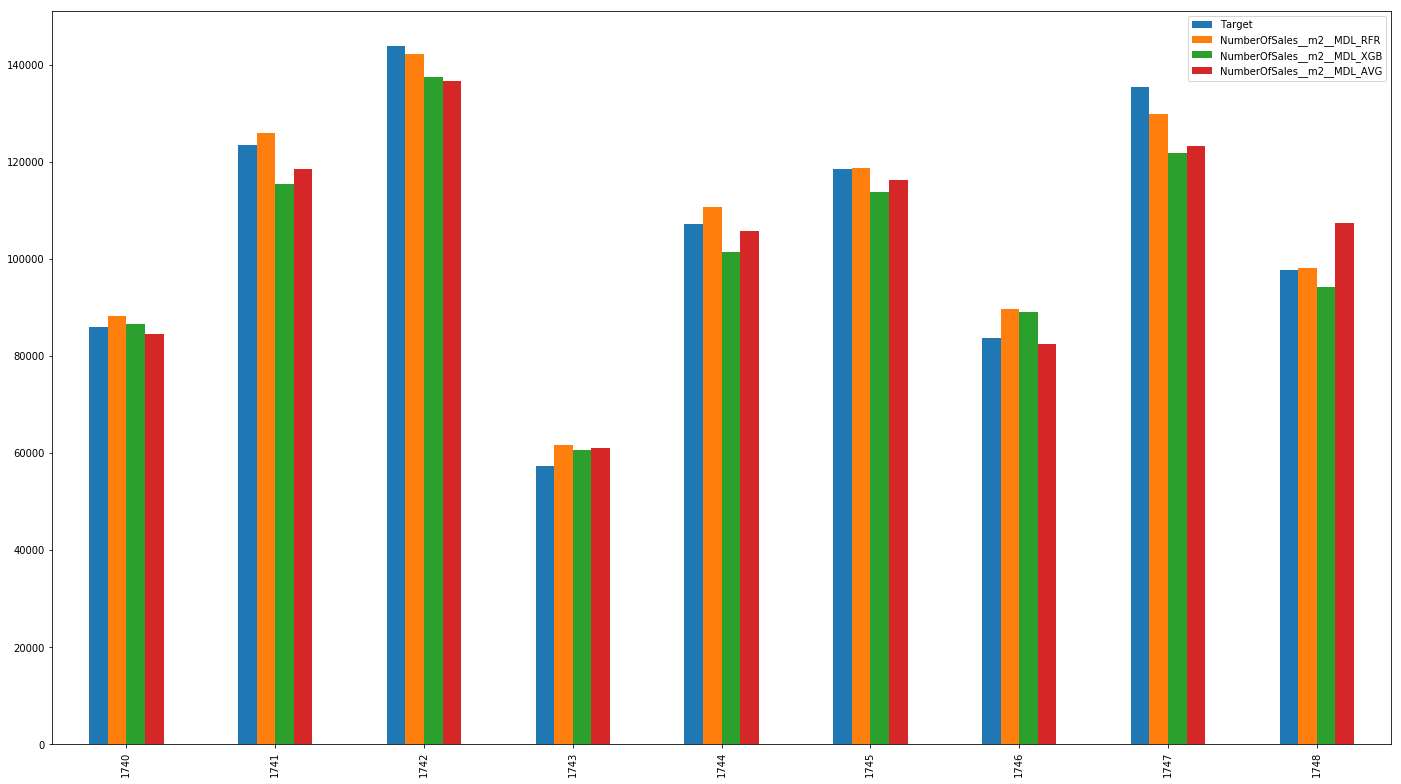

In [13]:
plot_comparison_bar_plots(df_plots, month=1)  # to print them all
#plot_comparison_bar_plots(df_plots, month=1, first=10, last=11) # just print one

## Deviation of models' predictions from target

Let's plot the trend of the errors that models do on predictiong with respect to the actual value.

Deviation = Predicted - Actual

<Figure size 432x288 with 0 Axes>

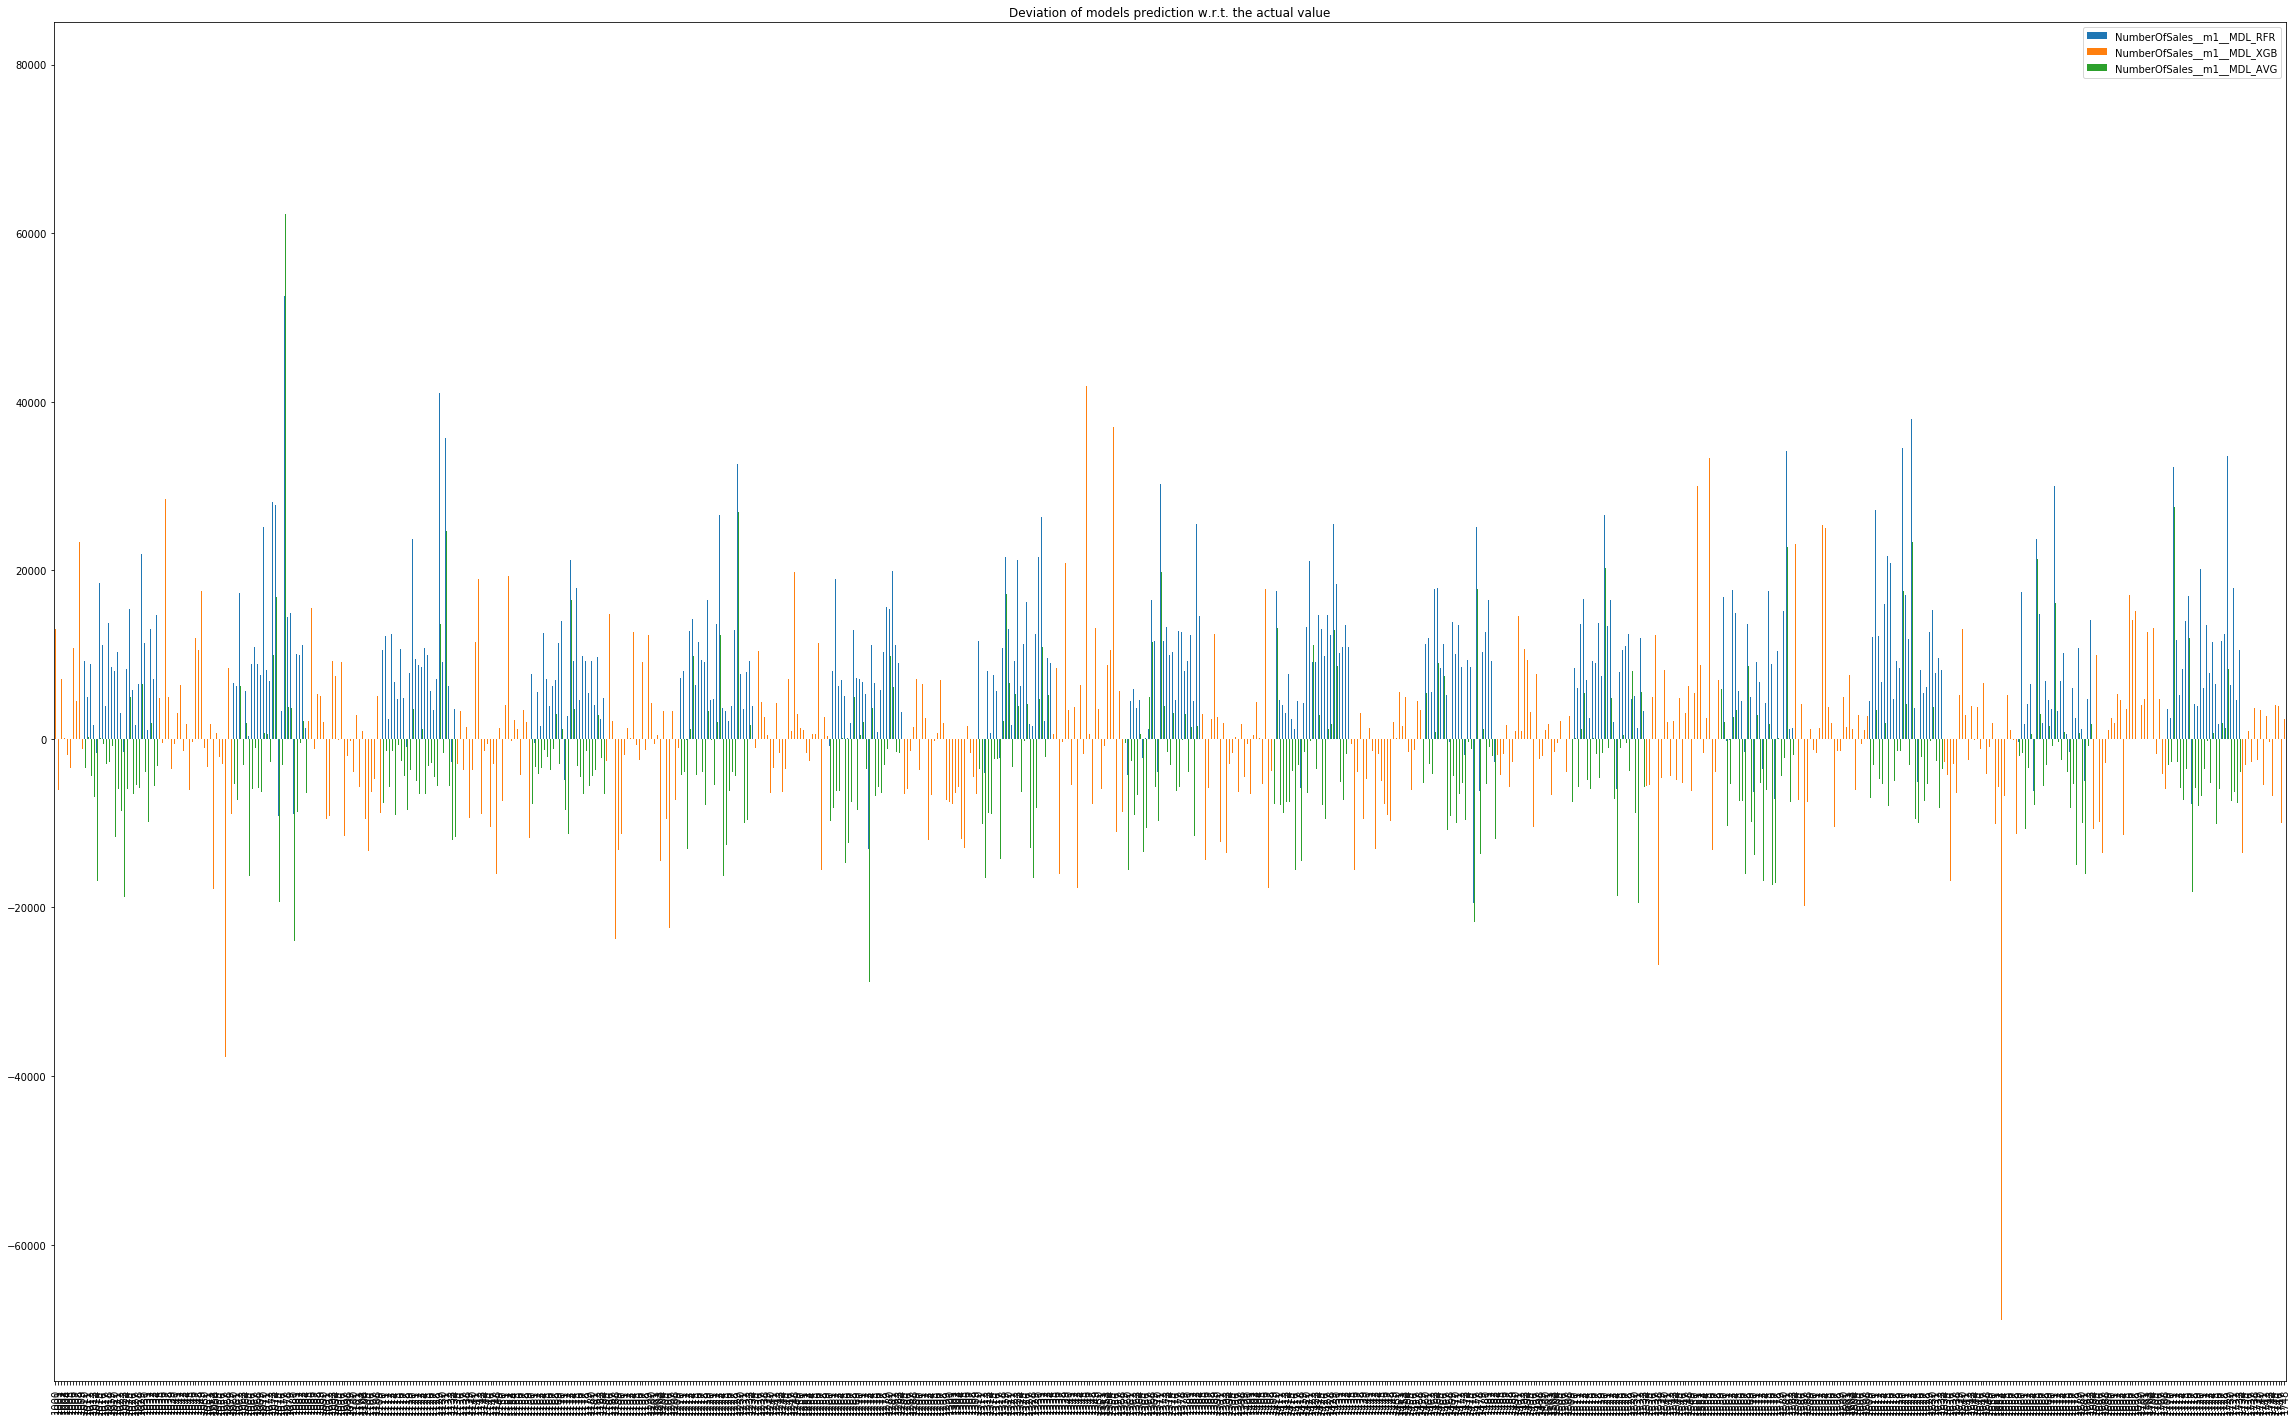

<Figure size 432x288 with 0 Axes>

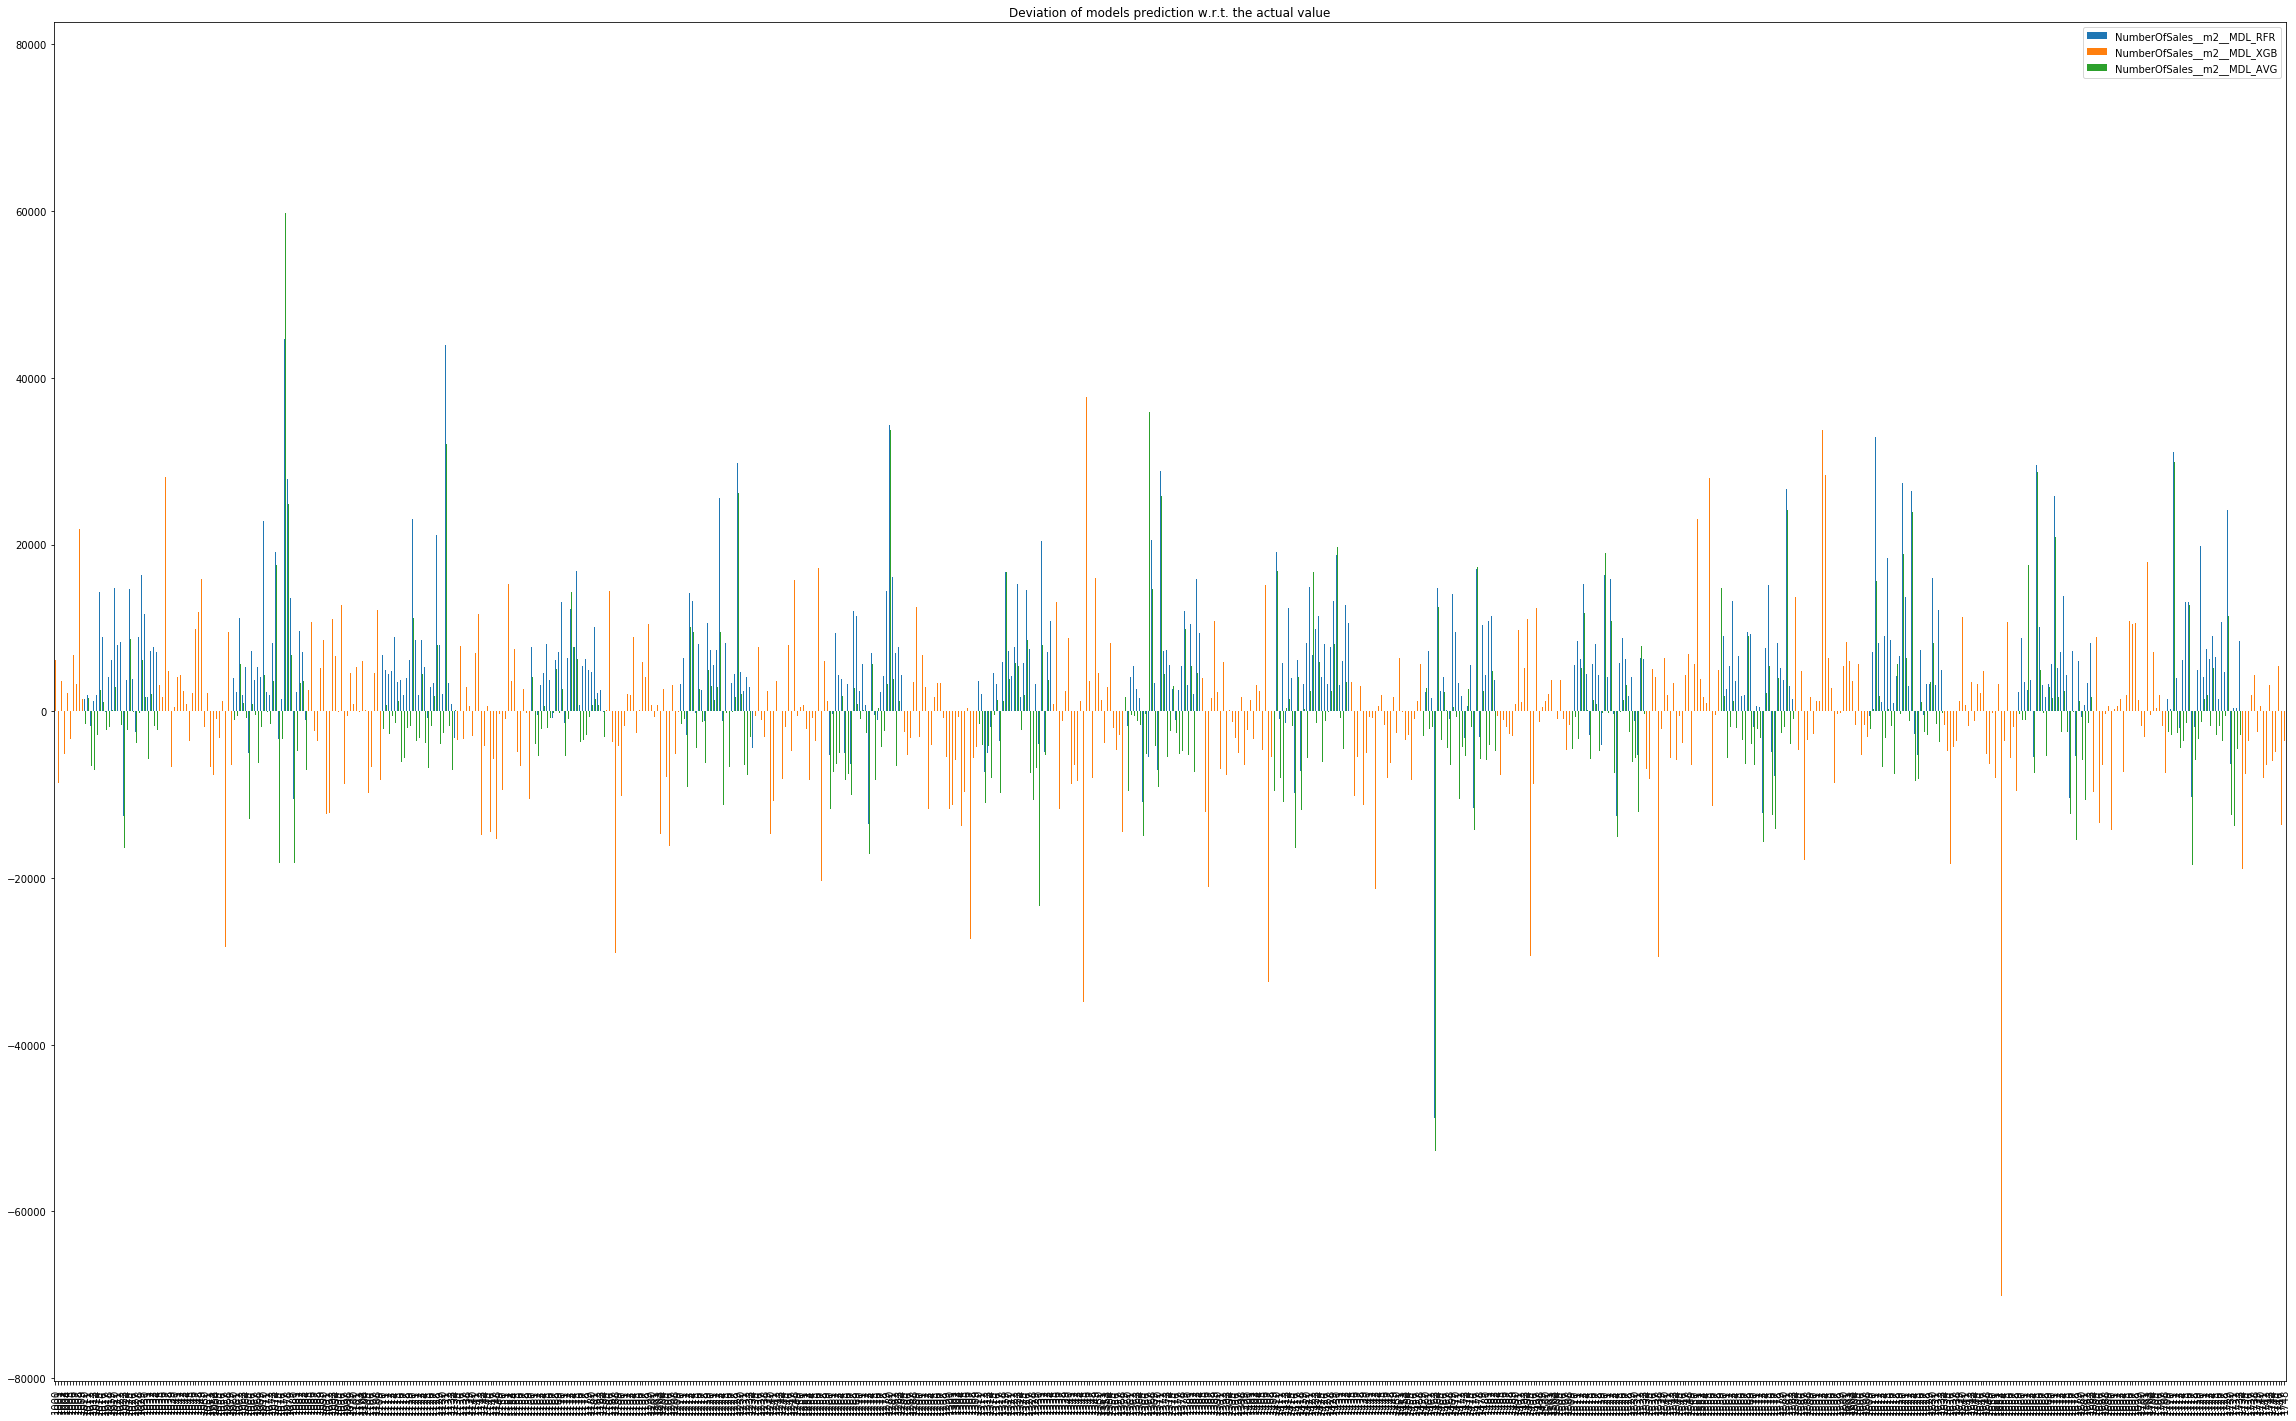

In [14]:
for i in range(0,2):
    dd = df_plots[i].copy()
    cols = list(dd.columns)
    cols.remove('Target')
    
    # compute the difference
    for c in cols:
        dd[c] = dd[c] - dd['Target']
    
    dd.drop(['Target'], inplace=True, axis=1)
    
    plt.figure(); dd.plot(kind='bar', figsize=(40,25), title='Deviation of models prediction w.r.t. the actual value' )    

In [15]:
def plot_deviation_from_target(df_plots, month=0, n=20, first=0, last=None):
    '''
    Plot a number of bar plots of the deviation from target of the predictions.
    
    Example:  
        
        plot_deviation_from_target(df_plots, month=1, n=20, first=10, last=12)
    
    Will print the month 1 of predictions for all the models.
    It will split the total number of stores in 20 batches and it will print
    the bar plots diagrams of the 10th, 11th, 12th.


    :param list df_plots: The df plots list created before in the nobeook.
    :param int month: The index of the month to print. Allowed values: 0, 1
    :param int n: The quantity of batches into which split the dataframe. One batch --> One diagram
    :param int first: The first batch form which start to plot
    :param int last: The last batch to print
    '''
    if not last:
        last = n

    # n: how many plots to create?
    # first: first plot to be printed
    # last: last plot to be printed 
    
    assert(first < n and first < last)

    n_stores = df_plots[0].shape[0]
    step = n_stores // n

    idx = 1000
    for i in range(0, n + 1):
        # exit condition
        if i > last:
            break

        if i >= first:
            slc_to_plt = df_plots[month][(df_plots[month].index >= idx) & (df_plots[month].index < idx + step)]
            cols = list(slc_to_plt.columns)
            cols.remove('Target')
            
            # compute the difference
            for c in cols:
                slc_to_plt[c] = slc_to_plt[c] - slc_to_plt['Target']
            
            slc_to_plt.drop(['Target'], inplace=True, axis=1)
            plt.figure(); 
            slc_to_plt.plot(kind='bar', figsize=(24,13.5), title='Deviation of models prediction w.r.t. the actual value' )  
            
        idx += step


### FIRST MONTH: Deviation from target of predictions   

<Figure size 432x288 with 0 Axes>

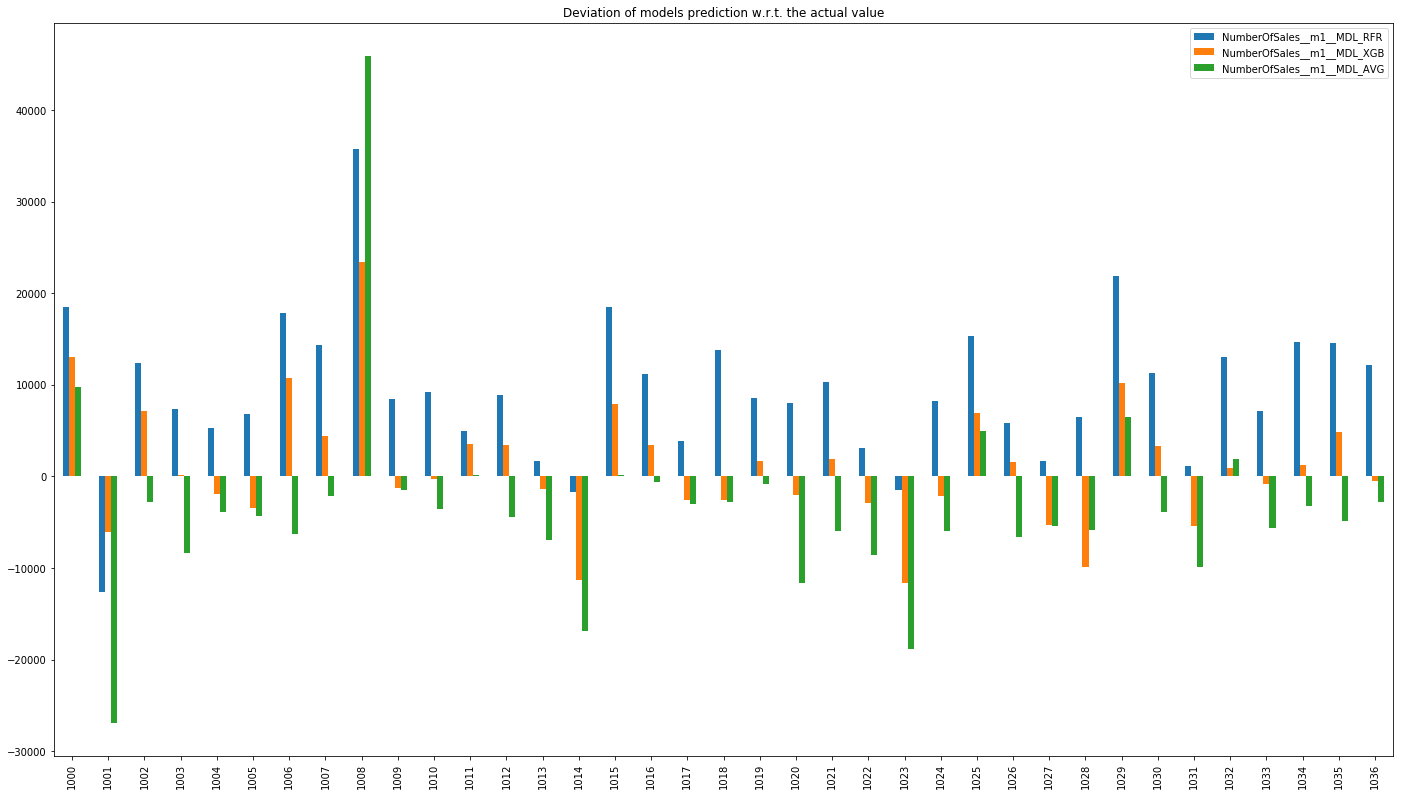

<Figure size 432x288 with 0 Axes>

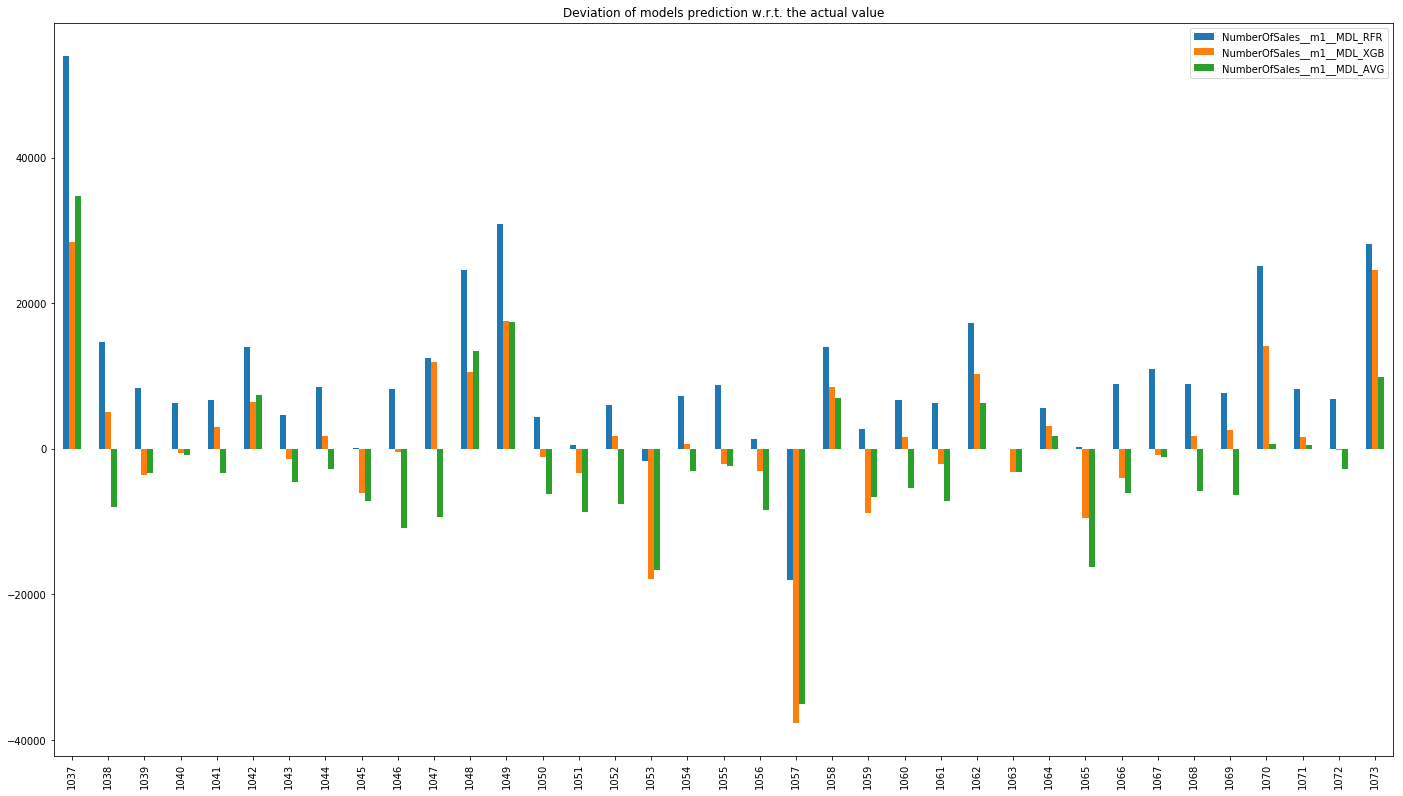

<Figure size 432x288 with 0 Axes>

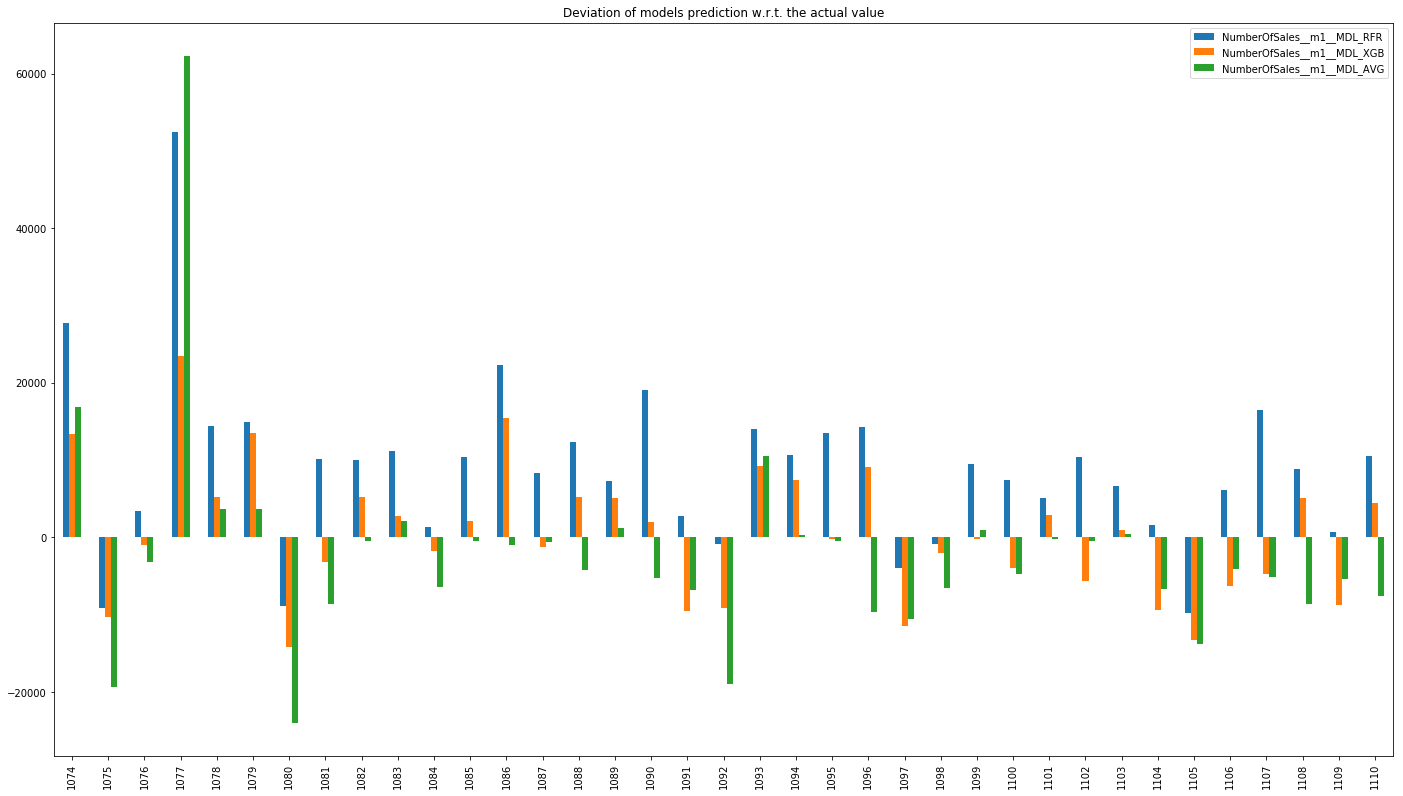

<Figure size 432x288 with 0 Axes>

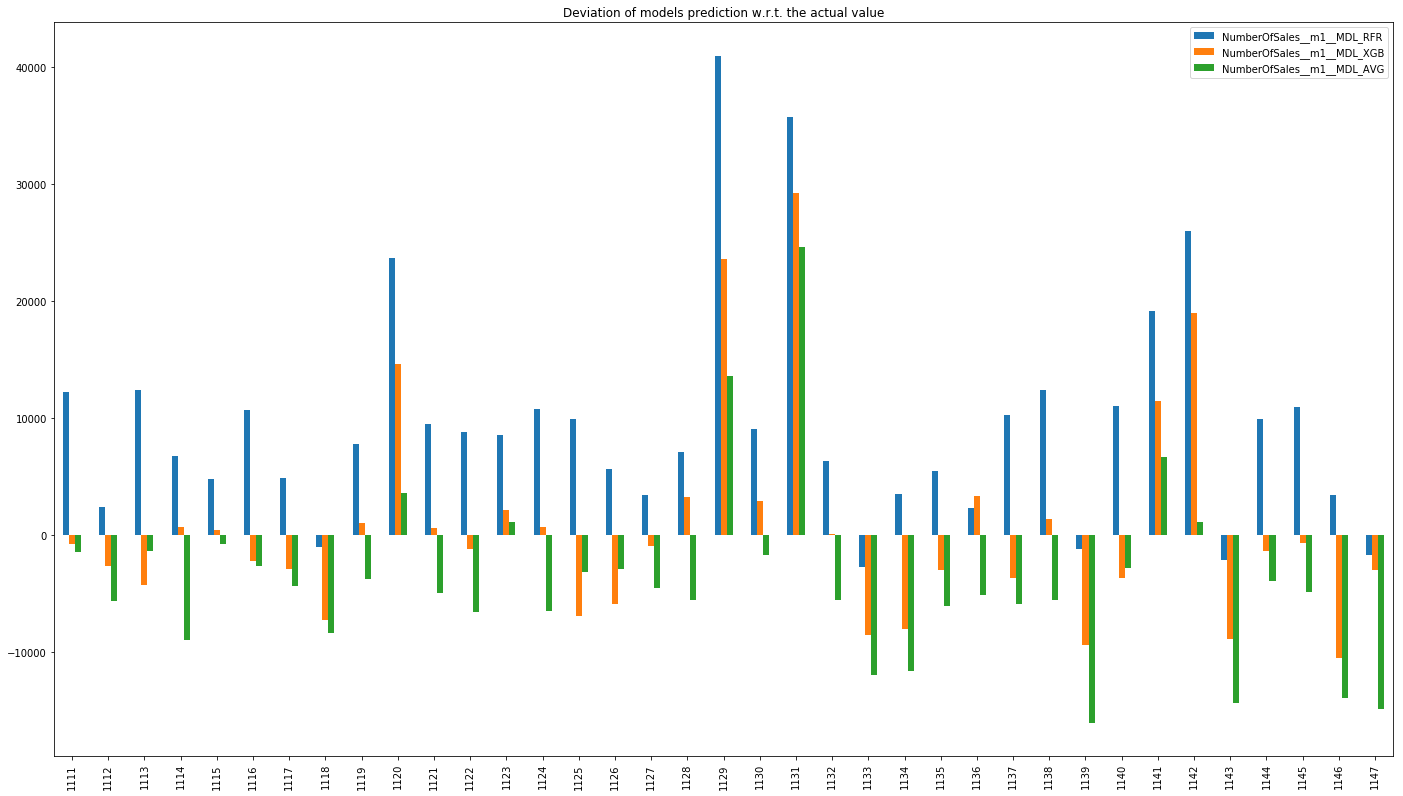

<Figure size 432x288 with 0 Axes>

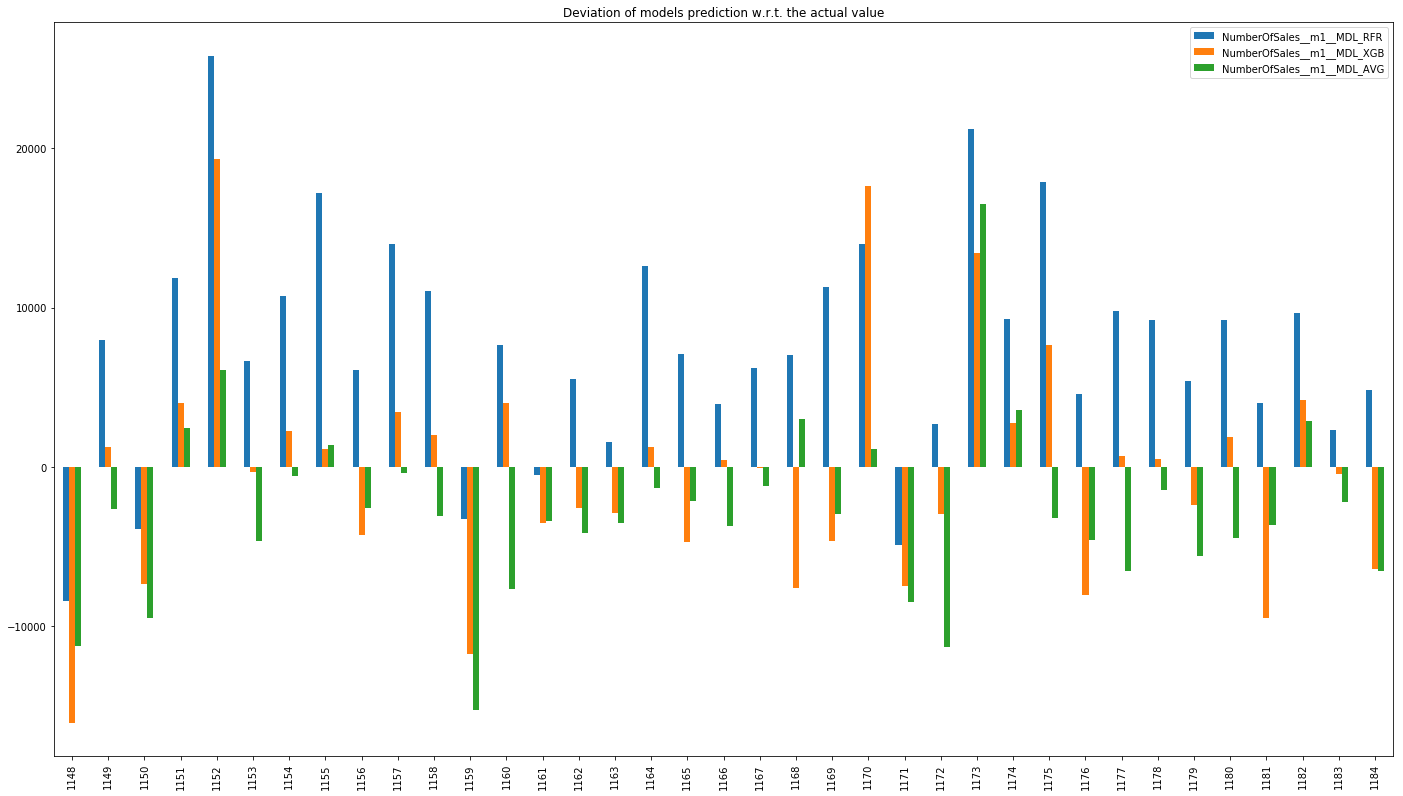

<Figure size 432x288 with 0 Axes>

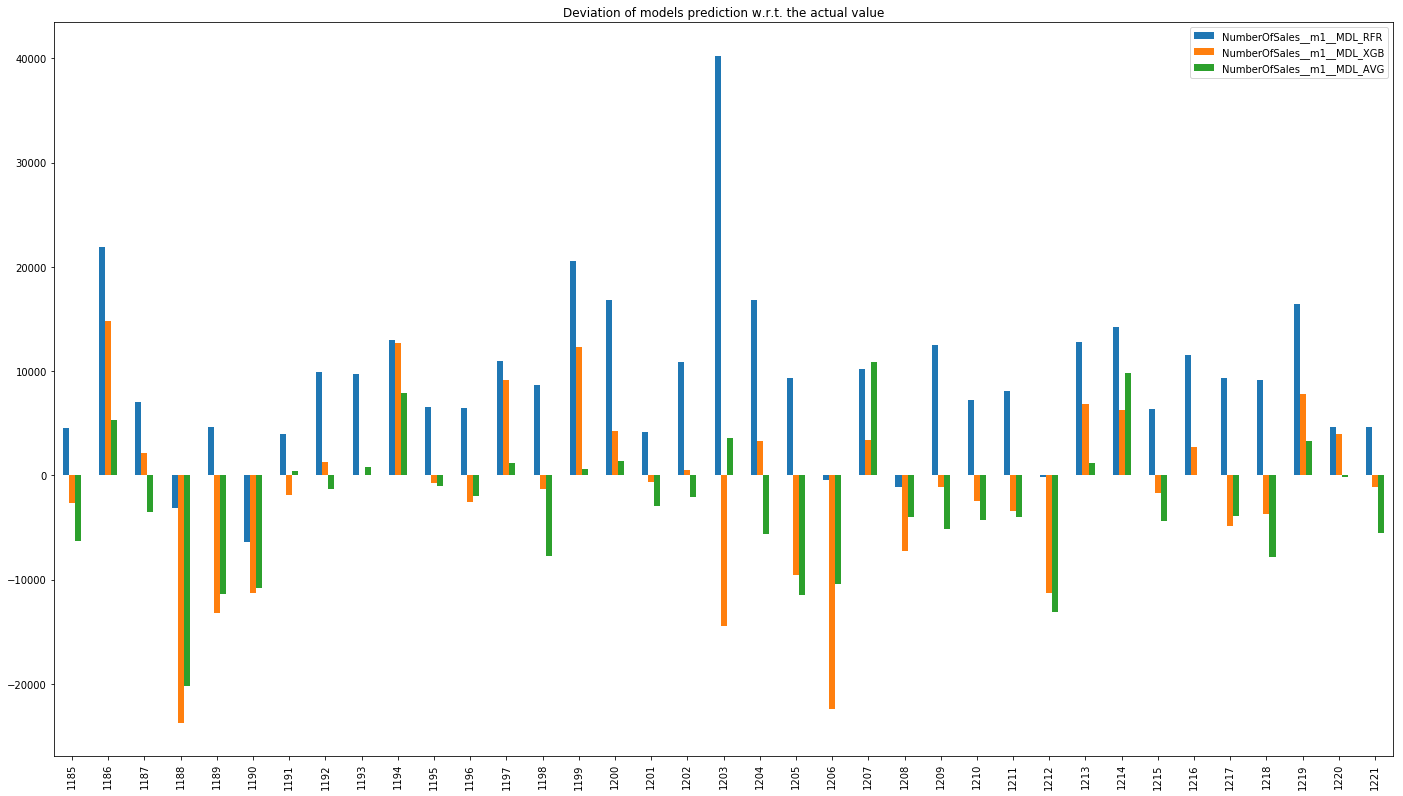

<Figure size 432x288 with 0 Axes>

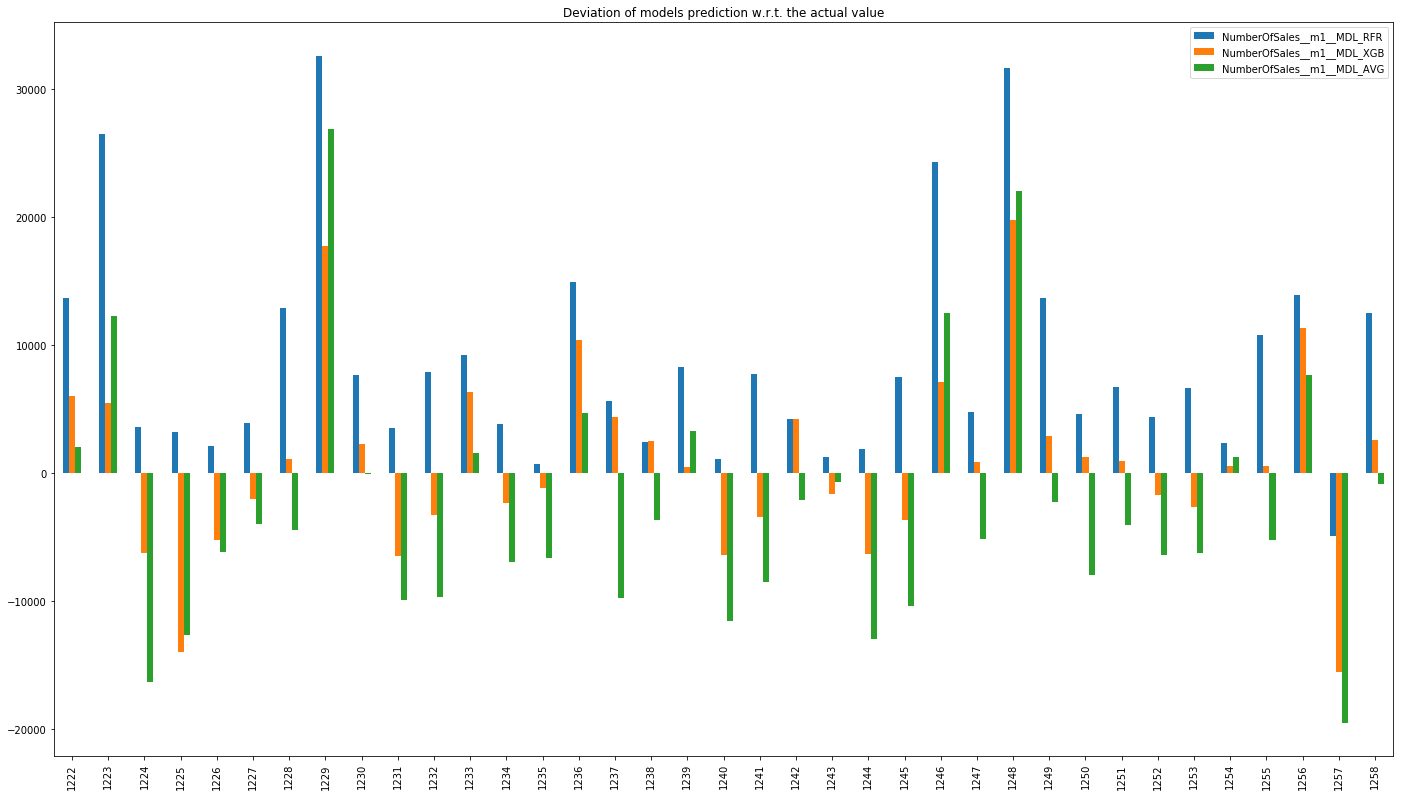

<Figure size 432x288 with 0 Axes>

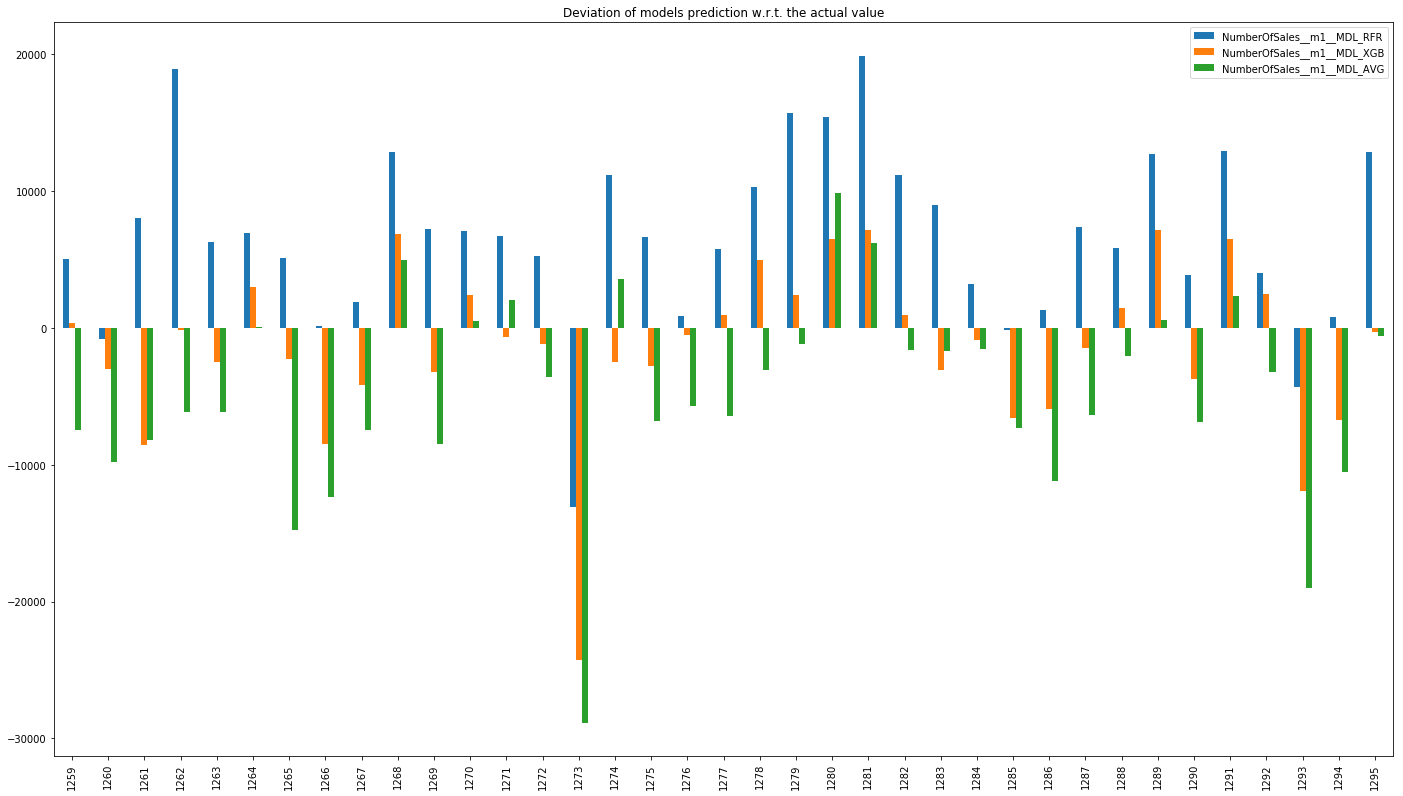

<Figure size 432x288 with 0 Axes>

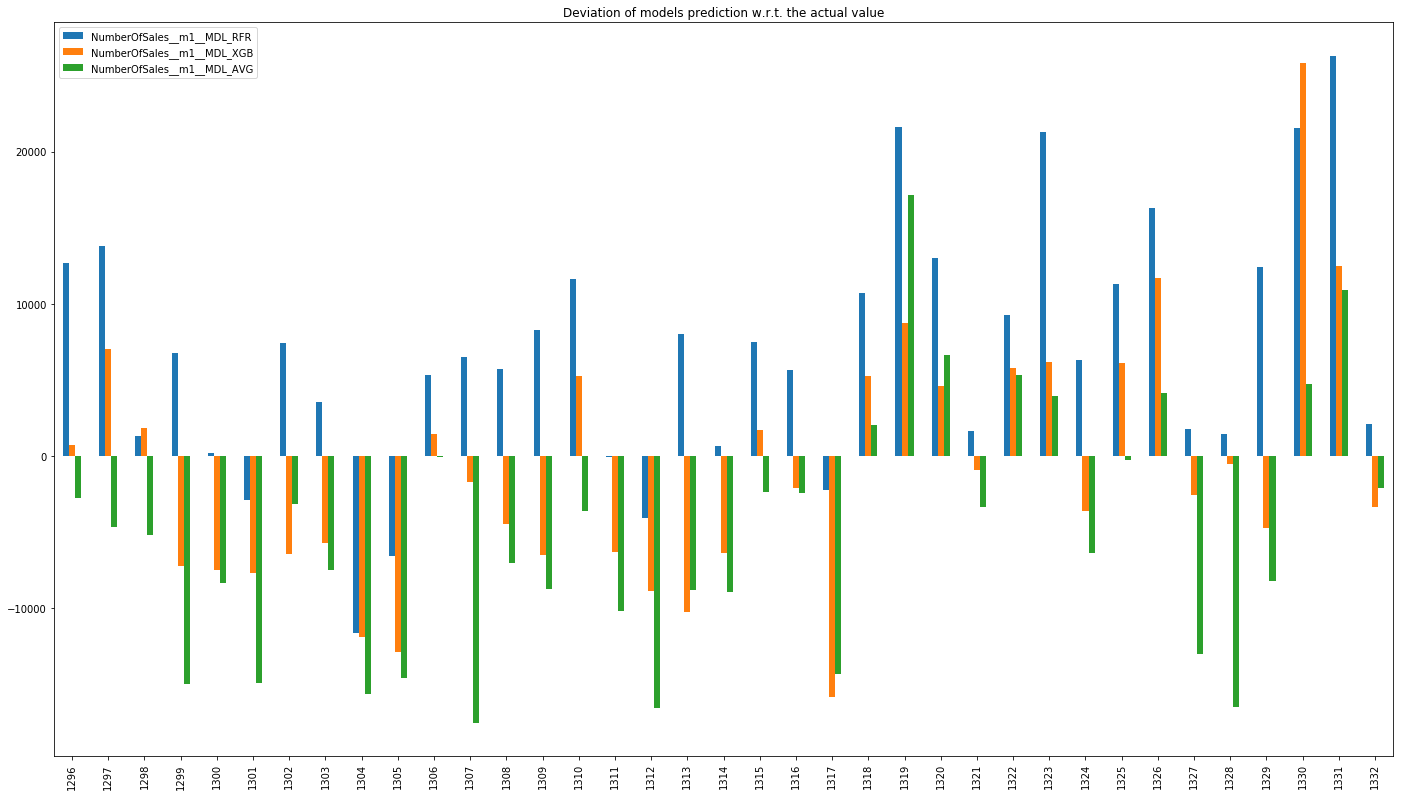

<Figure size 432x288 with 0 Axes>

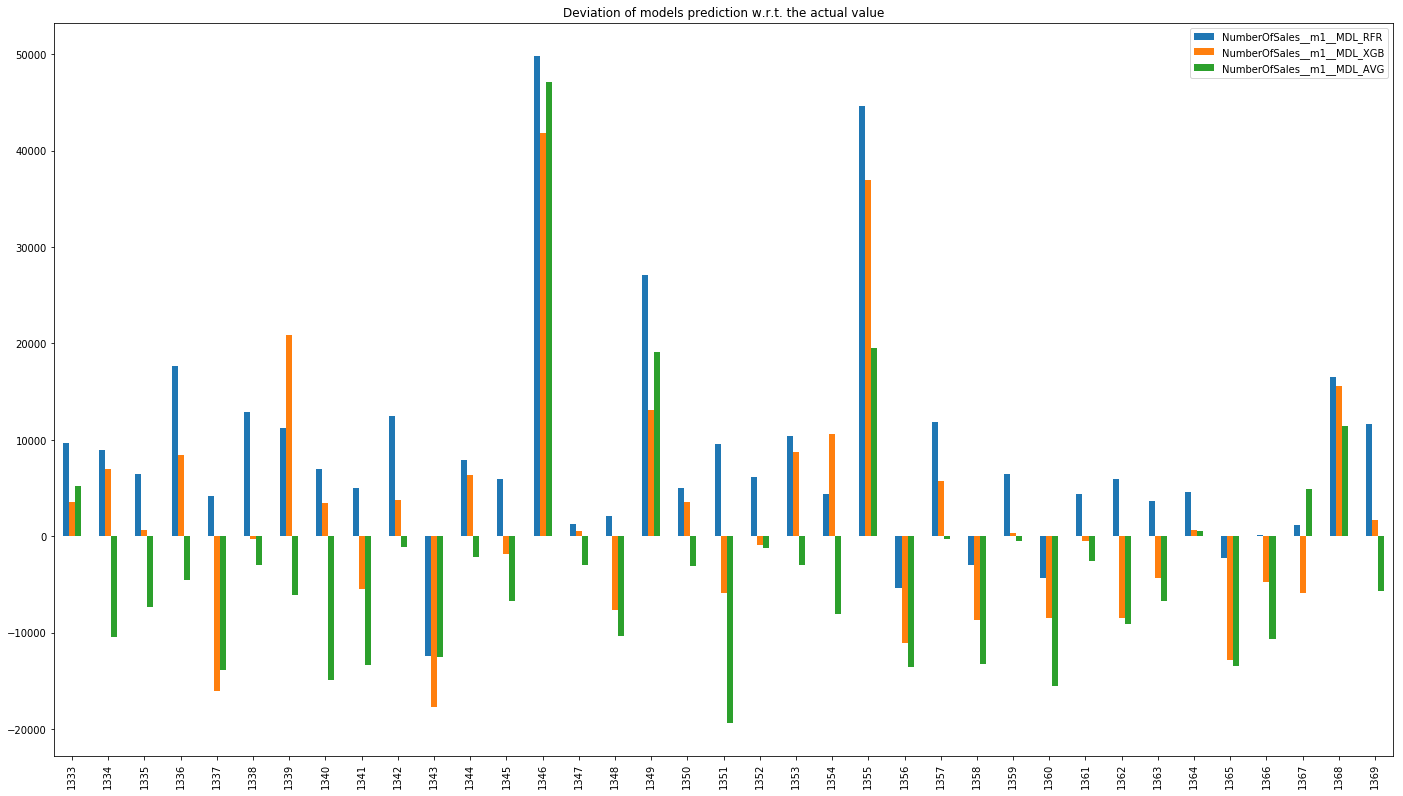

<Figure size 432x288 with 0 Axes>

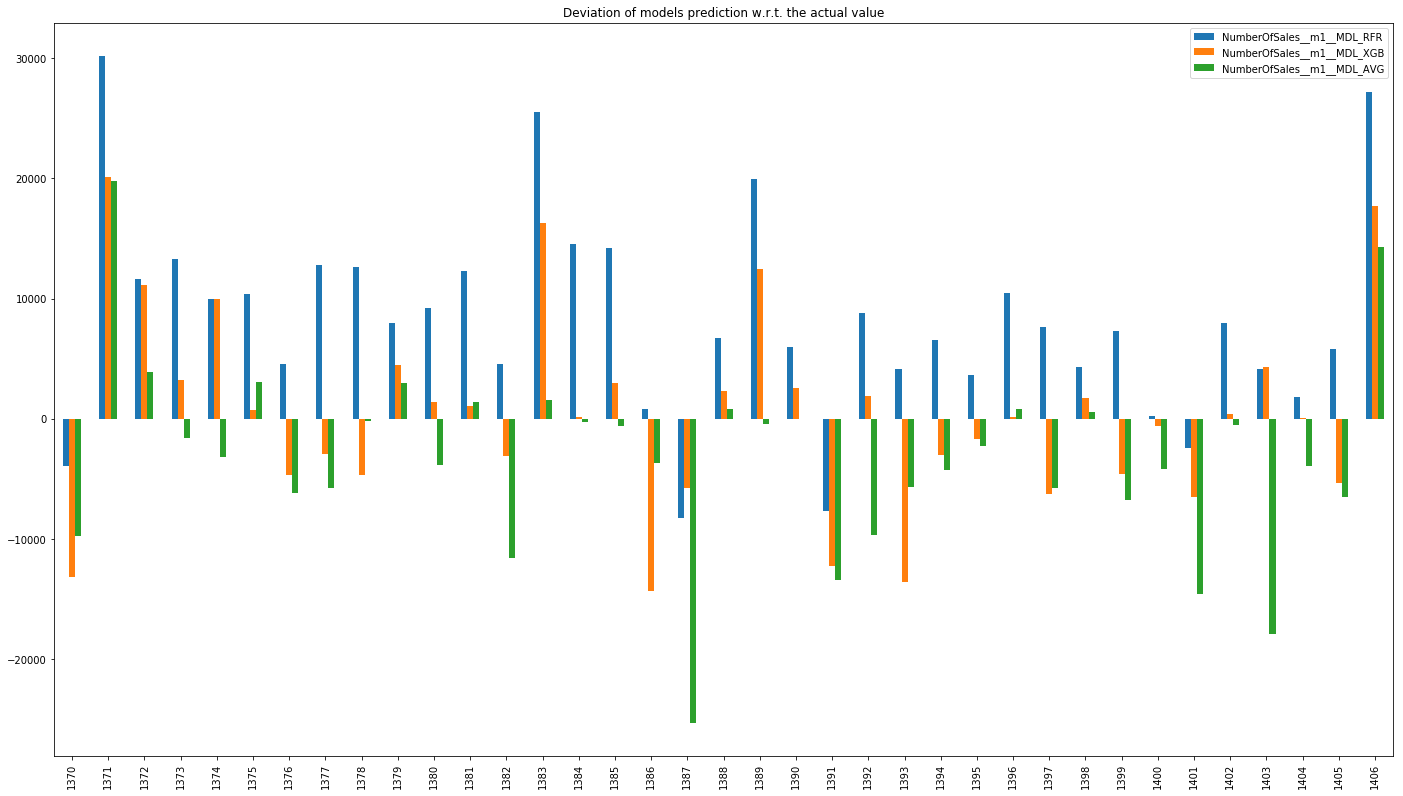

<Figure size 432x288 with 0 Axes>

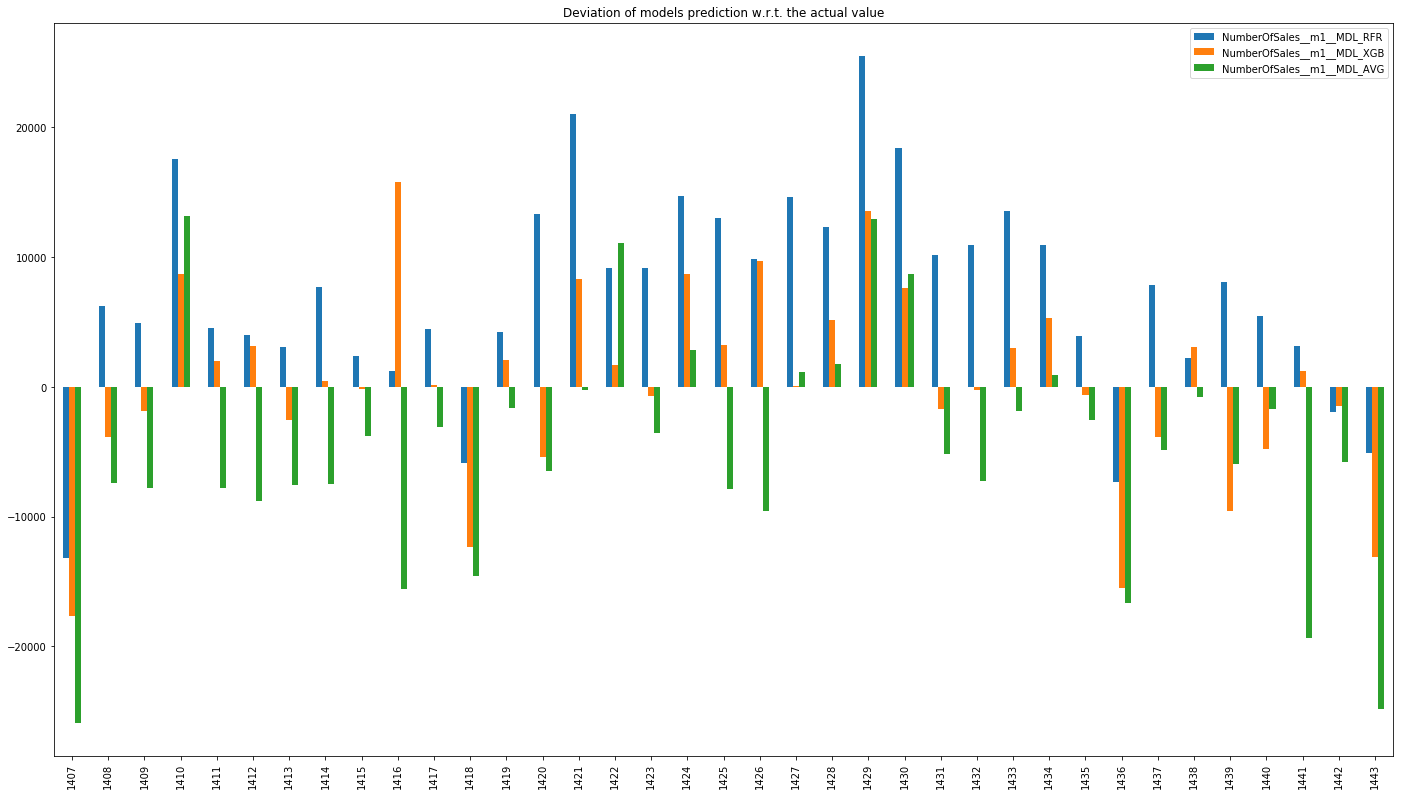

<Figure size 432x288 with 0 Axes>

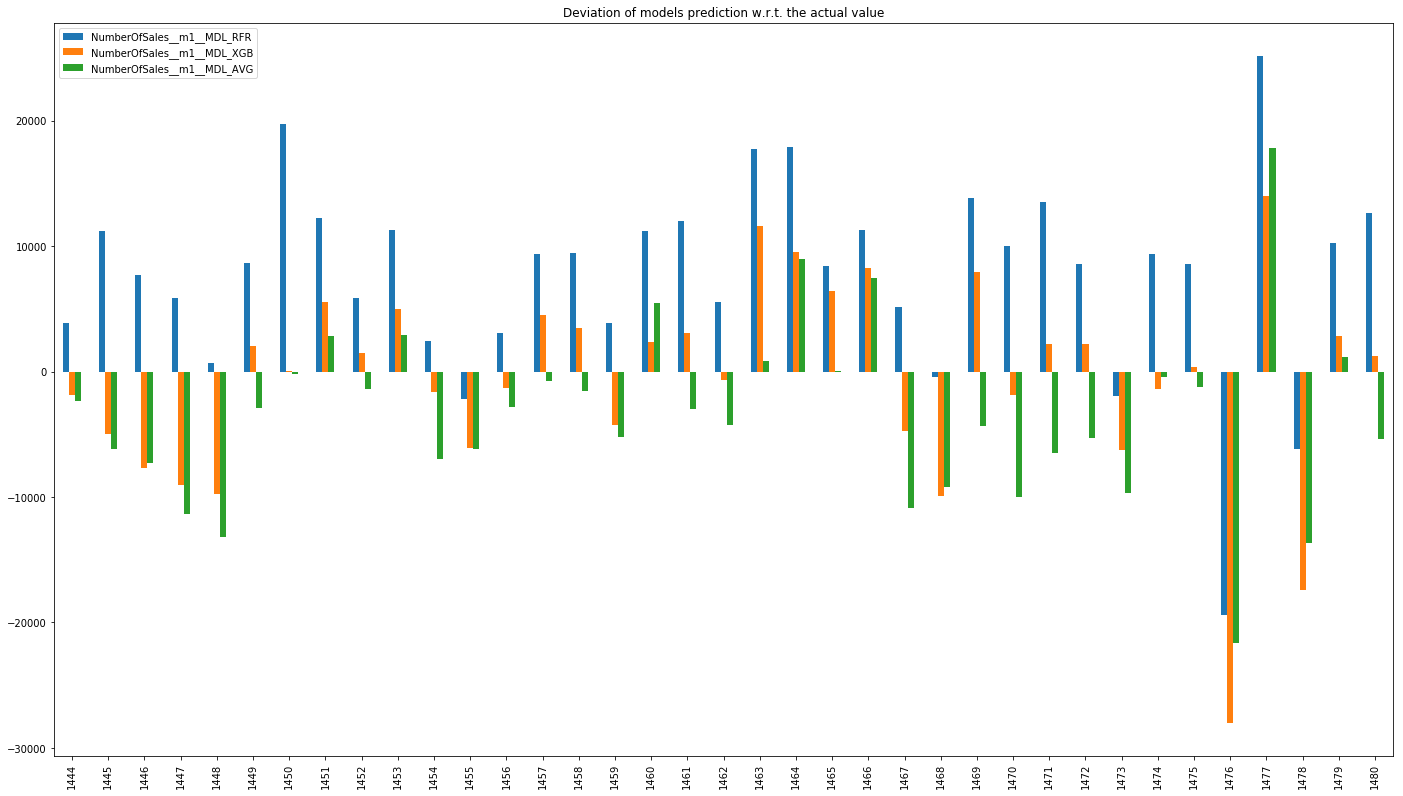

<Figure size 432x288 with 0 Axes>

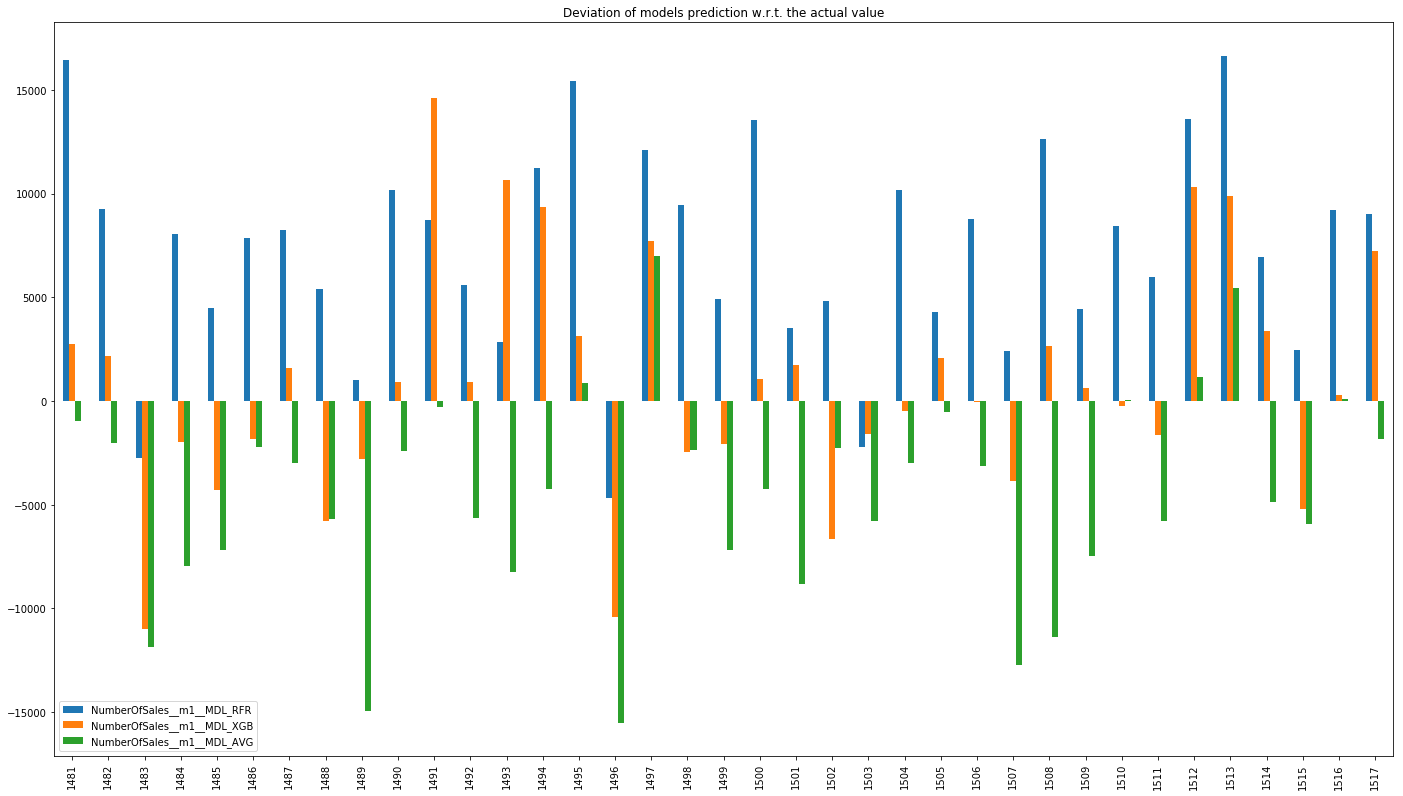

<Figure size 432x288 with 0 Axes>

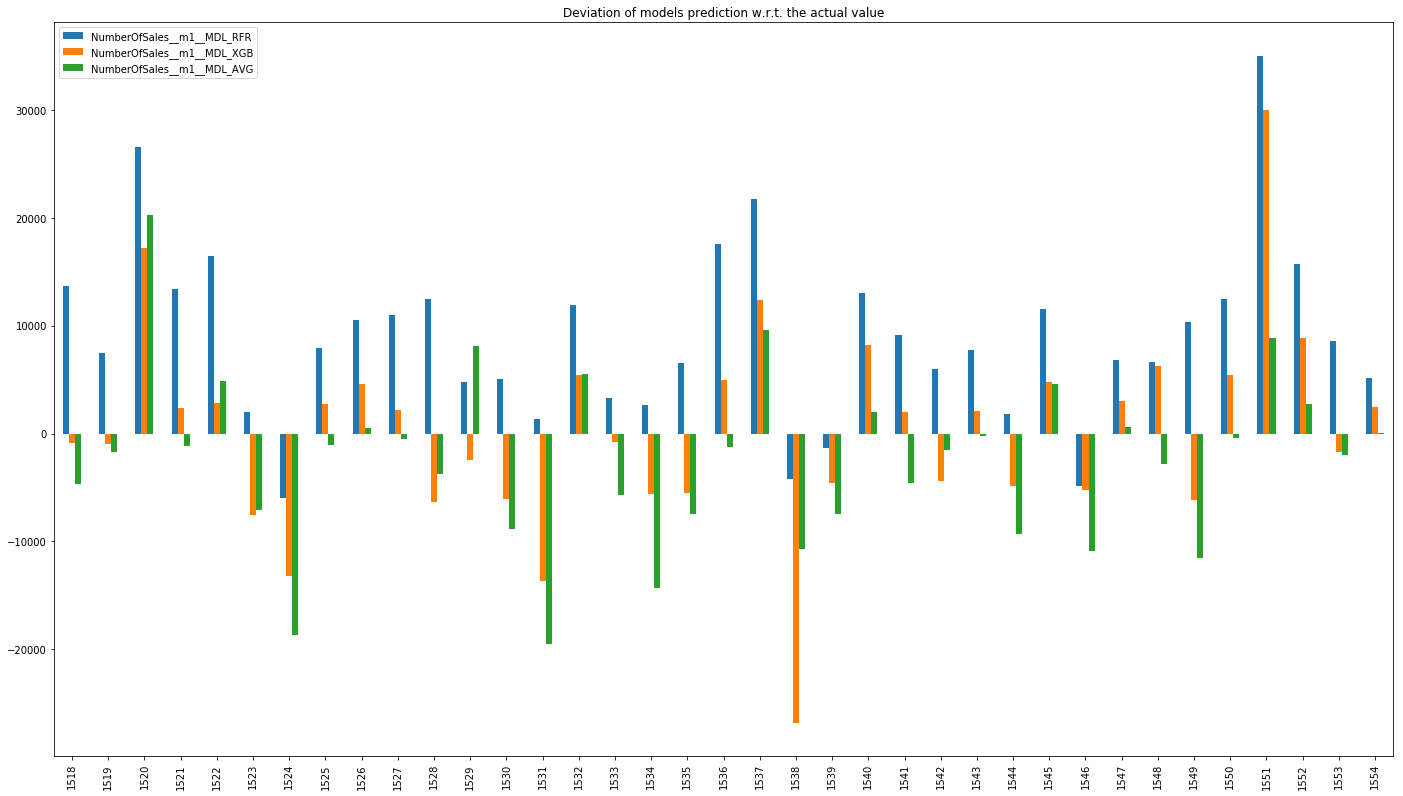

<Figure size 432x288 with 0 Axes>

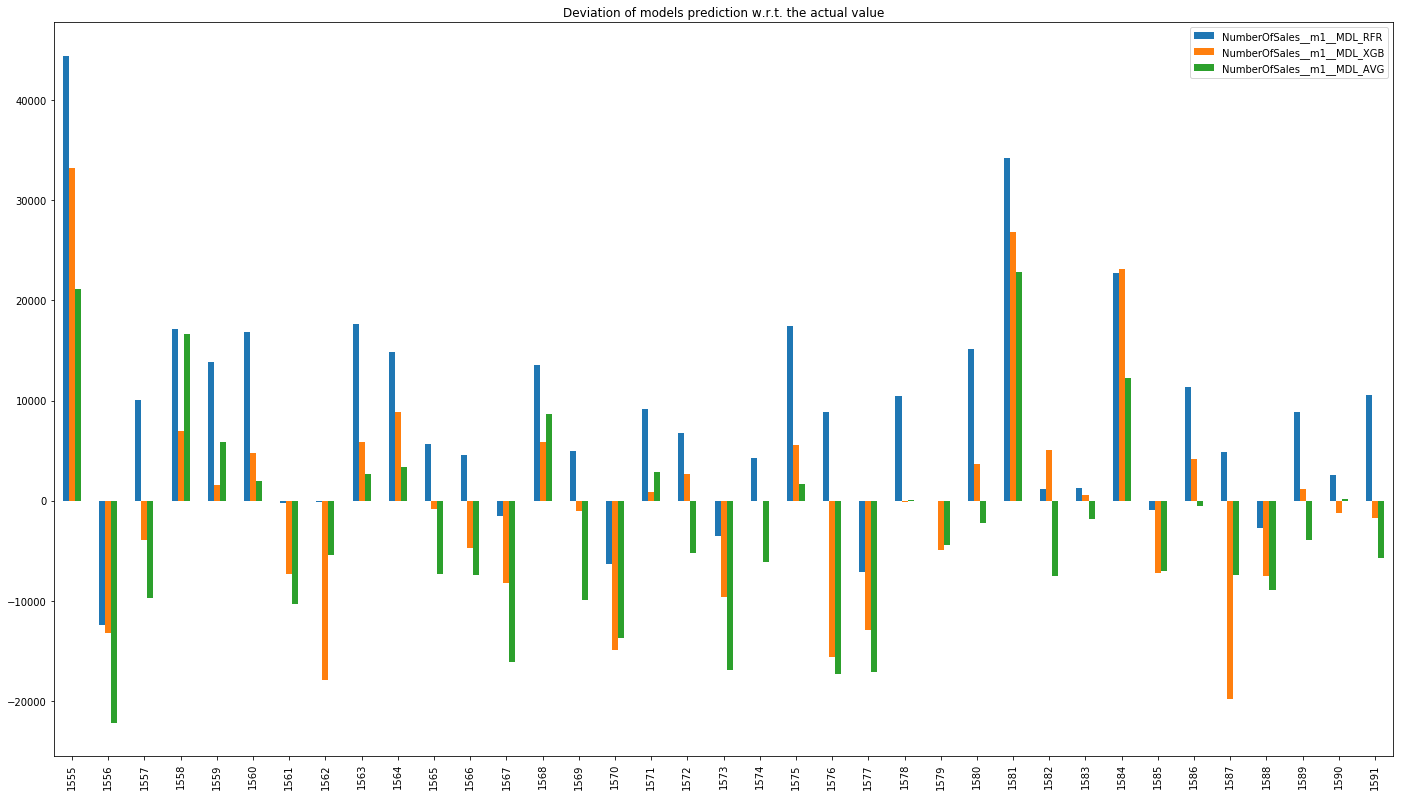

<Figure size 432x288 with 0 Axes>

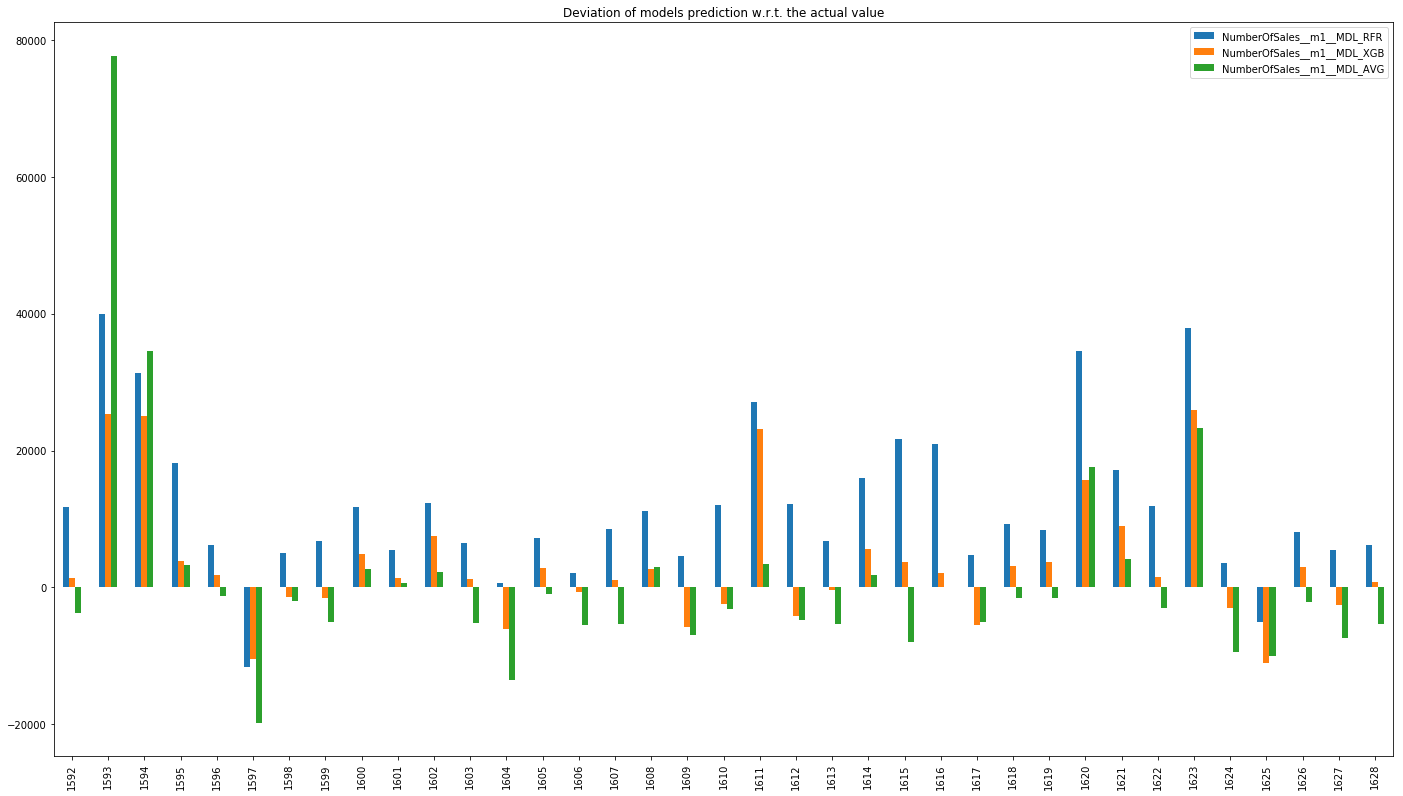

<Figure size 432x288 with 0 Axes>

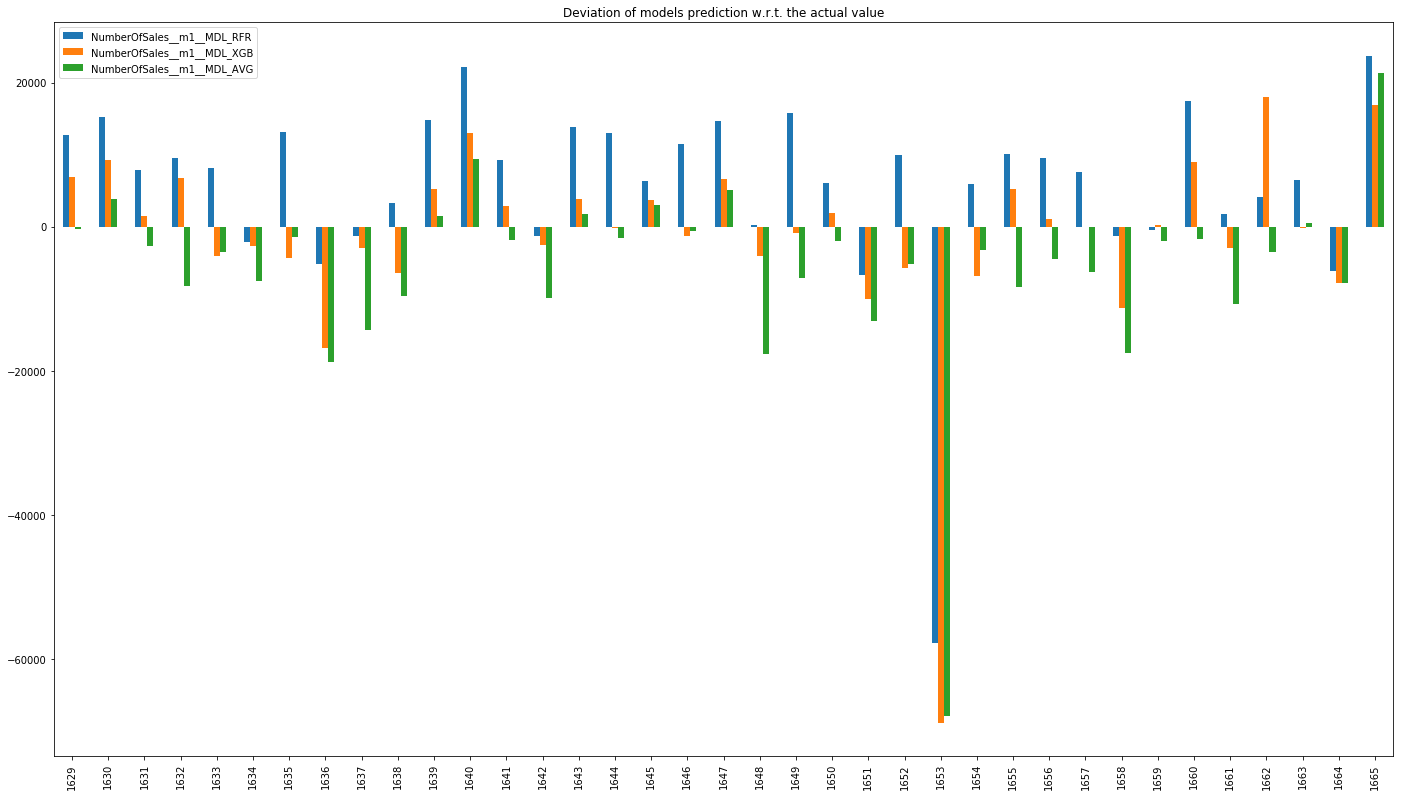

<Figure size 432x288 with 0 Axes>

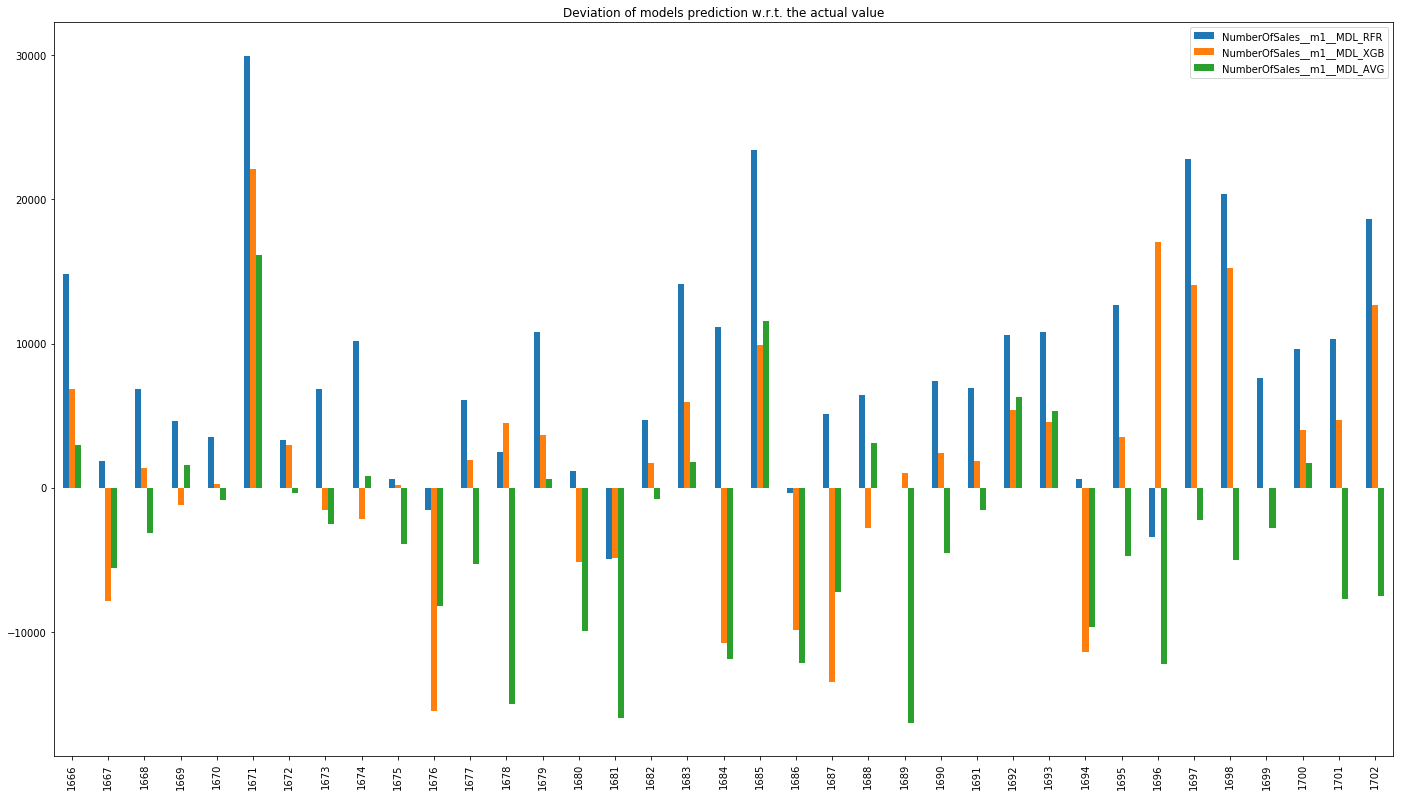

<Figure size 432x288 with 0 Axes>

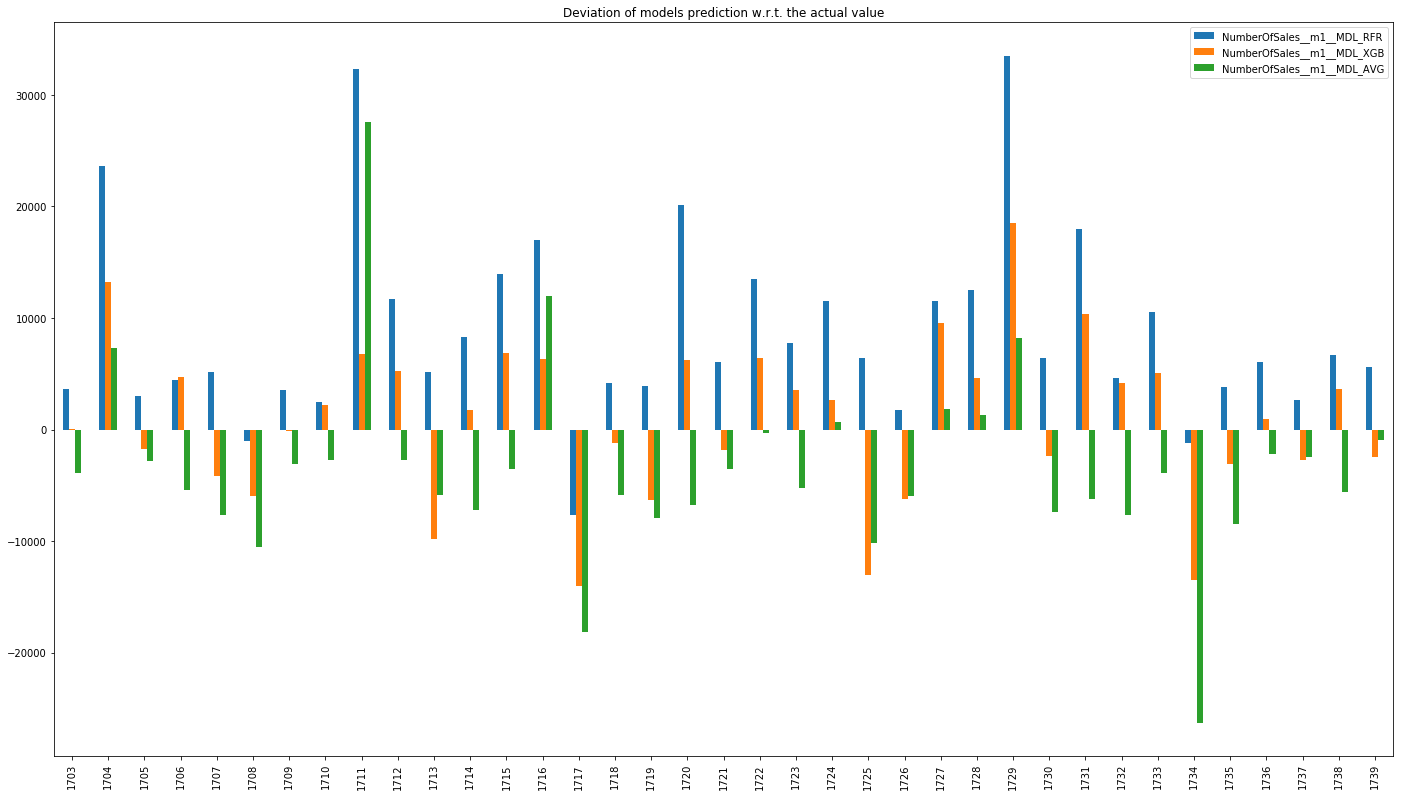

<Figure size 432x288 with 0 Axes>

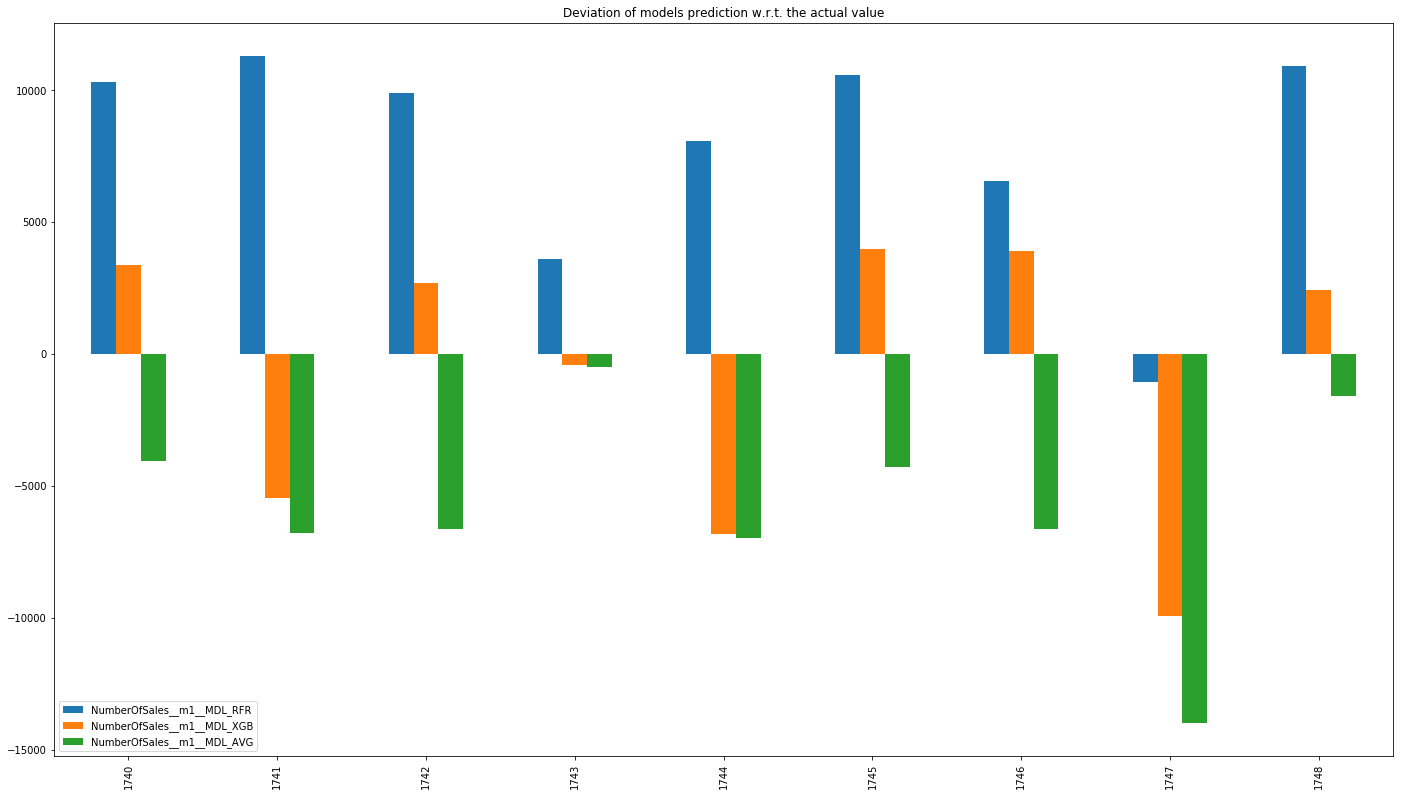

In [16]:
plot_deviation_from_target(df_plots, month=0)  # to print them all
#plot_deviation_from_target(df_plots, month=0, first=10, last=11) # just print one

### SECOND MONTH: Deviation from target of predictions

<Figure size 432x288 with 0 Axes>

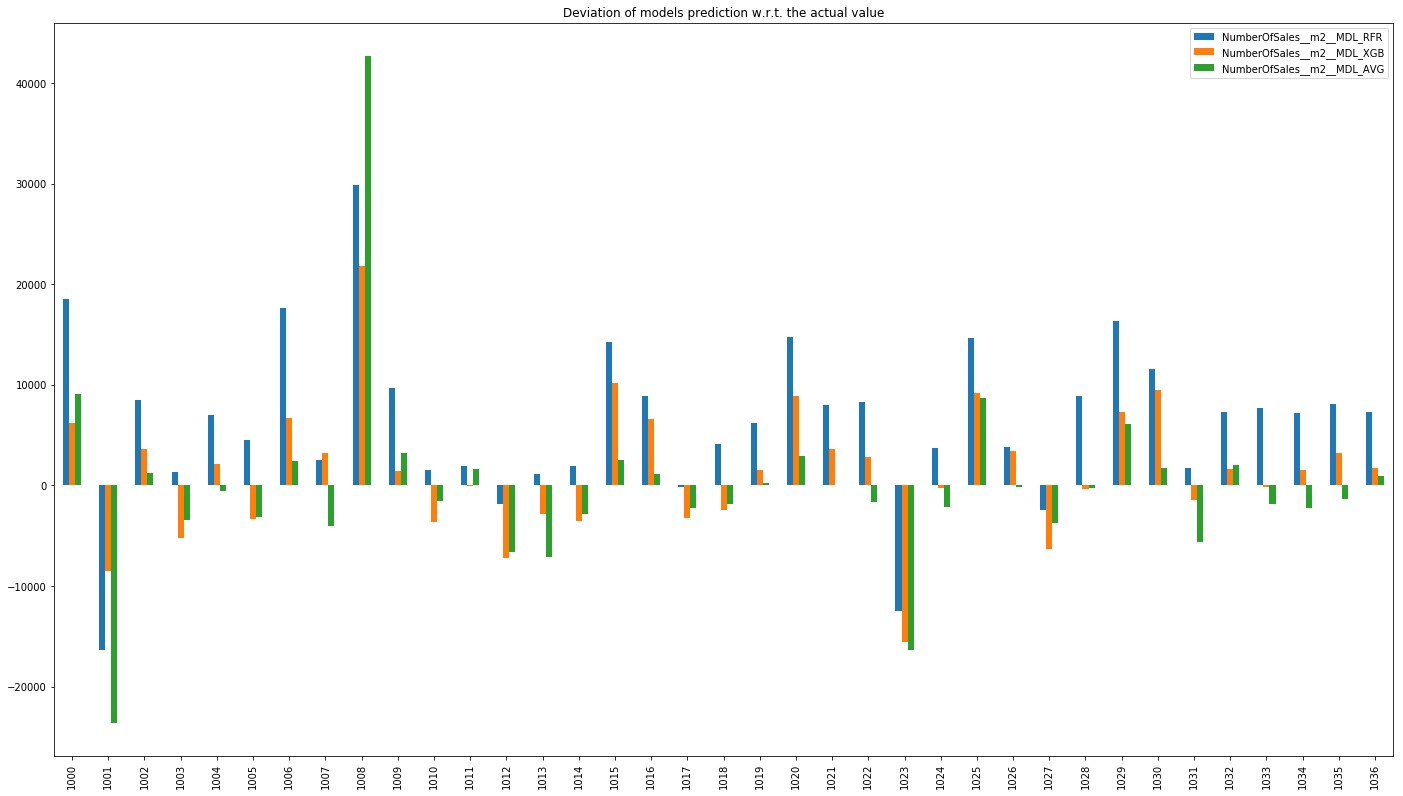

<Figure size 432x288 with 0 Axes>

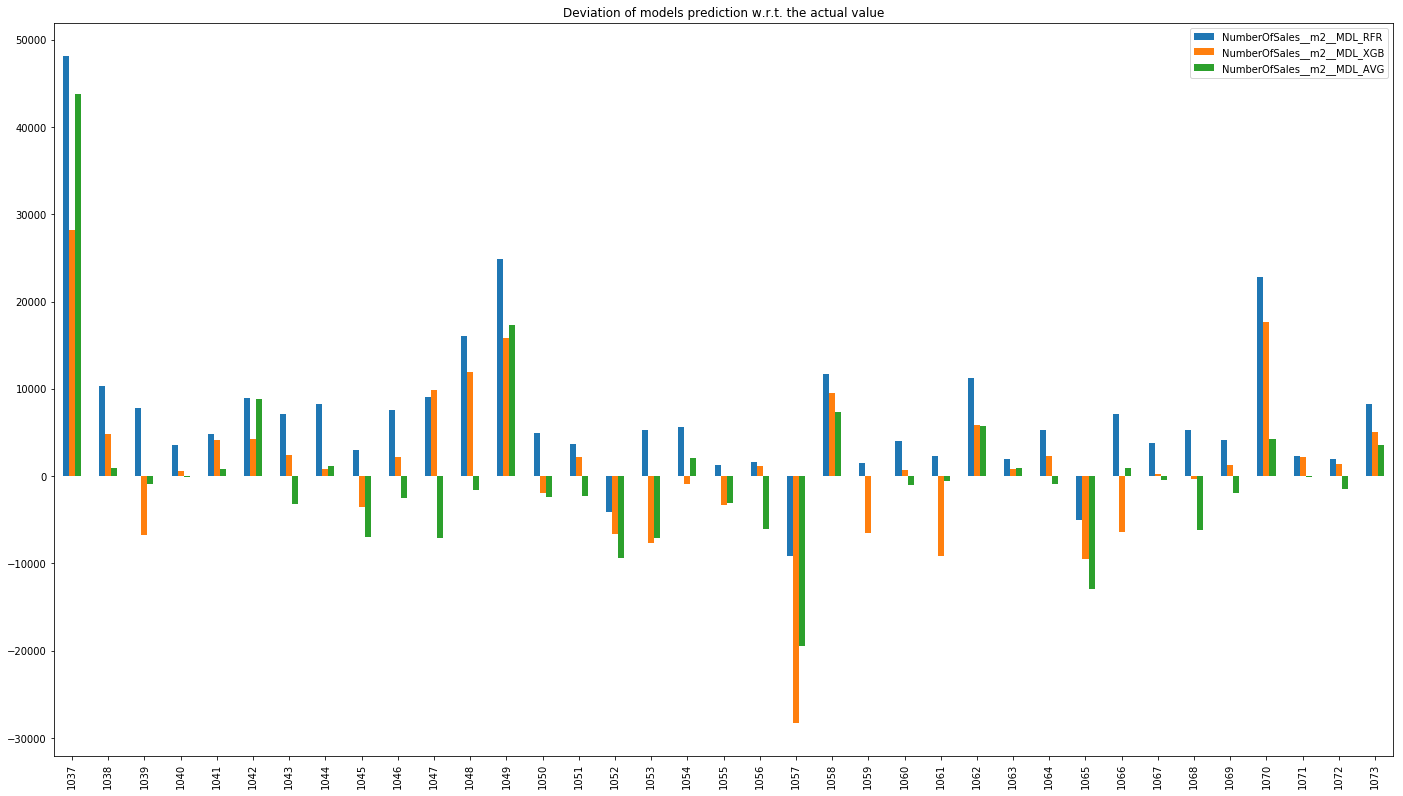

<Figure size 432x288 with 0 Axes>

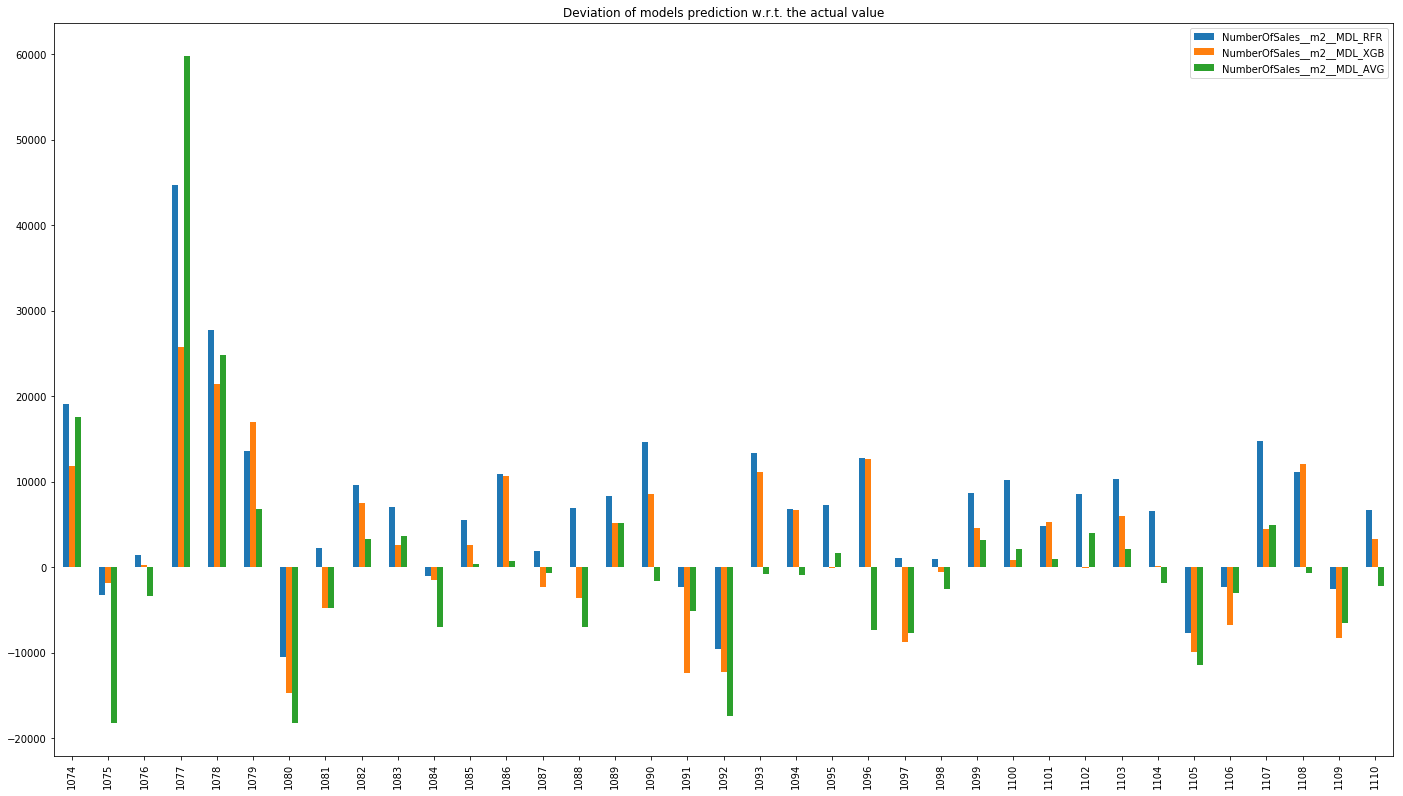

<Figure size 432x288 with 0 Axes>

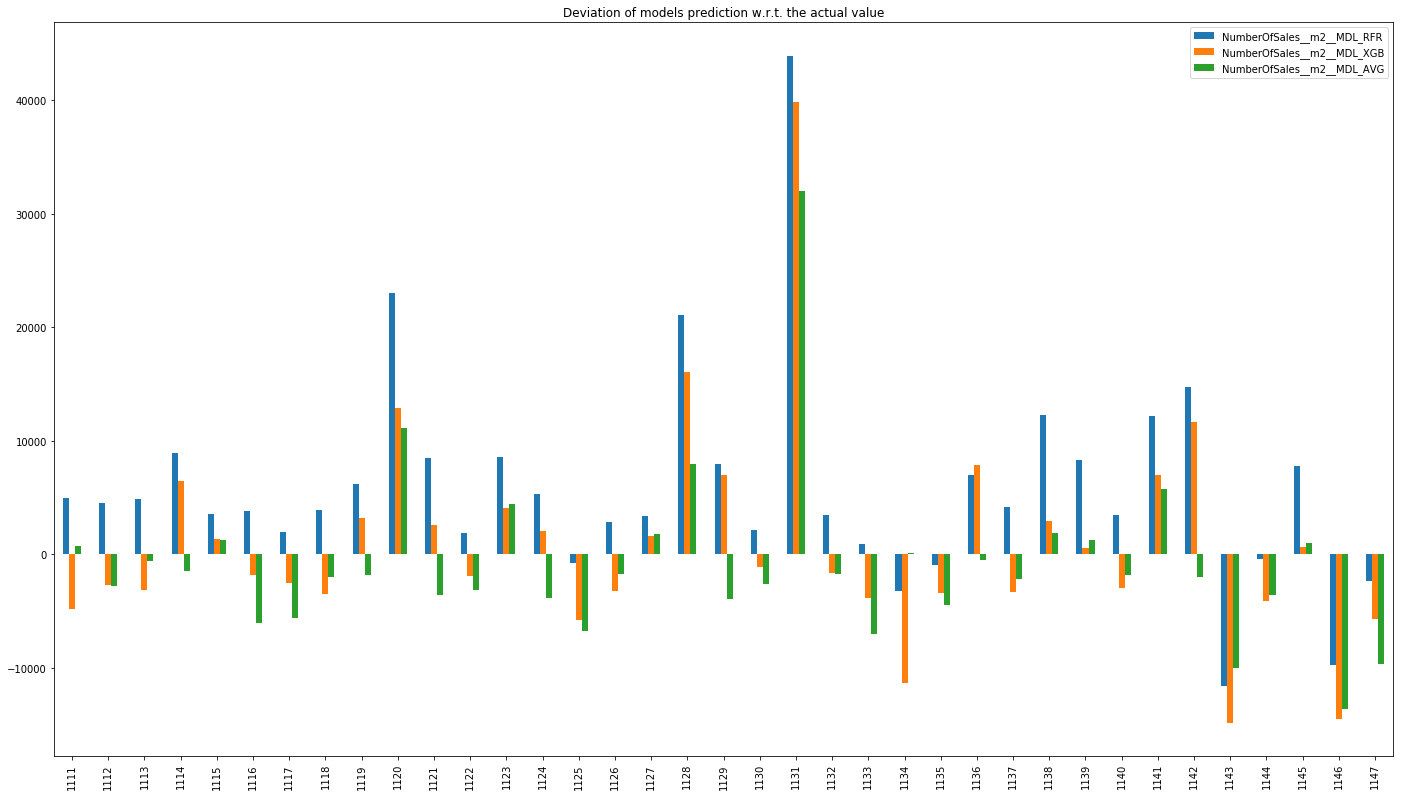

<Figure size 432x288 with 0 Axes>

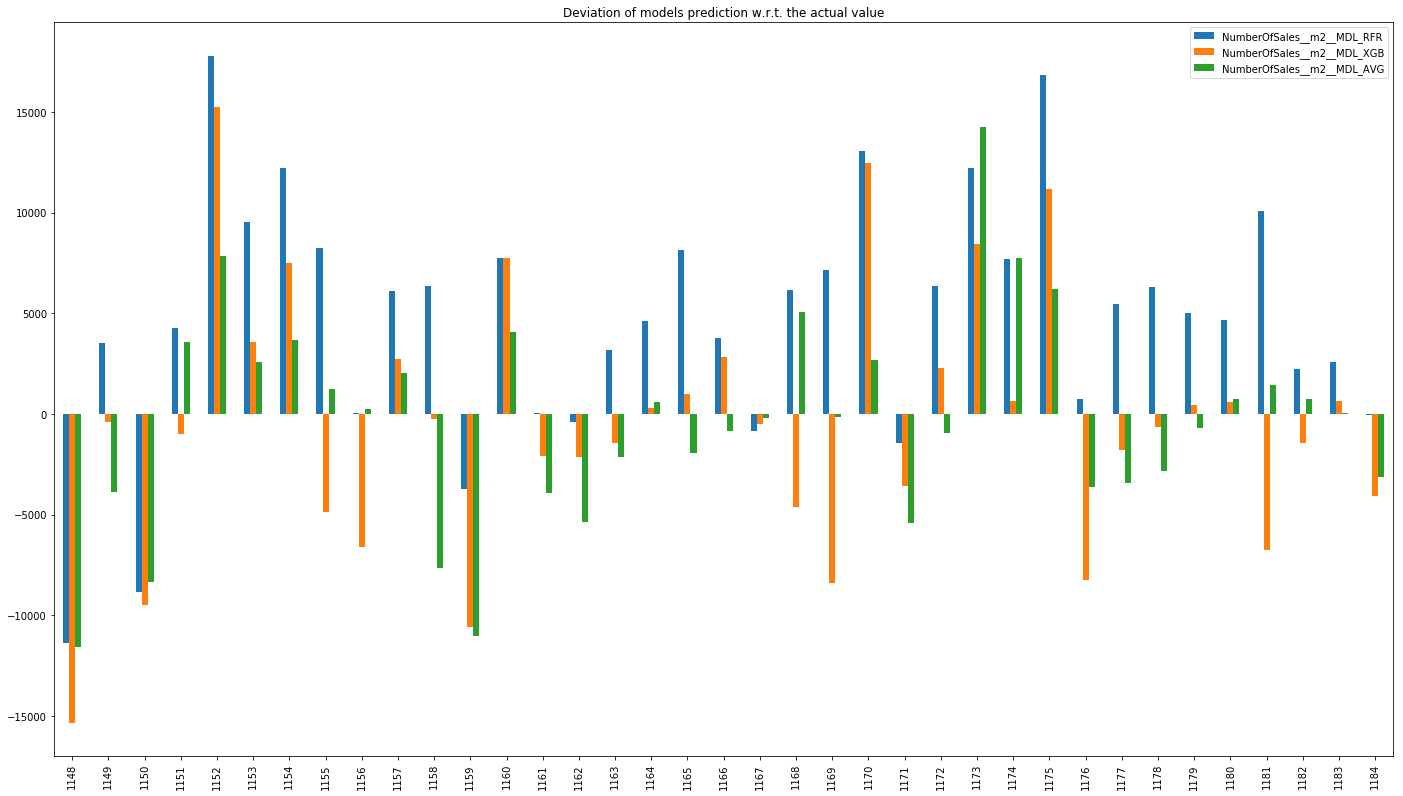

<Figure size 432x288 with 0 Axes>

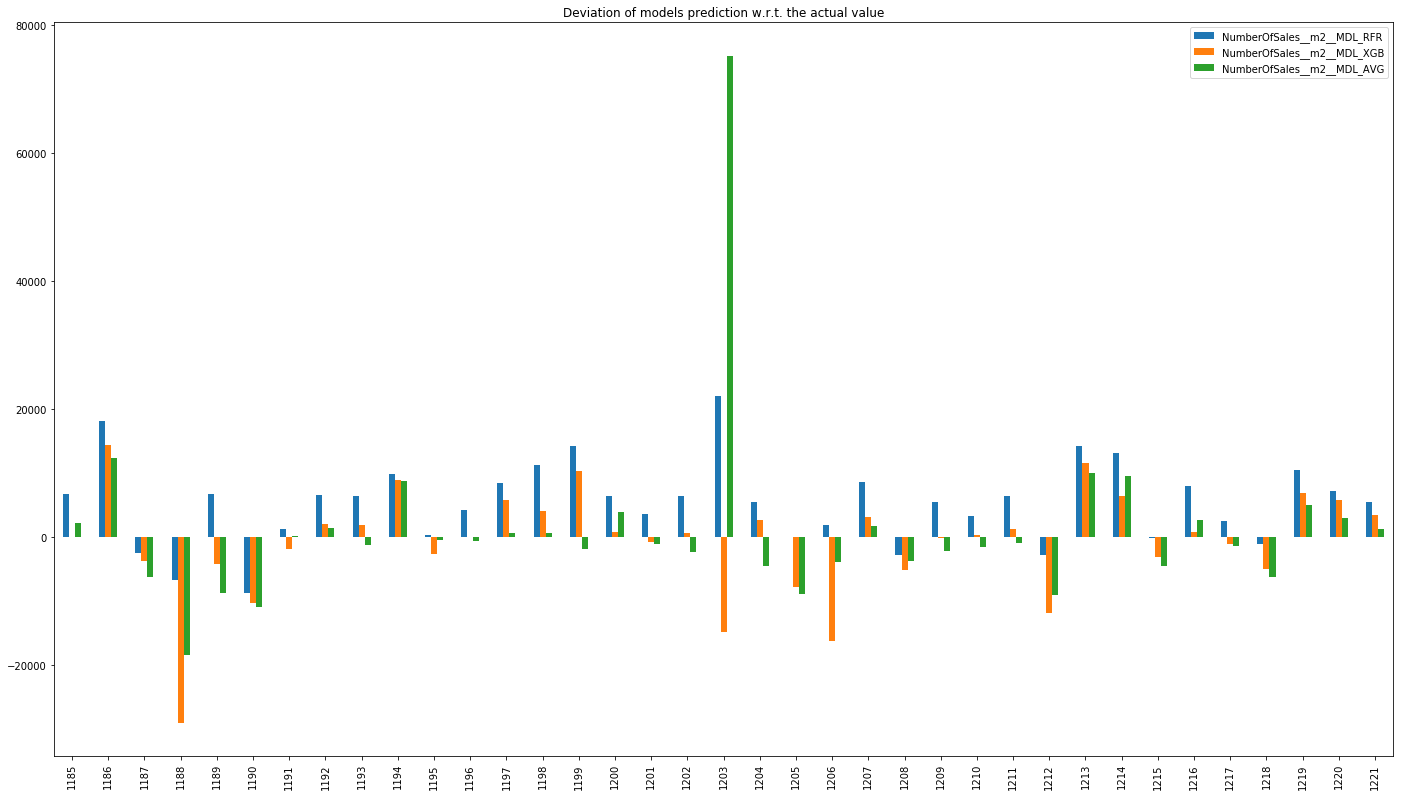

<Figure size 432x288 with 0 Axes>

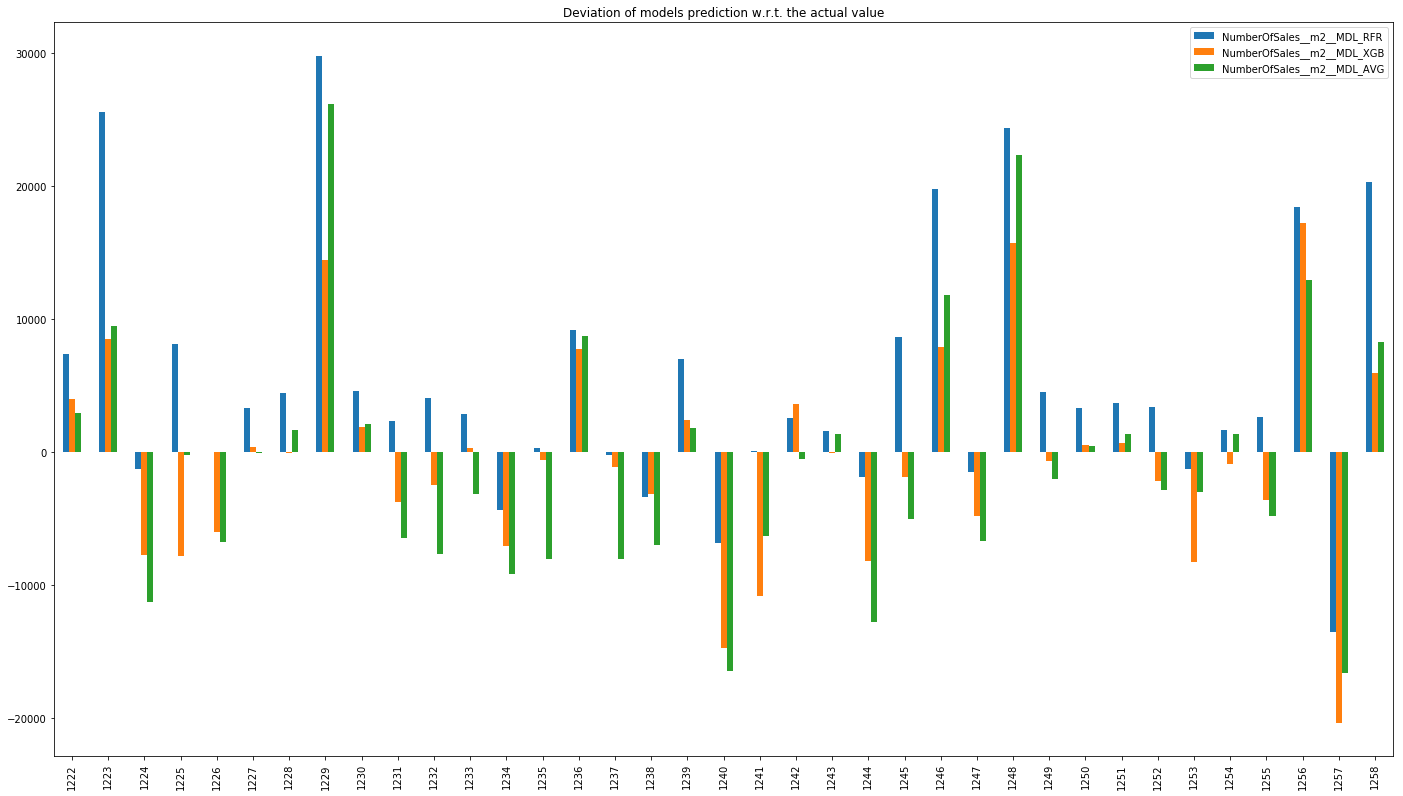

<Figure size 432x288 with 0 Axes>

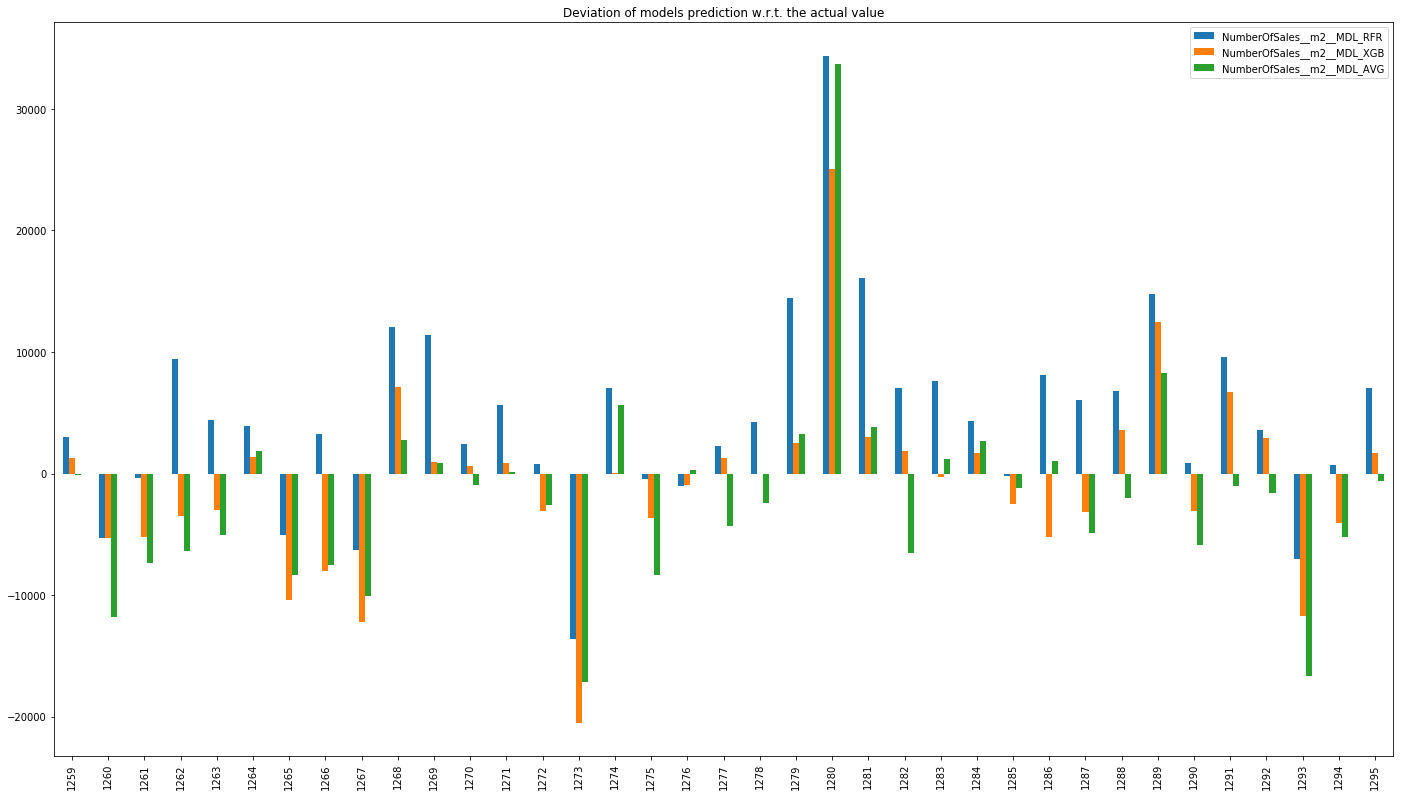

<Figure size 432x288 with 0 Axes>

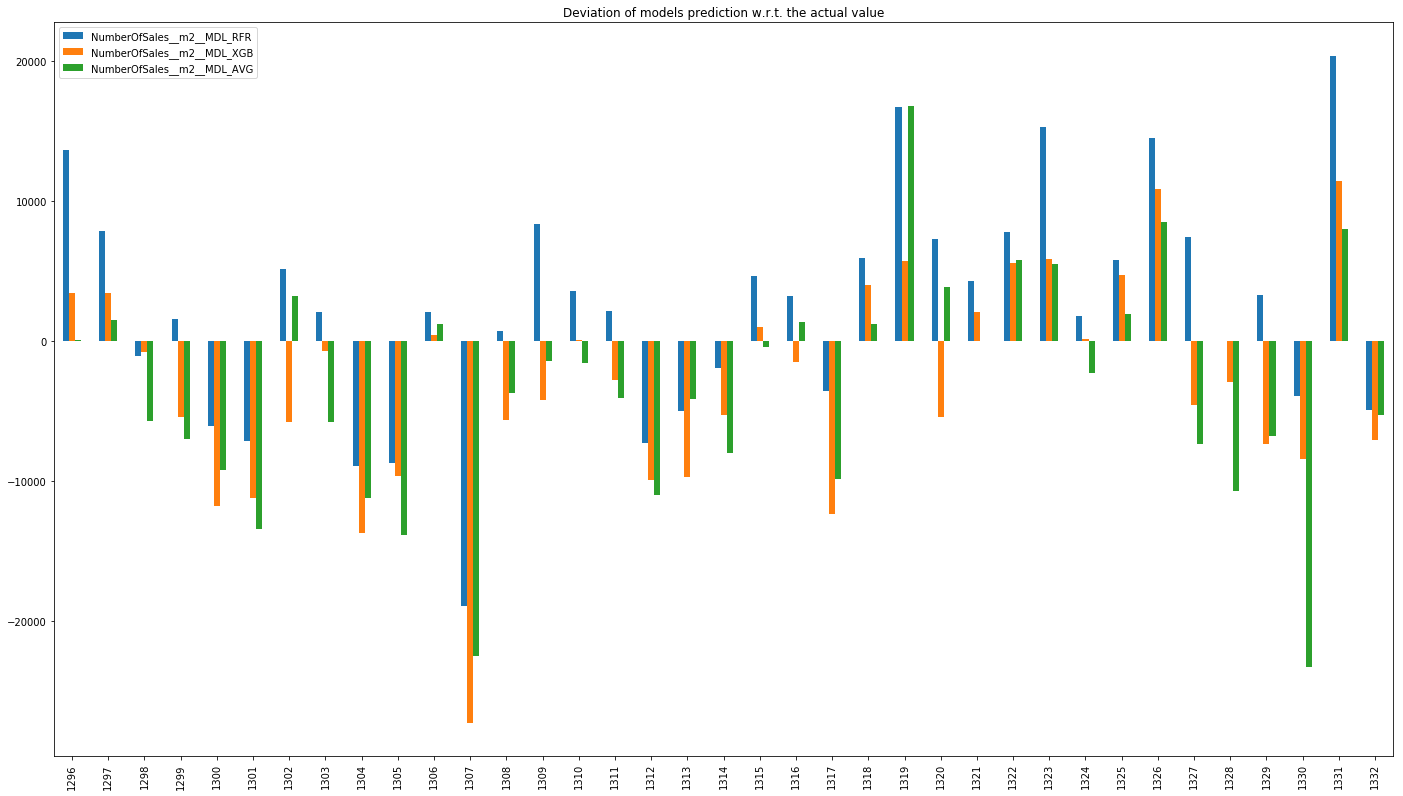

<Figure size 432x288 with 0 Axes>

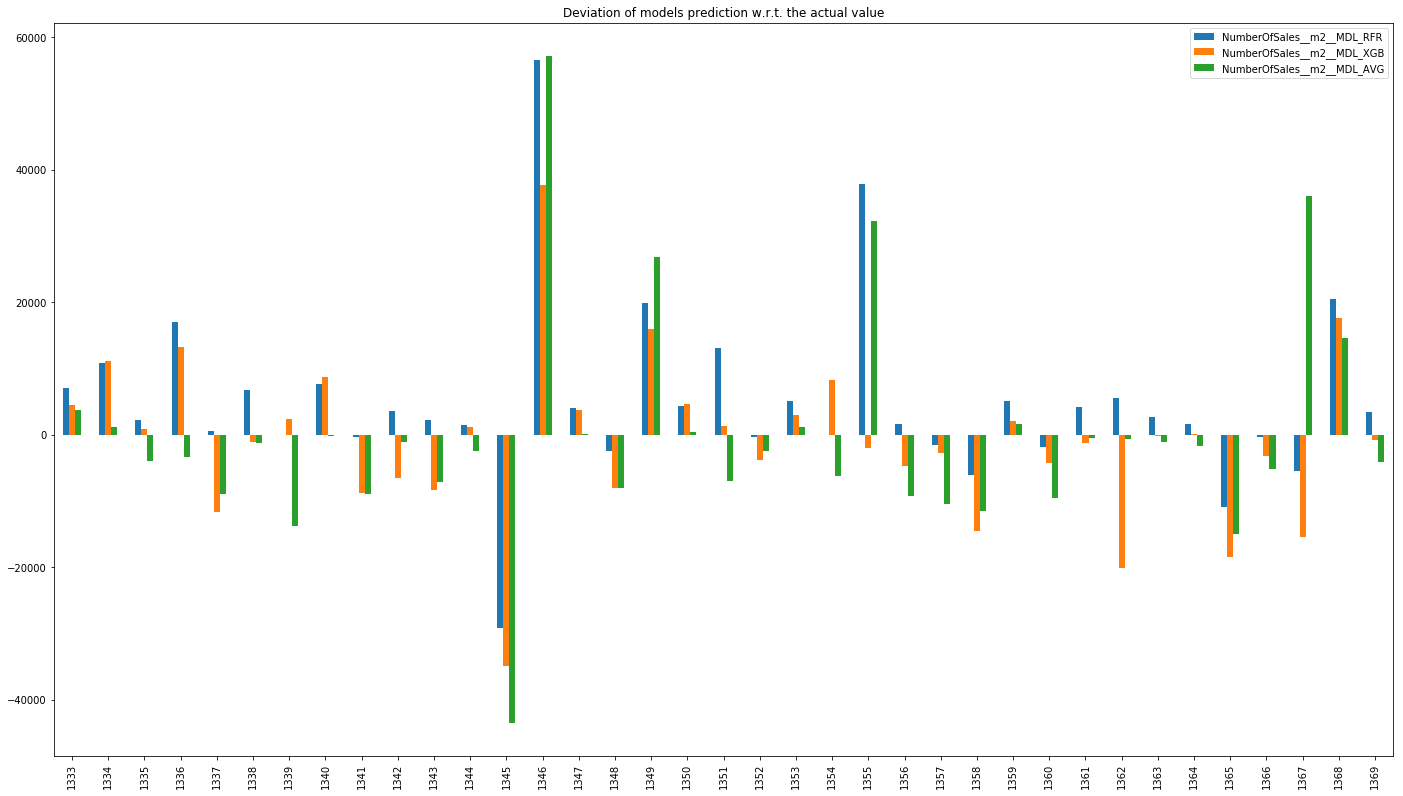

<Figure size 432x288 with 0 Axes>

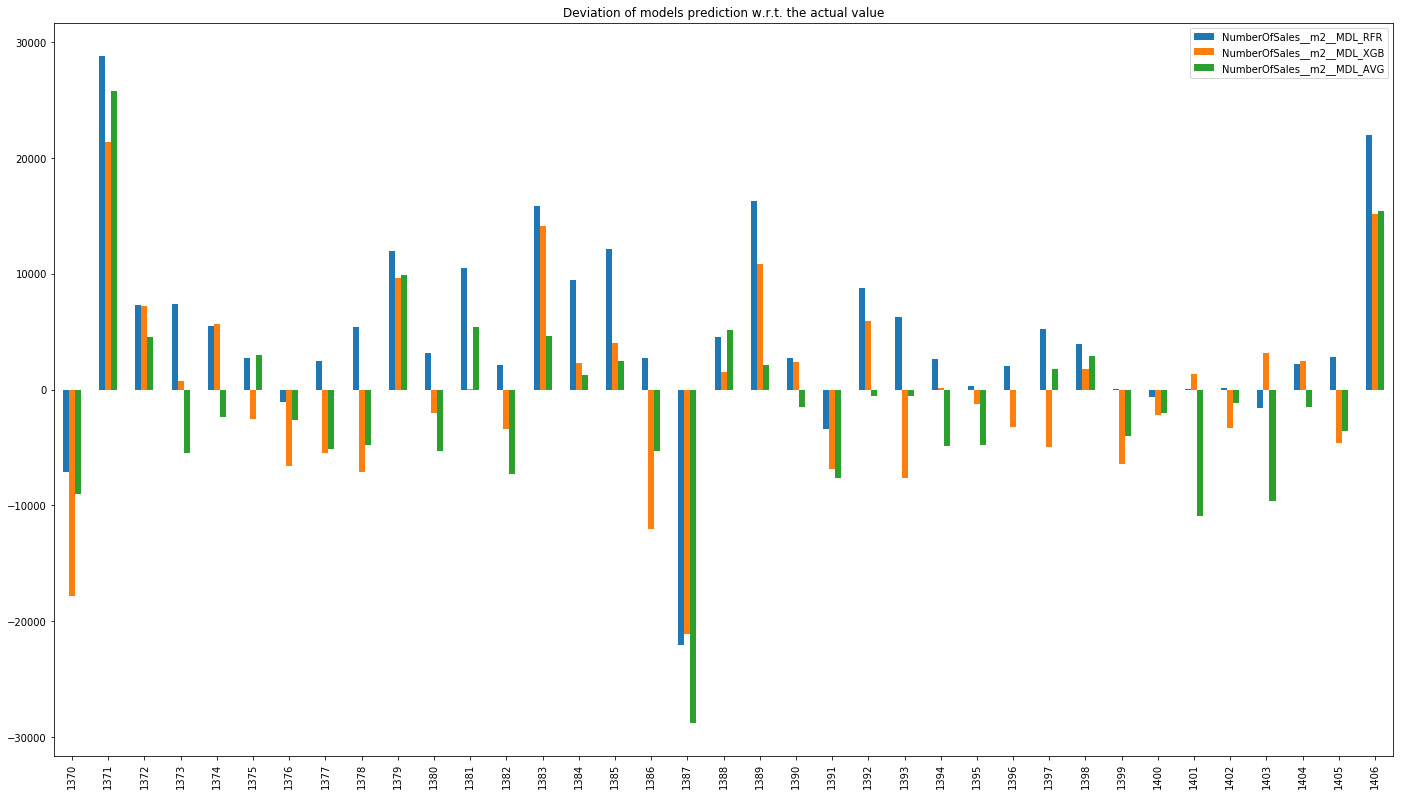

<Figure size 432x288 with 0 Axes>

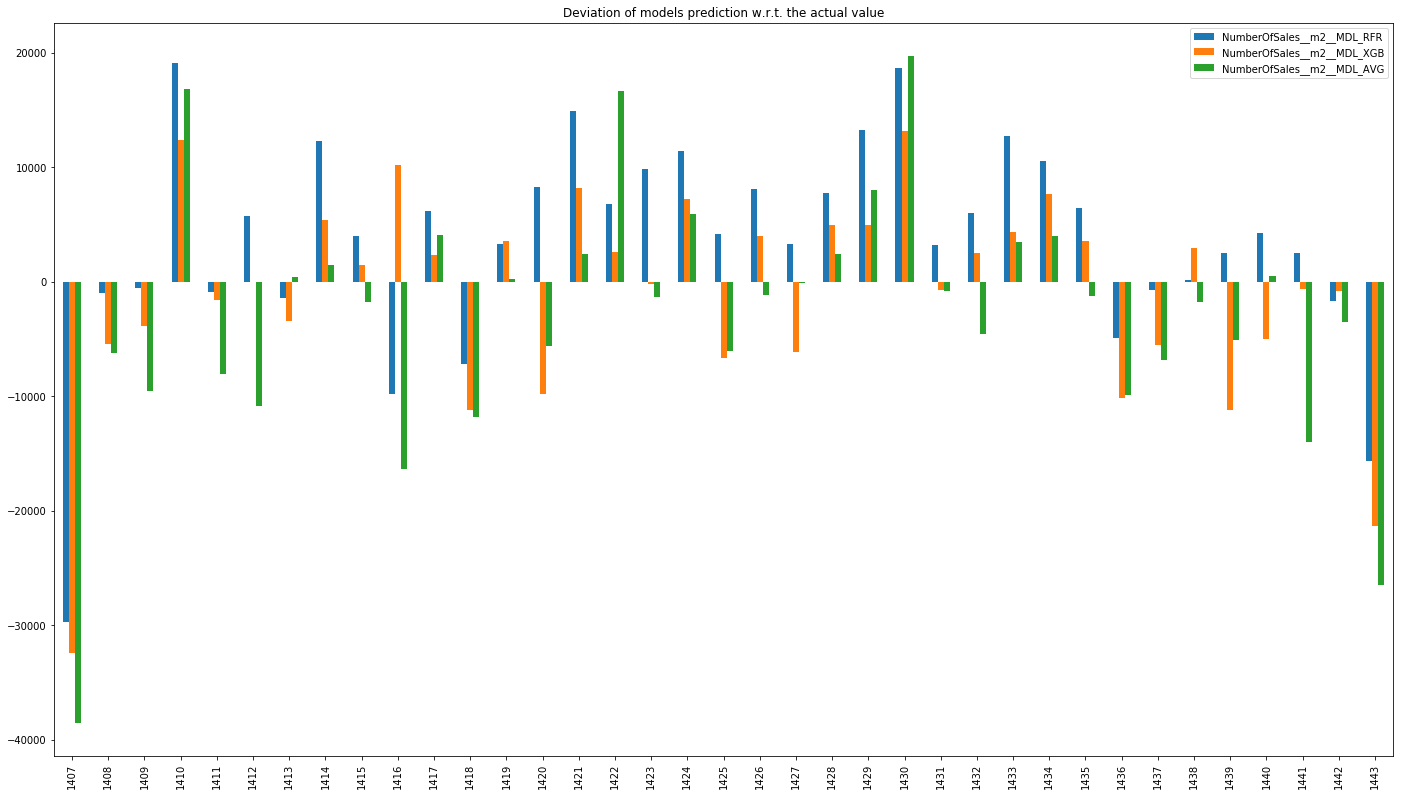

<Figure size 432x288 with 0 Axes>

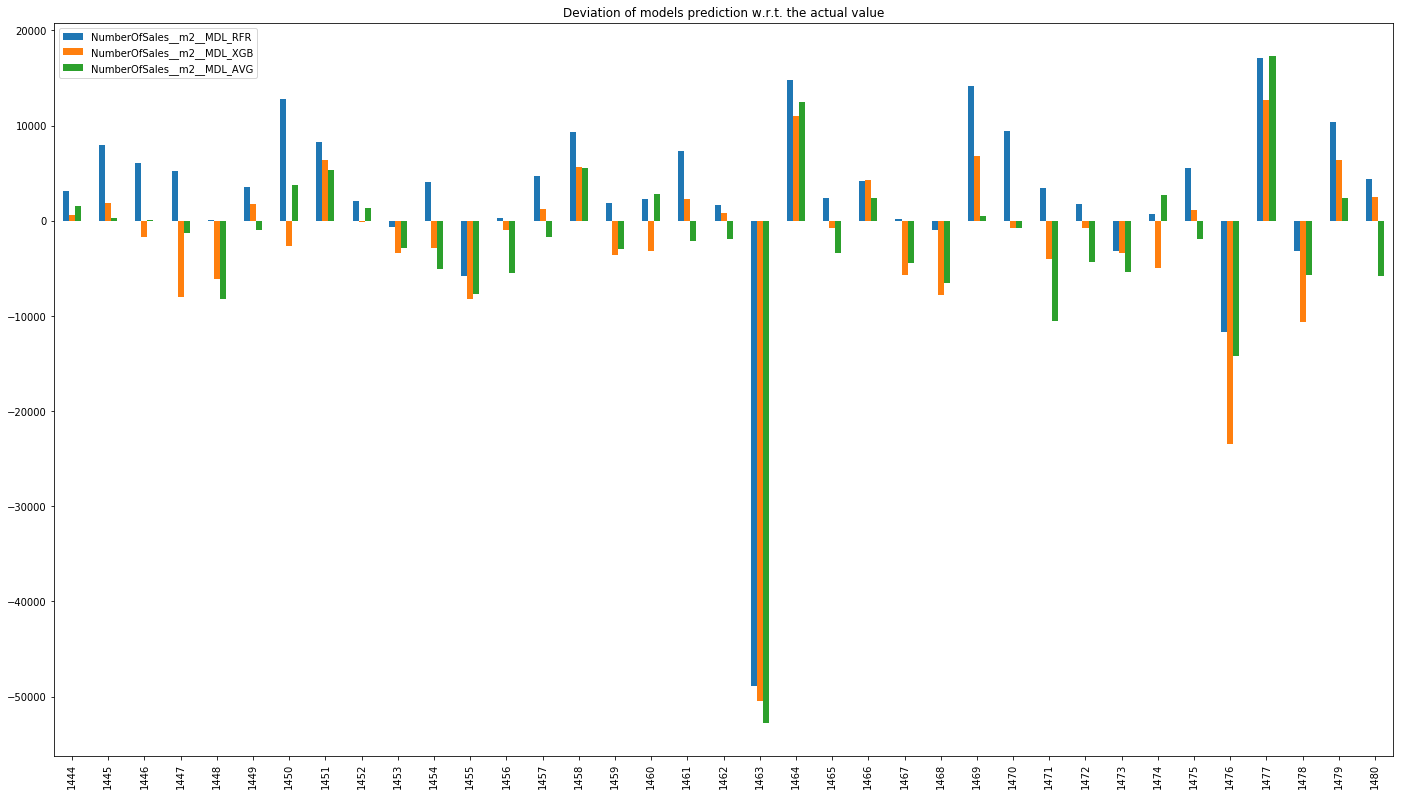

<Figure size 432x288 with 0 Axes>

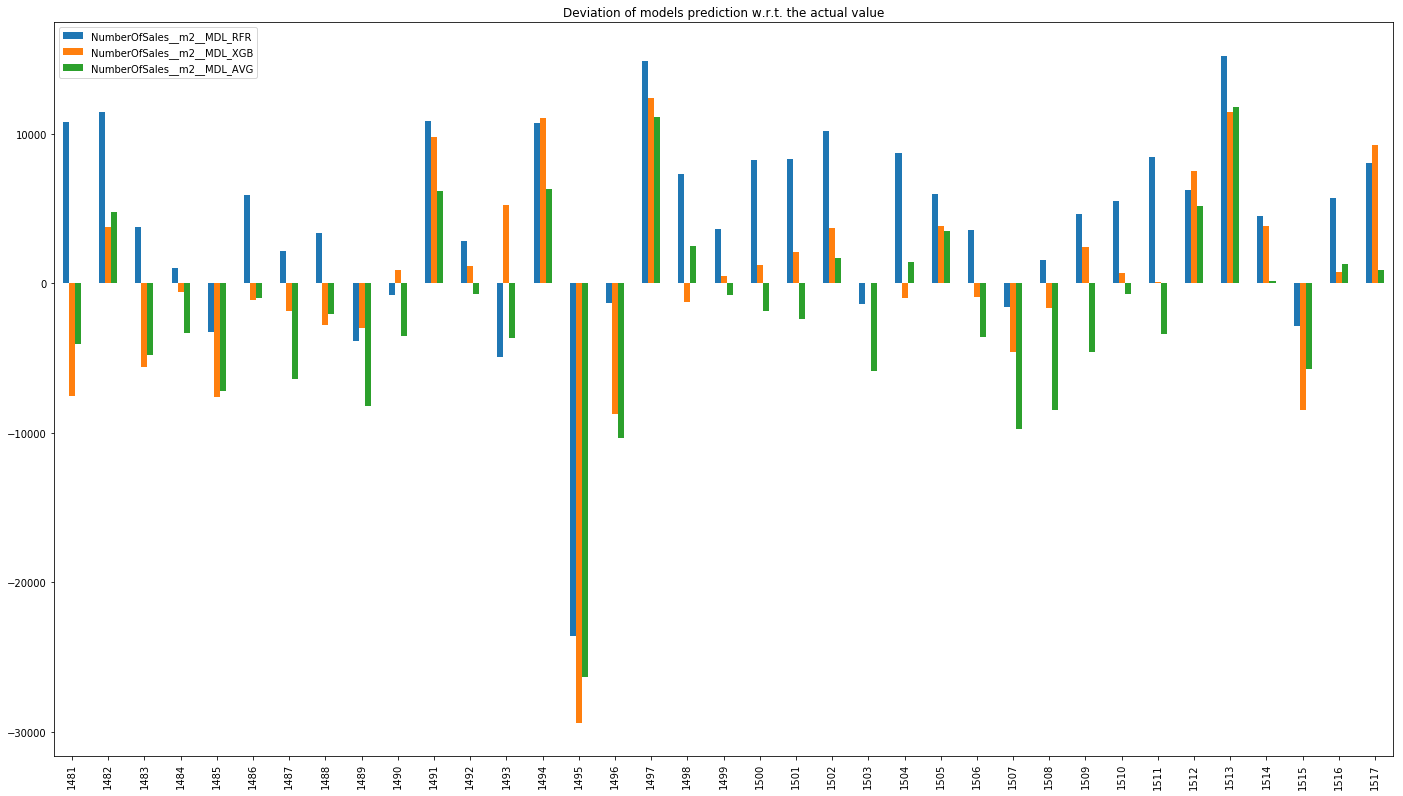

<Figure size 432x288 with 0 Axes>

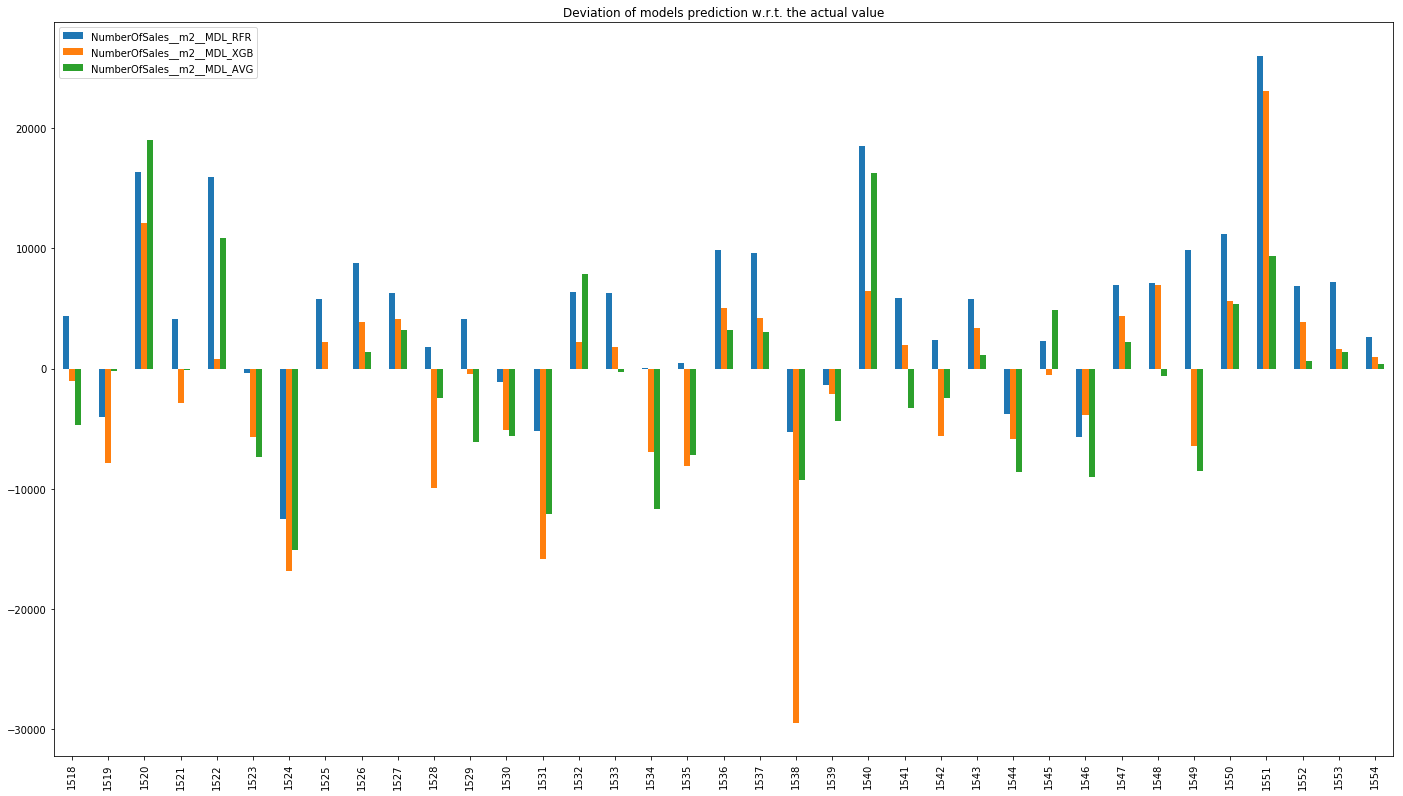

<Figure size 432x288 with 0 Axes>

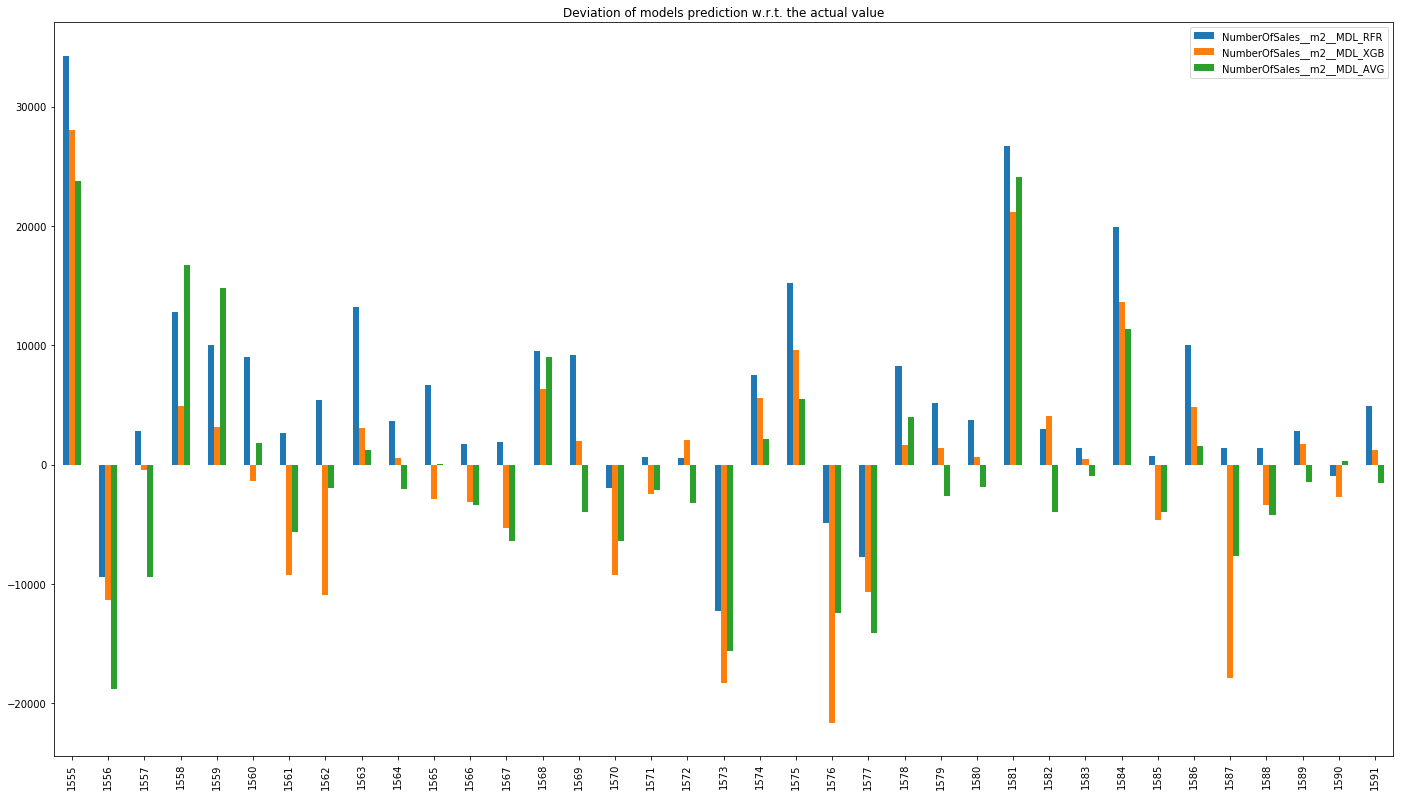

<Figure size 432x288 with 0 Axes>

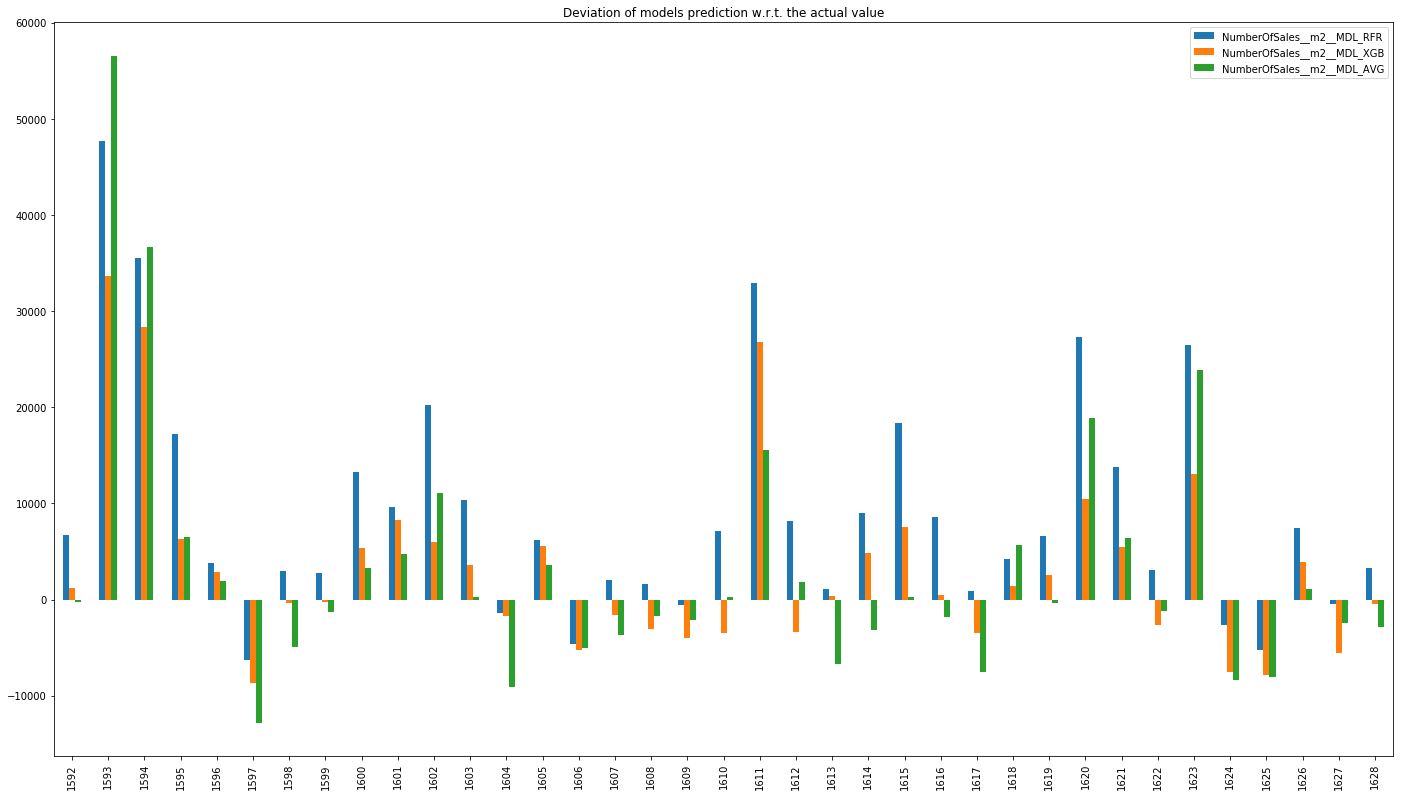

<Figure size 432x288 with 0 Axes>

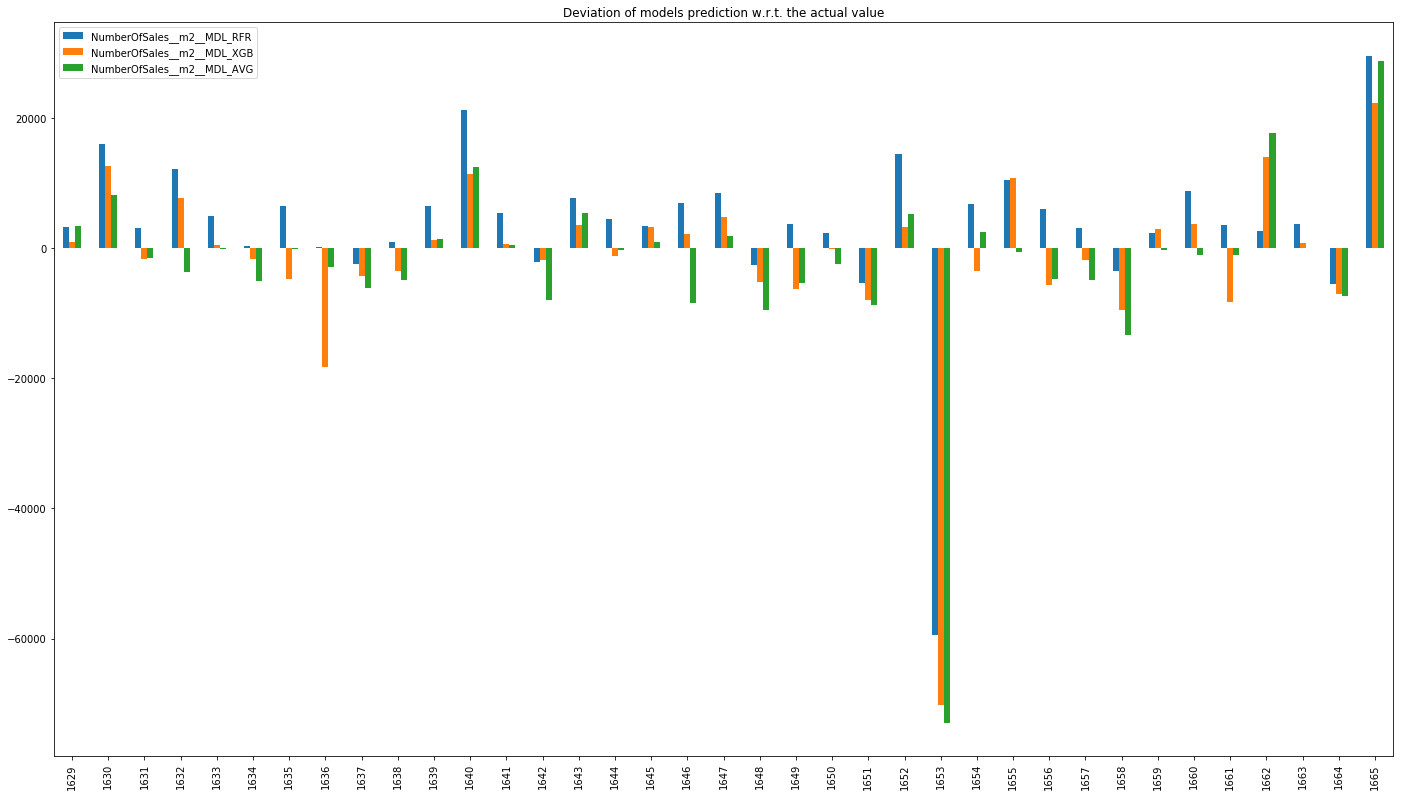

<Figure size 432x288 with 0 Axes>

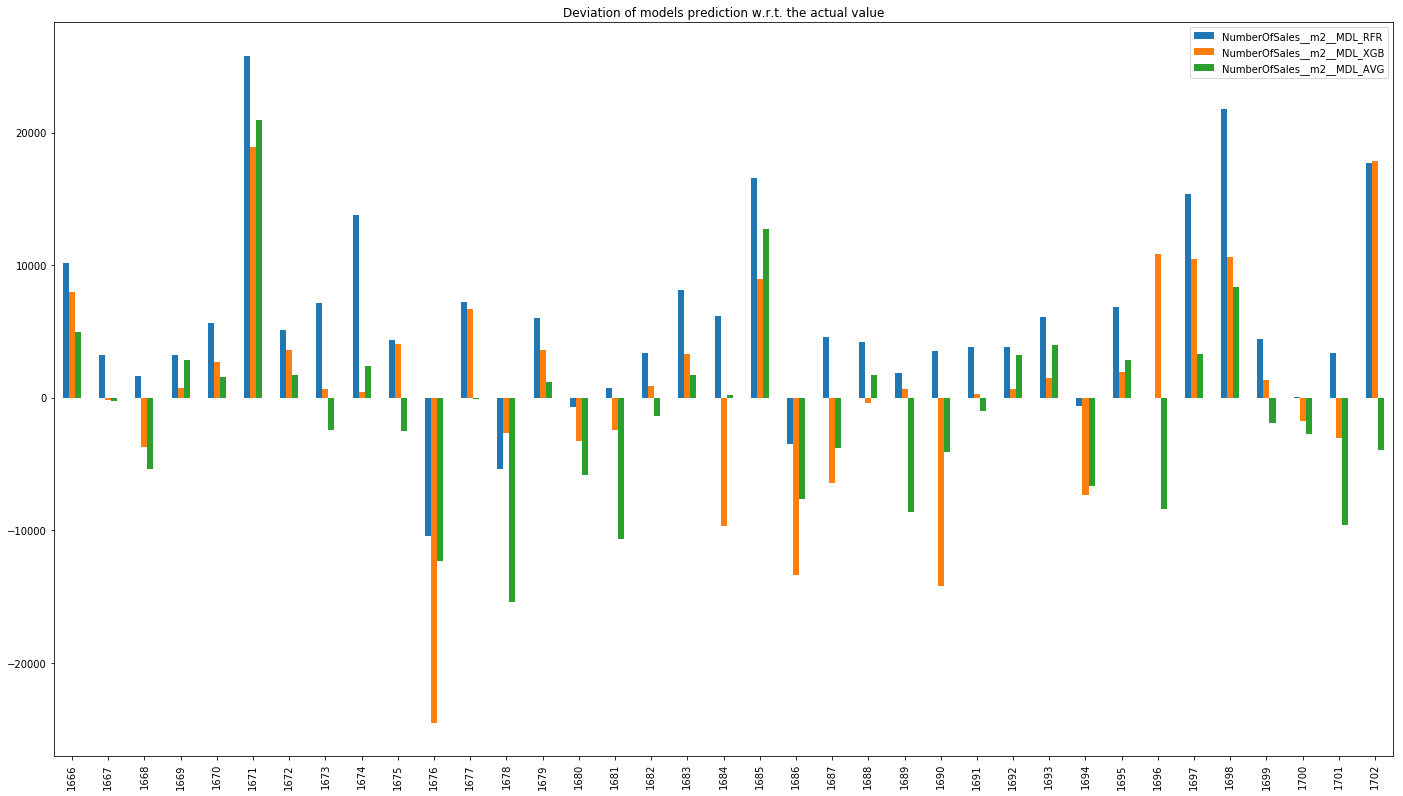

<Figure size 432x288 with 0 Axes>

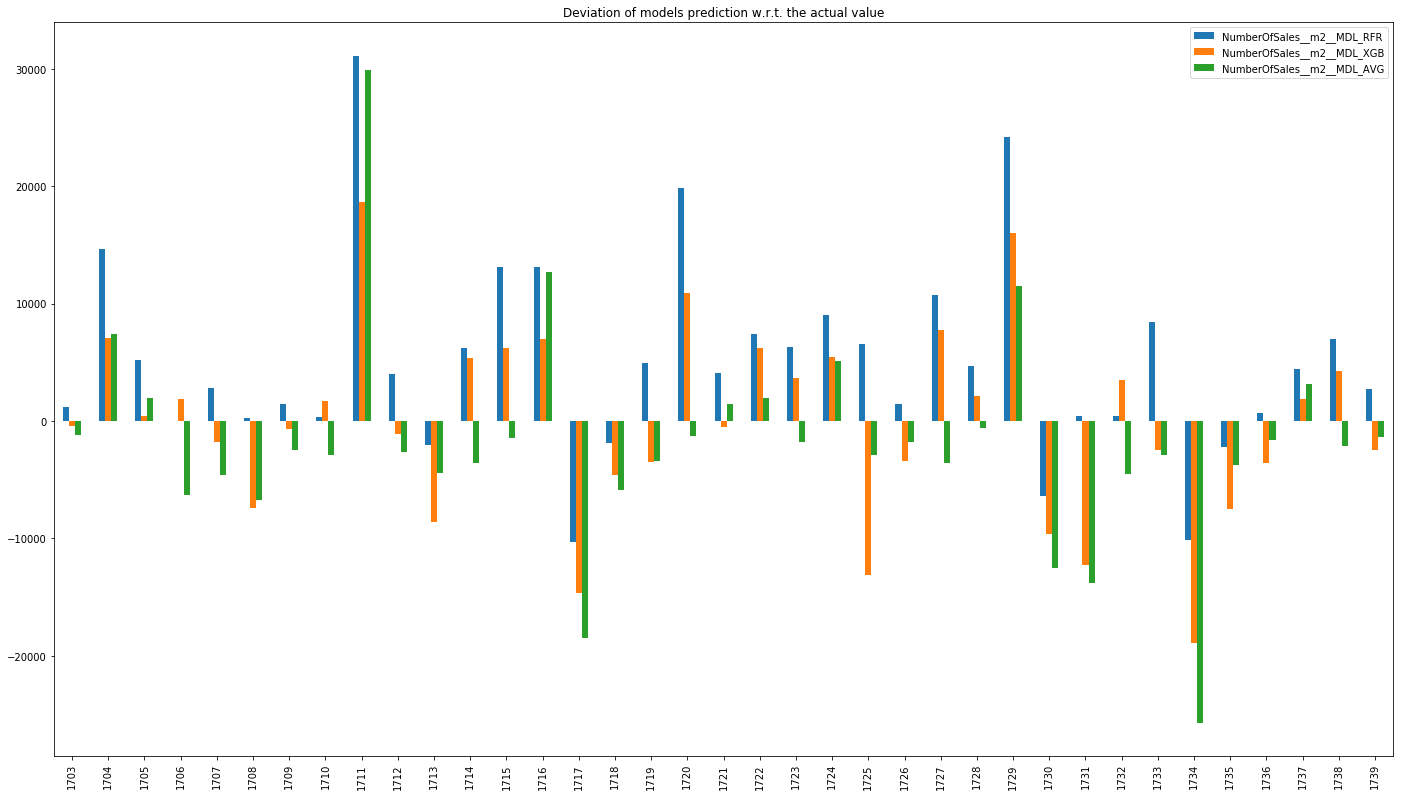

<Figure size 432x288 with 0 Axes>

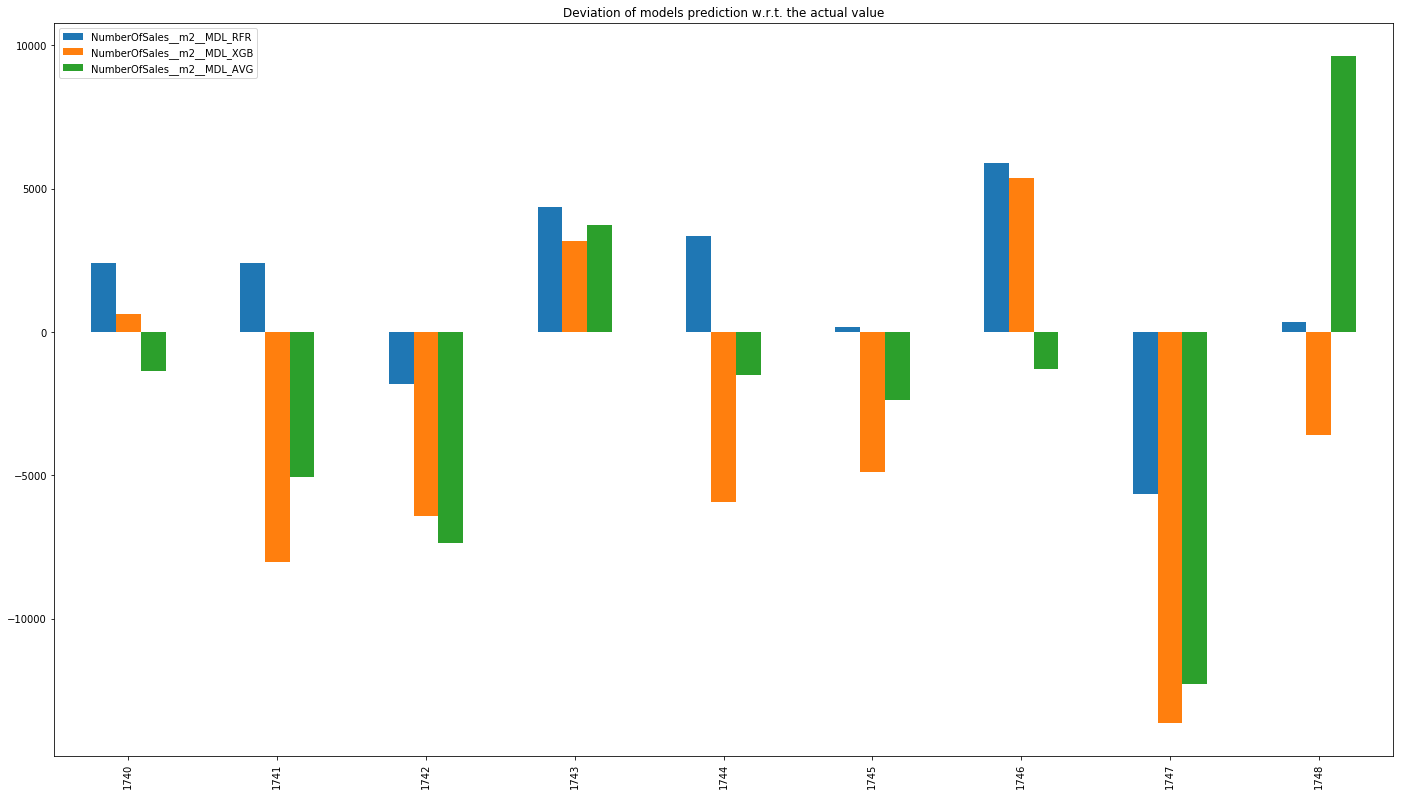

In [17]:
plot_deviation_from_target(df_plots, month=1)  # to print them all
#plot_deviation_from_target(df_plots, month=1, first=10, last=11) # just print one